# 1.导入库

In [1]:
import numpy as np
import pandas as pd
import mne
from mne import EpochsArray
from mne import pick_types
from mne.io import concatenate_raws, read_raw_edf
from mne.channels import make_standard_montage
from mne.epochs import concatenate_epochs
from mne.preprocessing import ICA,corrmap
from mne import create_info, find_events, Epochs
from mne.viz.topomap import plot_topomap #,_prepare_topo_plot
from mne.decoding import CSP
from mne.time_frequency import psd_multitaper,psd_welch
from mne_connectivity import spectral_connectivity_epochs,spectral_connectivity_time
import pywt #Pywavelets

from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score,confusion_matrix,accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneGroupOut
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler #归一化与标准化
from sklearn.decomposition import FastICA
from glob import glob

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy.signal import welch
from scipy.fftpack import rfft, irfft, fftfreq
from subprocess import check_output
import scipy.io as scio

import os
import time
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')


import logging

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from torch.utils.data import TensorDataset,DataLoader
from torch.utils.data.dataset import random_split
torch.set_default_tensor_type(torch.DoubleTensor)
#from torchmetrics import F1Score, Accuracy, Recall, Precision, Specificity, ConfusionMatrix
from scipy.optimize import curve_fit
from scipy.fftpack import fft
from timm.models.layers import trunc_normal_, DropPath

print(torch.__version__)
print(torch.cuda.is_available())

/home/violin/anaconda3/envs/violin/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


1.8.0
True


# 2.数据加载与预处理

## 2.1 原数据集

In [2]:
def preprocess_raw(raw):
    #有原20和22通道的区别 但19个EEG通道是共有的
    if len(raw.ch_names)==20:
        raw.drop_channels(raw.info['ch_names'][-1:])
    else:  
        raw.drop_channels(raw.info['ch_names'][-3:])

    old_channels = raw.info['ch_names']
    channel_dict = { ch:ch.split(" ")[1].split("-")[0] for ch in old_channels}
    raw.rename_channels(channel_dict)
    raw.set_montage('standard_1020',on_missing = 'warn')


In [3]:
#可以选择只保留时频域的 或者保留时域+时频域的
def cwt(raw):
    sampling_rate = 256
    wavename = 'cgau8'
    totalscal = 4
    # 中心频率
    fc = pywt.central_frequency(wavename)
    # 计算对应频率的小波尺度
    cparam = 8 * fc * totalscal  #这里本来是2
    scales = cparam / np.arange(totalscal, 0, -0.5) #这里本来是-1
    data = raw
    raw_tf = []
    #组织格式应该是np.array 然后19channels*times*8components
    for i in range(19):
        [cwtmatr, frequencies] = pywt.cwt(data[i], scales, wavename, 1.0 / sampling_rate)
        cwtmatr = np.transpose(np.array(abs(cwtmatr)))
        raw_tf.append(np.concatenate([np.expand_dims(data[i],axis=1),cwtmatr],axis=1)) #19channels*times*(1+8)components
        #raw_tf.append(cwtmatr)
    raw_tf = np.array(raw_tf)
    #print(raw_tf.shape)
    return raw_tf
    

In [4]:
#补充：频域变换 针对每个样本来做...!
def fft_fc(data):
    raw_tf = []
    #组织格式应该是np.array 然后19channels*freqs
    for i in range(19):
        yf = fft(data[i])
        N = len(data[i])
        y = np.abs(yf[0:N//2])*2.0/N
        raw_tf.append(y)
    raw_tf = np.array(raw_tf)
    #print(raw_tf.shape)
    return raw_tf

In [5]:
#十折交叉验证 每次选HC和MDD各三个进验证集 其余是训练集
#暂定只用静息态的数据
#每次都这样一遍太麻烦了 先给每个受试者的样本存下来吧

#简洁一些的写法：用dict

path = '/data0/violin/projects/mdd_practice/MDD_dataset/data'
#pre_path = '/data0/violin/projects/mdd_practice/MDD_dataset/data_rest'
files = os.listdir(path)
sfreq = 256
frame_length = 5
step = 2.5

missing_ec_hc = [12,18]
missing_ec_mdd = [4,8,12,16]
missing_eo_hc = [25]
missing_eo_mdd = [7,8]

def load_dataset(hc_list,mdd_list,preprocess_fc,pre_path,preload=False,part='REST',tf_fc=None):
    samples_list = []
    label_list = []
    if preload == True: #已经处理好了 直接加载受试者的样本就好
        if part == 'REST':
            for i in hc_list:
                data_path = os.path.join(pre_path,"REST HC "+str(i)+".npy")
                samples = np.load(data_path)
                samples_list.append(samples)
                label_list = label_list + ([0]*len(samples))

            for i in mdd_list:
                if i==8: #MDD 8号没有静息数据
                    continue
                data_path = os.path.join(pre_path,"REST MDD "+str(i)+".npy")
                samples = np.load(data_path)
                samples_list.append(samples)
                label_list = label_list + ([1]*len(samples))
        elif part == 'EC':
            for i in hc_list:
                if i in missing_ec_hc:
                    continue
                data_path = os.path.join(pre_path,"EC HC "+str(i)+".npy")
                samples = np.load(data_path)
                samples_list.append(samples)
                label_list = label_list + ([0]*len(samples))

            for i in mdd_list:
                if i in missing_ec_mdd: 
                    continue
                data_path = os.path.join(pre_path,"EC MDD "+str(i)+".npy")
                samples = np.load(data_path)
                samples_list.append(samples)
                label_list = label_list + ([1]*len(samples))
        else:
            for i in hc_list:
                if i in missing_eo_hc:
                    continue
                data_path = os.path.join(pre_path,"EO HC "+str(i)+".npy")
                samples = np.load(data_path)
                samples_list.append(samples)
                label_list = label_list + ([0]*len(samples))

            for i in mdd_list:
                if i in missing_eo_mdd: 
                    continue
                data_path = os.path.join(pre_path,"EO MDD "+str(i)+".npy")
                samples = np.load(data_path)
                samples_list.append(samples)
                label_list = label_list + ([1]*len(samples))

    else:   #需要从头处理 注意list和np.array的转换
        for file in files:
            names = file.split()
            idx = int(names[1][1:])
            if part == 'REST':
                if names[2]!='TASK.edf' and ((names[0]=='H' and idx in hc_list) or (names[0]=='MDD' and idx in mdd_list)):
                    raw = read_raw_edf(os.path.join(path,file),preload=True)
                    preprocess_fc(raw)
                    if tf_fc is not None:
                        data = tf_fc(raw)
                    else:
                        data,_ = raw[:,:]
                    #print(data.shape)
                    samples = []
                    for i in np.arange(0,int(data.shape[1]-frame_length*sfreq),int(step*sfreq)):
                        #samples.append(fft_fc(data[:,i:i+int(frame_length*sfreq)]))
                        samples.append(data[:,i:i+int(frame_length*sfreq)])
                    samples = np.array(samples)
                    samples_list.append(samples)

                    if names[0]=='H':
                        label_list = label_list + ([0]*len(samples))
                        data_path = os.path.join(pre_path,"REST HC "+str(idx)+".npy")
                    else:
                        label_list = label_list + ([1]*len(samples))
                        data_path = os.path.join(pre_path,"REST MDD "+str(idx)+".npy")
                    
                    if os.path.exists(data_path): #如果已经有文件 则追加存储
                        samples_part = np.load(data_path)
                        samples =  np.concatenate((samples,samples_part), axis=0)

                    np.save(data_path,samples)
            elif part == 'EC':
                if names[2]=='EC.edf' and ((names[0]=='H' and idx in hc_list) or (names[0]=='MDD' and idx in mdd_list)):
                    raw = read_raw_edf(os.path.join(path,file),preload=True)
                    preprocess_fc(raw)
                    if tf_fc is not None:
                        data = tf_fc(raw)
                    else:
                        data,_ = raw[:,:]
                    #print(data.shape)
                    samples = []
                    for i in np.arange(0,int(data.shape[1]-frame_length*sfreq),int(step*sfreq)):
                        #samples.append(fft_fc(data[:,i:i+int(frame_length*sfreq)]))
                        samples.append(data[:,i:i+int(frame_length*sfreq)])
                    samples = np.array(samples)
                    samples_list.append(samples)

                    if names[0]=='H':
                        label_list = label_list + ([0]*len(samples))
                        data_path = os.path.join(pre_path,"EC HC "+str(idx)+".npy")
                    else:
                        label_list = label_list + ([1]*len(samples))
                        data_path = os.path.join(pre_path,"EC MDD "+str(idx)+".npy")

                    np.save(data_path,samples)
            else:
                if names[2]=='EO.edf' and ((names[0]=='H' and idx in hc_list) or (names[0]=='MDD' and idx in mdd_list)):
                    raw = read_raw_edf(os.path.join(path,file),preload=True)
                    preprocess_fc(raw)
                    if tf_fc is not None:
                        data = tf_fc(raw)
                    else:
                        data,_ = raw[:,:]
                    #print(data.shape)
                    samples = []
                    for i in np.arange(0,int(data.shape[1]-frame_length*sfreq),int(step*sfreq)):
                        #samples.append(fft_fc(data[:,i:i+int(frame_length*sfreq)]))
                        samples.append(data[:,i:i+int(frame_length*sfreq)])
                    samples = np.array(samples)
                    samples_list.append(samples)

                    if names[0]=='H':
                        label_list = label_list + ([0]*len(samples))
                        data_path = os.path.join(pre_path,"EO HC "+str(idx)+".npy")
                    else:
                        label_list = label_list + ([1]*len(samples))
                        data_path = os.path.join(pre_path,"EO MDD "+str(idx)+".npy")

                    np.save(data_path,samples)
    
    if len(samples_list)==0:
        return None,None

    samples_array = samples_list[0]  #把样本逐list拼接到np array
    for i in range(1,len(samples_list)):
        samples_array = np.concatenate((samples_array,samples_list[i]),axis=0)
    # samples_array = np.array(samples_list)
    label_list = np.array(label_list)
    # print(samples_array.shape)
    # print(samples_array[0])
    #print(label_list.shape)
    return torch.tensor(samples_array, dtype=torch.double),torch.tensor(label_list, dtype=torch.double)



In [6]:
#保存好了所有的object数据 就再加载确认一下
pre_path_0 = '/data0/violin/projects/mdd_practice/MDD_dataset/data_rest_raw'
hc_list = [i for i in range(1,31)]
mdd_list = [i for i in range(1,35)]
#x,y = load_dataset(hc_list,mdd_list,preprocess_raw,pre_path_0,False,'REST',None)
x,y = load_dataset([],[1],preprocess_raw,pre_path_0,True,'REST',None)
print(x.shape,y.shape)

dataset = TensorDataset(x,y)
dataLoader = DataLoader(dataset,batch_size = 128, shuffle=True)


torch.Size([239, 19, 1280]) torch.Size([239])


In [ ]:
#data转cv用的
hc_idxs = np.arange(1,31)  #30 hc
mdd_idxs = np.arange(1,35) #34-1=33 mdd
np.random.seed(42)
np.random.shuffle(hc_idxs)
np.random.shuffle(mdd_idxs)

n_fold = 10
n_sub = 3
pre_path_train = '/data0/violin/projects/mdd_practice/MDD_dataset/data_rest_raw_fft'
part_train = 'REST'
pre_path_test = '/data0/violin/projects/mdd_practice/MDD_dataset/data_rest_raw_fft'
part_test = 'REST'

output_path = '/data0/violin/projects/mdd_practice/MDD_dataset/cv_rest_raw_fft'

i1 = 0
i2 = 0

for fold in range(n_fold):
    print("fold "+str(fold+1)+": ")
    hc_train_list,mdd_train_list,hc_test_list,mdd_test_list = [],[],[],[]
    for i in range(len(hc_idxs)):
        if i>=i1 and i<i1+n_sub:
            if (part_test=='EC' and hc_idxs[i] in missing_ec_hc) \
            or (part_test=='EO' and hc_idxs[i] in missing_eo_hc) : #如果没有相关数据 则往前跳一个
                i1 += 1
                continue
            hc_test_list.append(hc_idxs[i])
        else:
            hc_train_list.append(hc_idxs[i])
    for i in range(len(mdd_idxs)):
        if i>=i2 and i<i2+n_sub:
            if (part_test=='REST' and mdd_idxs[i] == 8) or (part_test=='EC' and mdd_idxs[i] in missing_ec_mdd) \
            or (part_test=='EO' and mdd_idxs[i] in missing_eo_mdd) : #如果没有相关数据 则往前跳一个
                i2 += 1
                continue
            mdd_test_list.append(mdd_idxs[i])
        else:
            mdd_train_list.append(mdd_idxs[i])
    print(hc_test_list,mdd_test_list)

    # if fold<2: #控制一下
    #     i1 += n_sub
    #     i2 += n_sub
    #     continue
    train_x, train_y = load_dataset(hc_train_list,mdd_train_list,\
        preprocess_raw,pre_path_train,True,part_train)
    test_x, test_y = load_dataset(hc_test_list,mdd_test_list,\
        preprocess_raw,pre_path_test,True,part_test)
    torch.save(train_x,os.path.join(output_path,'CV_train_x_'+str(fold+1)+'.pth'))
    torch.save(train_y,os.path.join(output_path,'CV_train_y_'+str(fold+1)+'.pth'))
    torch.save(test_x,os.path.join(output_path,'CV_test_x_'+str(fold+1)+'.pth'))
    torch.save(test_y,os.path.join(output_path,'CV_test_y_'+str(fold+1)+'.pth'))

    i1 += n_sub
    i2 += n_sub

In [4]:
path = '/data0/violin/projects/mdd_practice/MDD_dataset/data'
files = os.listdir(path)
print(len(files))

# #check一下 发现有些受试者不是3个条件下都有数据 网站上就挂了一个空的 问题不大
# c1 = [0]*31
# c2 = [0]*35
# for file in files:
#     names = file.split()
#     if names[0]=='H':
#         c1[int(names[1][1:])] += 1
#     else:
#         c2[int(names[1][1:])] += 1
# for i in range(1,len(c1)):
#     if c1[i]<3:
#         print("HC "+str(i)+":missing "+str(3-c1[i]))
# for i in range(1,len(c2)):
#     if c2[i]<3:
#         print("MDD "+str(i)+":missing "+str(3-c2[i]))



180


Extracting EDF parameters from /data0/violin/projects/mdd_practice/MDD_dataset/data/H S10 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 96255  =      0.000 ...   375.996 secs...


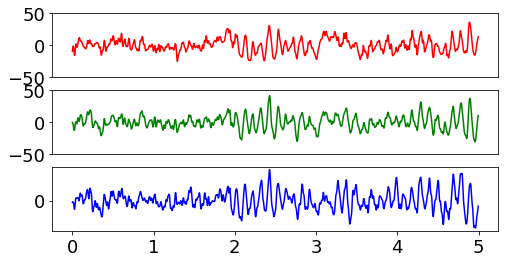

In [14]:
raw = read_raw_edf(os.path.join(path,'H S10 EC.edf'),preload=True)
preprocess_raw(raw)

gap = 3
data,times = raw[:,gap*256:gap*256+5*256] #取3个channel先看一下
data = np.clip(np.array(data)*1e6,-50,50)
plt.figure(figsize=(8, 4))
plt.subplot(311)
plt.plot(times-gap,data[0,:].T,color='r')
plt.xticks([])
plt.yticks([-50,0,50],fontsize=18)


plt.subplot(312)
plt.plot(times-gap,data[1,:].T,color='g')
plt.xticks([])
plt.yticks([-50,0,50],fontsize=18)


plt.subplot(313)
plt.xticks(fontsize=18)
plt.yticks([-50,0,50],fontsize=18)
plt.plot(times-gap,data[2,:].T,color='b')
#plt.title("Sample channels")
plt.show()

In [57]:
def diffuse_ICA(raw):
    raw_1 = raw.copy()
    ica_1 = ICA(n_components=19,random_state=97)
    ica_1.fit(raw_1)
    ica_1.plot_components()
    ica_1.plot_sources(raw_1)
    ica_2 = ica_1.copy()
    ica_1.exclude = [0,1]
    ica_2.exclude = [i for i in range(2,19)]
    raw_11 = raw_1.copy()
    raw_12 = raw_1.copy()
    ica_1.apply(raw_11)
    ica_2.apply(raw_12)
    return raw_11[:][0],raw_12[:][0]

Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 19 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 2 ICA components
    Projecting back using 19 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 17 ICA components
    Projecting back using 19 PCA components


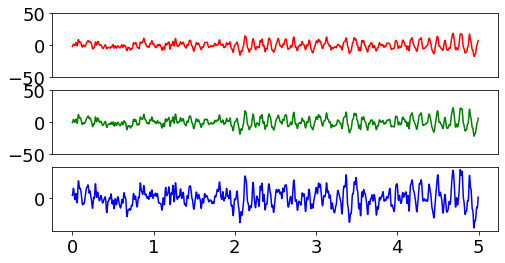

In [15]:
t, tt = diffuse_ICA(raw)

gap = 3
data = tt[:,gap*256:gap*256+5*256] #取3个channel先看一下
data = np.clip(np.array(data)*1e6,-50,50)
plt.figure(figsize=(8, 4))
plt.subplot(311)
plt.plot(times-gap,data[0,:].T,color='r')
plt.xticks([])
plt.yticks([-50,0,50],fontsize=18)


plt.subplot(312)
plt.plot(times-gap,data[1,:].T,color='g')
plt.xticks([])
plt.yticks([-50,0,50],fontsize=18)


plt.subplot(313)
plt.xticks(fontsize=18)
plt.yticks([-50,0,50],fontsize=18)
plt.plot(times-gap,data[2,:].T,color='b')
#plt.title("Sample channels")
plt.savefig('hc_noise.pdf')
plt.show()

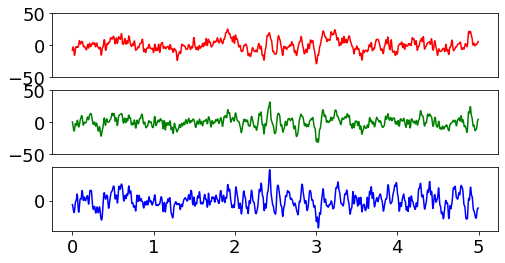

In [9]:
gap = 3
data = t[:,gap*256:gap*256+5*256] #取3个channel先看一下
data = np.clip(np.array(data)*1e6,-50,50)
plt.figure(figsize=(8, 4))
plt.subplot(311)
plt.plot(times-gap,data[0,:].T,color='r')
plt.xticks([])
plt.yticks([-50,0,50],fontsize=18)


plt.subplot(312)
plt.plot(times-gap,data[1,:].T,color='g')
plt.xticks([])
plt.yticks([-50,0,50],fontsize=18)


plt.subplot(313)
plt.xticks(fontsize=18)
plt.yticks([-50,0,50],fontsize=18)
plt.plot(times-gap,data[2,:].T,color='b')
#plt.title("Sample channels")
plt.savefig('hc_sig.pdf')
plt.show()

Extracting EDF parameters from /data0/violin/projects/mdd_practice/MDD_dataset/data/MDD S1 EO.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77055  =      0.000 ...   300.996 secs...


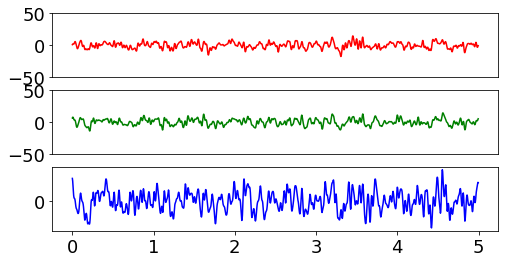

In [61]:
raw = read_raw_edf(os.path.join(path,'MDD S1 EO.edf'),preload=True)
preprocess_raw(raw)

gap = 3
data,times = raw[:,gap*256:gap*256+5*256] #取3个channel先看一下
data = np.clip(np.array(data)*1e6,-50,50)
plt.figure(figsize=(8, 4))
plt.subplot(311)
plt.plot(times-gap,data[0,:].T,color='r')
plt.xticks([])
plt.yticks([-50,0,50],fontsize=18)


plt.subplot(312)
plt.plot(times-gap,data[1,:].T,color='g')
plt.xticks([])
plt.yticks([-50,0,50],fontsize=18)


plt.subplot(313)
plt.xticks(fontsize=18)
plt.yticks([-50,0,50],fontsize=18)
plt.plot(times-gap,data[2,:].T,color='b')
#plt.title("Sample channels")
plt.show()

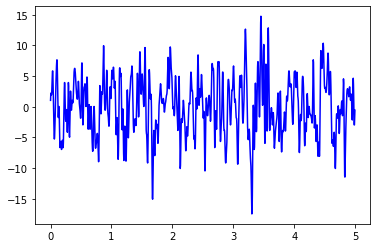

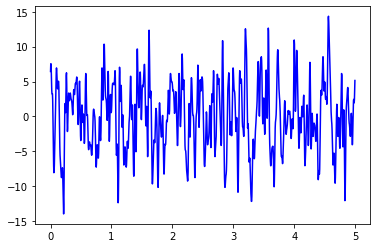

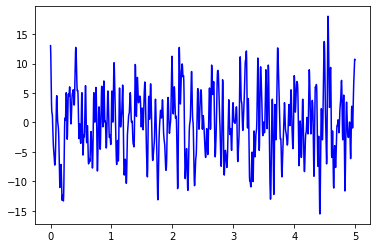

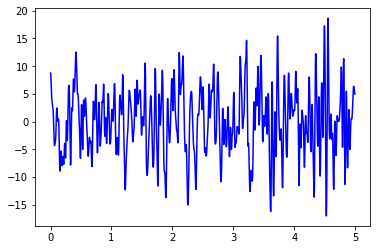

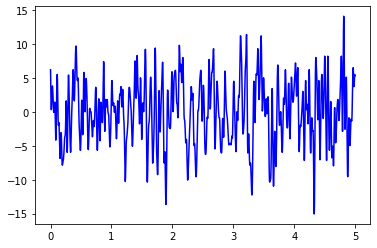

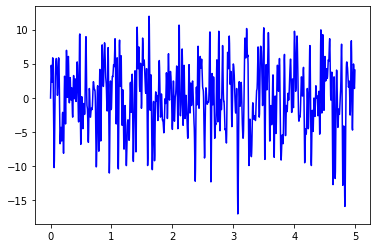

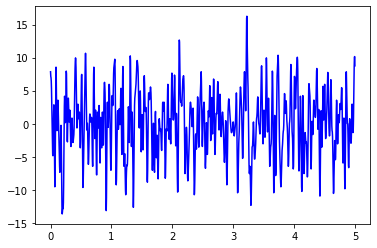

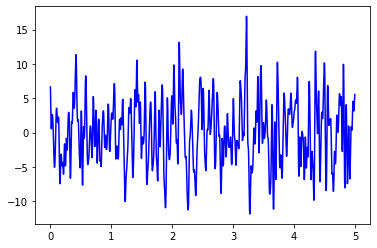

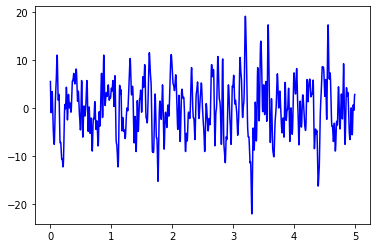

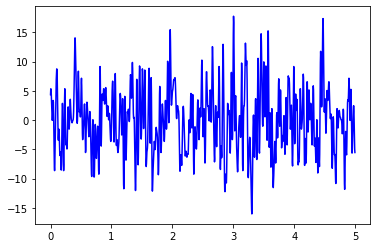

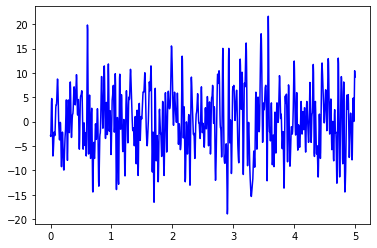

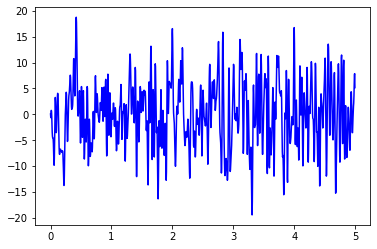

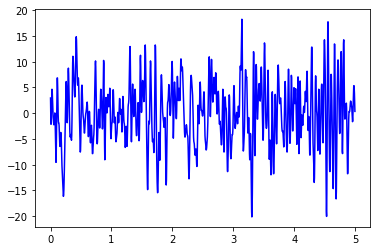

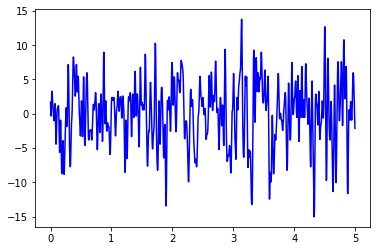

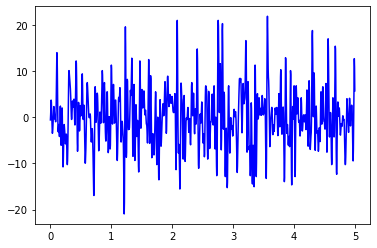

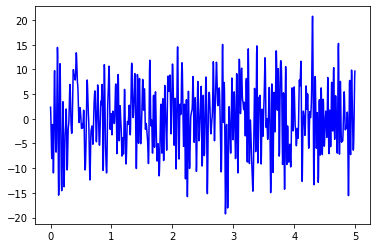

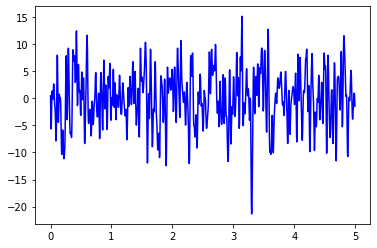

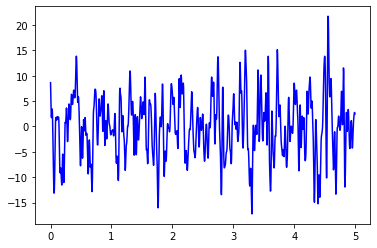

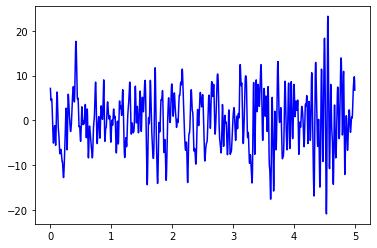

In [62]:
for i in range(19):
    plt.plot(times-gap,data[i,:].T,color='b')
    plt.show()

Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 19 components
Fitting ICA took 0.4s.


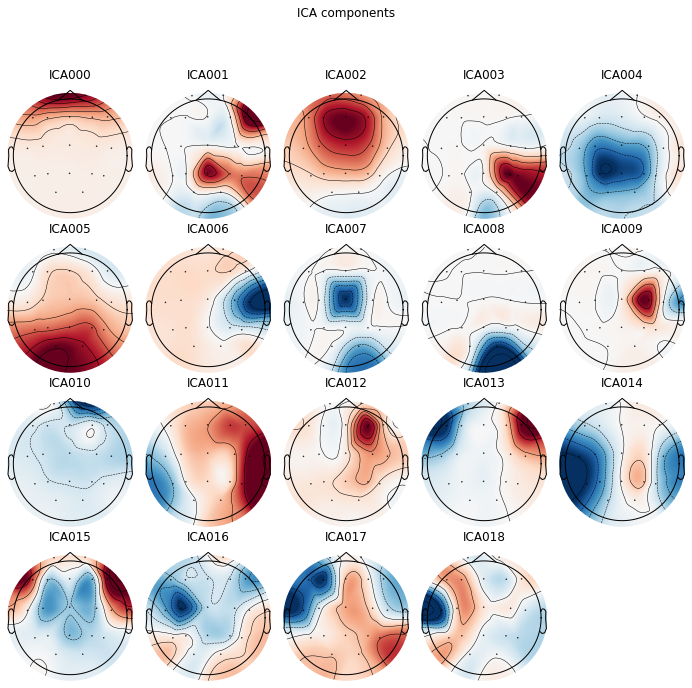

Creating RawArray with float64 data, n_channels=19, n_times=77056
    Range : 0 ... 77055 =      0.000 ...   300.996 secs
Ready.


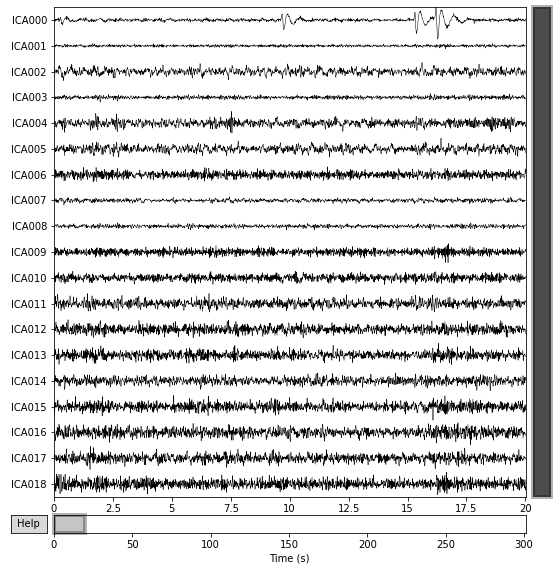

Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 2 ICA components
    Projecting back using 19 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 17 ICA components
    Projecting back using 19 PCA components


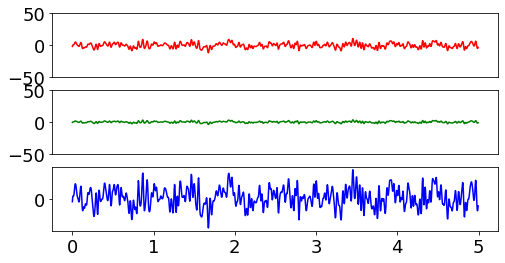

In [59]:
t, tt = diffuse_ICA(raw)

data = tt[:,gap*256:gap*256+5*256] #取3个channel先看一下
data = np.clip(np.array(data)*1e6,-50,50)
plt.figure(figsize=(8, 4))
plt.subplot(311)
plt.plot(times-gap,data[0,:].T,color='r')
plt.xticks([])
plt.yticks([-50,0,50],fontsize=18)


plt.subplot(312)
plt.plot(times-gap,data[1,:].T,color='g')
plt.xticks([])
plt.yticks([-50,0,50],fontsize=18)


plt.subplot(313)
plt.xticks(fontsize=18)
plt.yticks([-50,0,50],fontsize=18)
plt.plot(times-gap,data[2,:].T,color='b')
#plt.title("Sample channels")
plt.savefig('mdd_noise.pdf')
plt.show()

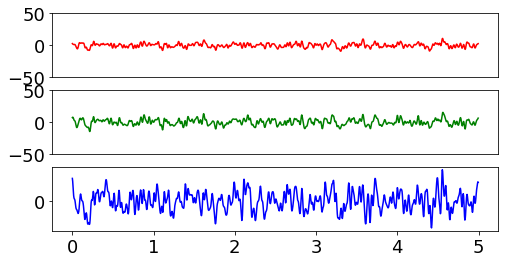

In [60]:
data = t[:,gap*256:gap*256+5*256] #取3个channel先看一下
data = np.clip(np.array(data)*1e6,-50,50)
plt.figure(figsize=(8, 4))
plt.subplot(311)
plt.plot(times-gap,data[0,:].T,color='r')
plt.xticks([])
plt.yticks([-50,0,50],fontsize=18)


plt.subplot(312)
plt.plot(times-gap,data[1,:].T,color='g')
plt.xticks([])
plt.yticks([-50,0,50],fontsize=18)


plt.subplot(313)
plt.xticks(fontsize=18)
plt.yticks([-50,0,50],fontsize=18)
plt.plot(times-gap,data[2,:].T,color='b')
#plt.title("Sample channels")
plt.savefig('mdd_sig.pdf')
plt.show()

## 2.2 新数据集

In [15]:
#path = '/data0/violin/projects/mdd_practice/MDD_dataset_lanzhou_2015'
path = '/data0/violin/projects/mdd_practice/MDD_dataset_new/data'
files = os.listdir(path)
idx_file = pd.read_excel(os.path.join(path,"Data_4_Import_REST.xlsx"))
# idx_dict = {} #subject id与下标映射的字典
# for idx,row in idx_file.iterrows():
#     idx_dict['0'+str(row['subject id'])] = idx
    
cnt = 0
for file in files:
    # if file.split(".")[-1]=='mat':
    if file.split(".")[-1]=='txt':
        cnt += 1
        print(file)
        t = np.loadtxt(os.path.join(path,file))
        print(len(t))
print(cnt)


541_Depression_REST.txt
66
549_Depression_REST.txt
66
617_Depression_REST.txt
67
574_Depression_REST.txt
66
560_Depression_REST.txt
67
524_Depression_REST.txt
67
599_Depression_REST.txt
67
586_Depression_REST.txt
67
526_Depression_REST.txt
66
564_Depression_REST.txt
67
622_Depression_REST.txt
66
523_Depression_REST.txt
67
620_Depression_REST.txt
67
590_Depression_REST.txt
67
547_Depression_REST.txt
66
568_Depression_REST.txt
67
598_Depression_REST.txt
66
548_Depression_REST.txt
66
578_Depression_REST.txt
67
614_Depression_REST.txt
67
515_Depression_REST.txt
66
610_Depression_REST.txt
66
593_Depression_REST.txt
67
520_Depression_REST.txt
67
563_Depression_REST.txt
67
588_Depression_REST.txt
67
550_Depression_REST.txt
66
573_Depression_REST.txt
66
519_Depression_REST.txt
67
513_Depression_REST.txt
66
587_Depression_REST.txt
67
516_Depression_REST.txt
66
575_Depression_REST.txt
67
557_Depression_REST.txt
67
521_Depression_REST.txt
66
525_Depression_REST.txt
66
532_Depression_REST.txt
67
6

In [14]:
path = '/data0/violin/projects/mdd_practice/MDD_dataset_new/data'
data = np.loadtxt(os.path.join(path,'507_Depression_REST.txt')) #hc 1 
#data = np.loadtxt(os.path.join(path,'558_Depression_REST.txt')) #mdd 1 
data = data[:64,:]
#采样频率
sfreq = 256 # Hz
#组成info
ch_names = ['E'+str(i) for i in range(1,65)]
#电极类型源代码可找支持的数据
ch_types = ['eeg']*64
info = mne.create_info(ch_names, sfreq, ch_types)
#组成原始数据
raw = mne.io.RawArray(data, info)
#必须要带通滤波 去除基线偏移
raw.filter(1.0,40.0)
# #上采样 使得两个数据集频率一致
# raw.resample(256)
 
#电极位置信息
#raw.set_montage('standard_1020',on_missing = 'warn')
#raw.set_eeg_reference(ref_channels='REST') # 使用REST参考 报错了
#raw.set_eeg_reference()


Creating RawArray with float64 data, n_channels=64, n_times=99568
    Range : 0 ... 99567 =      0.000 ...   388.934 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


<RawArray | 64 x 99568 (388.9 s), ~48.7 MB, data loaded>

In [39]:
#path = '/data0/violin/projects/mdd_practice/MDD_dataset_lanzhou_2015'
path = '/data0/violin/projects/mdd_practice/MDD_dataset_lanzhou_2015/MDD_dataset_lanzhou_2015_new'
files = os.listdir(path)
idx_file = pd.read_excel(os.path.join(path,"subjects_information_EEG_128channels_resting_lanzhou_2015.xlsx"))
idx_dict = {} #subject id与下标映射的字典
for idx,row in idx_file.iterrows():
    idx_dict['0'+str(row['subject id'])] = idx
    
cnt = 0
for file in files:
    # if file.split(".")[-1]=='mat':
    if file.split(".")[-1]=='txt':
        cnt += 1
        print(file)
        t = np.loadtxt(os.path.join(path,file))
        print(len(t))
print(cnt)


02010022restnew 20150724 14.txt
129
02010004rest 20150427 1335..txt
129
02010006rest 20150528 0928..txt
129
02030005rest 20151026 2103..txt
129
02020015_rest 20150630 1527.txt
129
02010030rest 20160324 1054..txt
129
02030004_rest 20151026 1930.txt
128
02030021rest 20160105 1141..txt
129
02010019rest 20150716 1440..txt
129
02010026rest 20160311 1421..txt
129
02030020_rest 20151230 1416.txt
129
02010036_rest 20160408 1418.txt
129
02010033rest 20160331 1239..txt
129
02020014_rest 20150630 1023.txt
129
02020008rest 20150624 1711..txt
129
02010005rest 20150507 0907..txt
128
02010023rest 20150729 1929..txt
129
02010028rest 20160317 1538..txt
128
02010012rest 20150626 1026..txt
129
02020027rest 20150713 1049..txt
129
02020025rest 20150713 1519..txt
129
02020013rest 20150629 1607..txt
129
02010024rest 20150814 1504..txt
129
02030007_rest 20151103 2032.txt
128
02020021rest 20150707 1720..txt
128
02020022rest 20150707 1452..txt
129
02010034rest 20160407 0938..txt
129
02030018_rest 20151208 1443.

In [99]:
#data = scio.loadmat(os.path.join(path,'02020023restnew 20150709 10.mat')) #hc 12
#data = scio.loadmat(os.path.join(path,'02010028rest 20160317 1538..mat')) #mdd 20
#data = np.loadtxt(os.path.join(path,'02020021rest 20150707 1720..txt')) #hc 10
data = np.loadtxt(os.path.join(path,'02010021 20150805 1730.txt')) #mdd 14

#采样频率
sfreq = 256 # Hz
#组成info
ch_names = ['E'+str(i) for i in range(1,129)]
ch_names.append('Cz')
#电极类型源代码可找支持的数据
ch_types = ['eeg']*129
info = mne.create_info(ch_names, sfreq, ch_types)
#组成原始数据
raw = mne.io.RawArray(data, info)
#必须要带通滤波 去除基线偏移
raw.filter(1.0,35.0)
# #上采样 使得两个数据集频率一致
# raw.resample(256)
 
#电极位置信息
raw.set_montage('standard_1020',on_missing = 'warn')
#raw.set_eeg_reference(ref_channels='REST') # 使用REST参考 报错了
#raw.set_eeg_reference()


Creating RawArray with float64 data, n_channels=129, n_times=76931
    Range : 0 ... 76930 =      0.000 ...   300.508 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 129 out of 129 | elapsed:    0.2s finished


<RawArray | 129 x 76931 (300.5 s), ~75.8 MB, data loaded>

In [3]:
#data = scio.loadmat(os.path.join(path,'02010028rest 20160317 1538..mat')) #mdd 20
#data = scio.loadmat(os.path.join(path,'02020023restnew 20150709 10.mat')) #hc 12
# data = scio.loadmat(os.path.join(path,'02020021rest 20150707 1720..mat')) #hc 10
data = scio.loadmat(os.path.join(path,'02010021 20150805 1730.mat.mat')) #mdd 14
# channels_idx = [21,23,35,51,69,32,44,57,10,8,123,103,91,82,121,107,95,128,61]
# data = data[list(data.keys())[3]][channels_idx]
# ch_names = ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
# #电极类型源代码可找支持的数据
# ch_types = ['eeg']*19
data = data[list(data.keys())[3]]
print(data)
#data = data['a02020027rest_20150713_1049mat'][:-1]
print(data) #128通道 记录的时间为5分钟左右

ch_names = ['E'+str(i) for i in range(1,129)]
ch_names.append('Cz')
#电极类型源代码可找支持的数据
ch_types = ['eeg']*129
#采样频率
sfreq = 250 # Hz
#组成info
info = mne.create_info(ch_names, sfreq, ch_types)
#组成原始数据
raw = mne.io.RawArray(data, info)
raw.crop(tmin=20,tmax=290)
#必须要带通滤波 去除基线偏移
raw.filter(1.0,40.0)
#上采样 使得两个数据集频率一致
raw.resample(256)
 
#电极位置信息
montage = mne.channels.make_standard_montage("GSN-HydroCel-128")
raw.set_montage(montage,on_missing='ignore')
#raw.set_eeg_reference(ref_channels='REST') # 使用REST参考 报错了
raw.set_eeg_reference()

[[-12180.98242188 -11988.82519531 -12193.86816406 ... -12303.1640625
  -12732.15429688 -12975.65527344]
 [ -9370.31640625  -9160.03027344  -9448.62304688 ...  -8622.05761719
   -9133.4921875   -9388.52441406]
 [-16733.953125   -16516.2734375  -16960.94335938 ... -17150.62109375
  -17834.42578125 -18108.5234375 ]
 ...
 [-15608.59765625 -15503.26171875 -15642.18554688 ... -16796.37109375
  -17145.921875   -17319.015625  ]
 [-12138.74511719 -11970.953125   -12146.16210938 ... -10133.03710938
  -10453.44238281 -10652.57128906]
 [     0.              0.              0.         ...      0.
       0.              0.        ]]
[[-12180.98242188 -11988.82519531 -12193.86816406 ... -12303.1640625
  -12732.15429688 -12975.65527344]
 [ -9370.31640625  -9160.03027344  -9448.62304688 ...  -8622.05761719
   -9133.4921875   -9388.52441406]
 [-16733.953125   -16516.2734375  -16960.94335938 ... -17150.62109375
  -17834.42578125 -18108.5234375 ]
 ...
 [-15608.59765625 -15503.26171875 -15642.18554688 ... 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 129 out of 129 | elapsed:    0.2s finished


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


<RawArray | 129 x 69121 (270.0 s), ~68.2 MB, data loaded>

Using matplotlib as 2D backend.


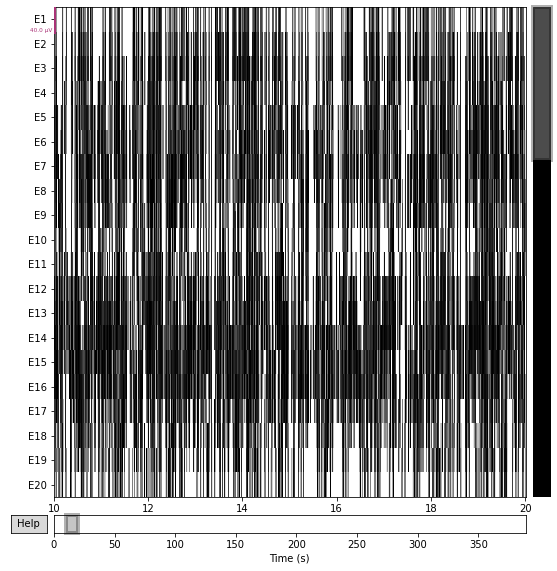

In [5]:
raw.plot(start=10)
plt.show()

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 1.000 (s)


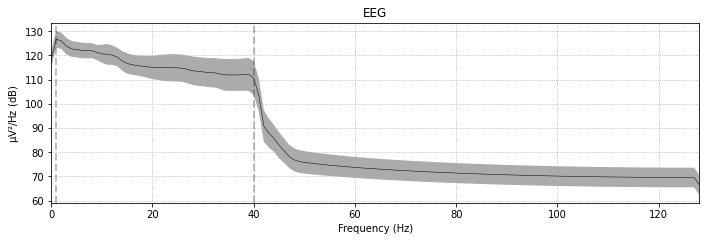

In [6]:
raw.plot_psd(average=True)
plt.show()

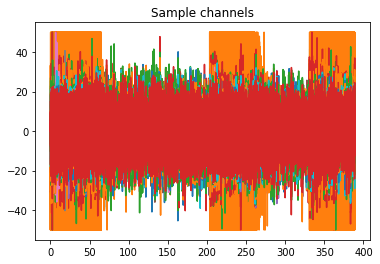

In [15]:
data,times=raw[:,:] #取3个channel先看一下
data = np.clip(data, -50, 50)
plt.plot(times,data[:,:].T)
plt.title("Sample channels")
plt.show()

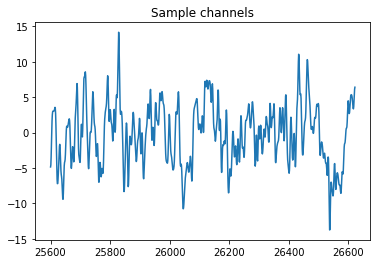

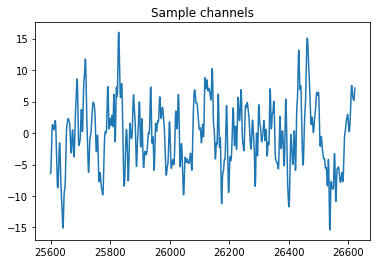

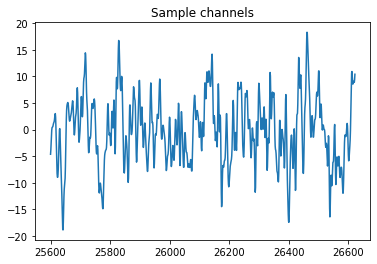

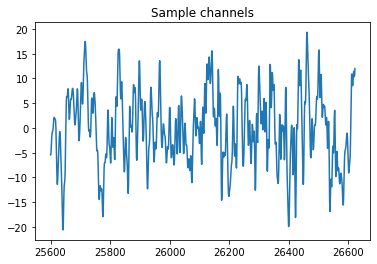

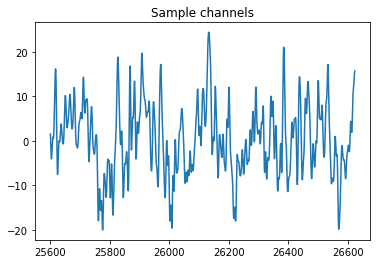

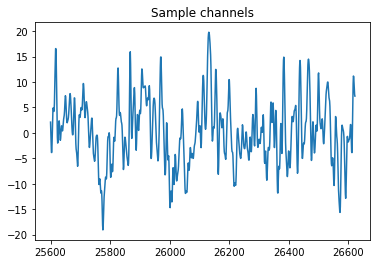

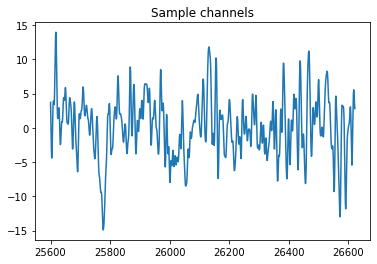

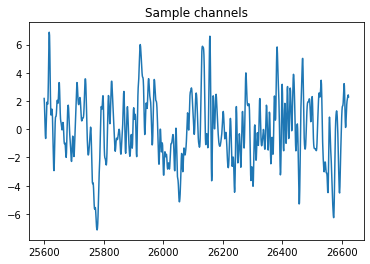

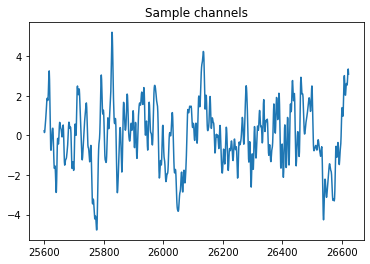

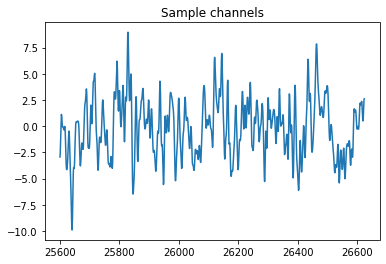

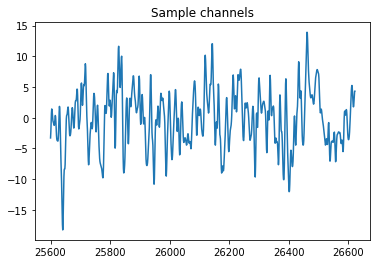

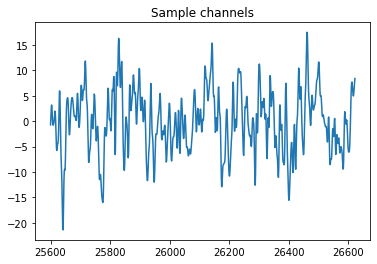

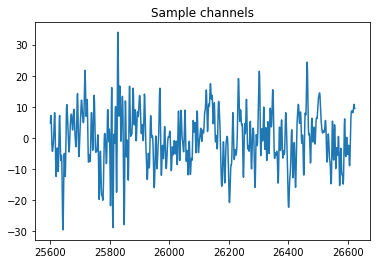

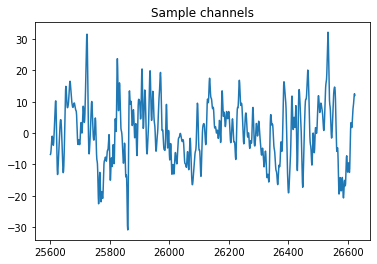

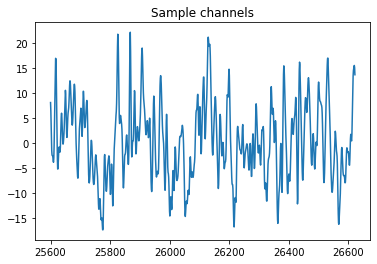

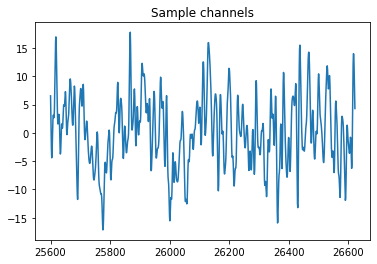

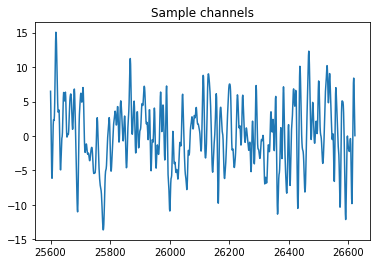

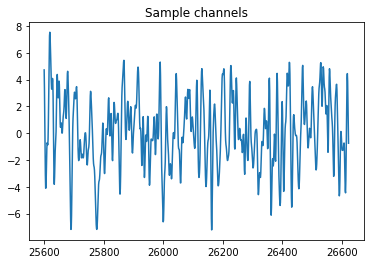

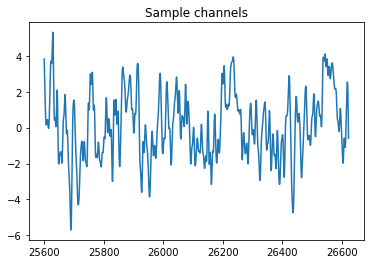

In [16]:
#特别关注一下Cz电极的情况
for i in range(19,38):
    plt.plot(np.arange(256*100,256*100+256*4),data[i,256*100:256*100+256*4].T)
    plt.title("Sample channels")
    plt.show()

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 50 components
Fitting ICA took 2.5s.
Creating RawArray with float64 data, n_channels=50, n_times=99568
    Range : 0 ... 99567 =      0.000 ...   388.934 secs
Ready.


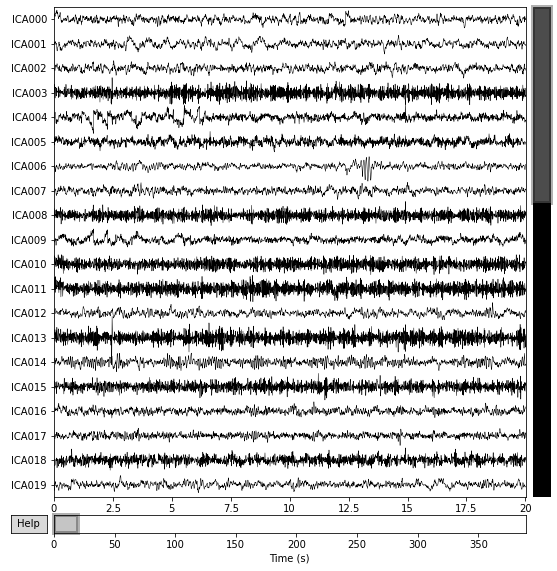

Applying ICA to Raw instance
    Transforming to ICA space (50 components)
    Zeroing out 5 ICA components
    Projecting back using 64 PCA components


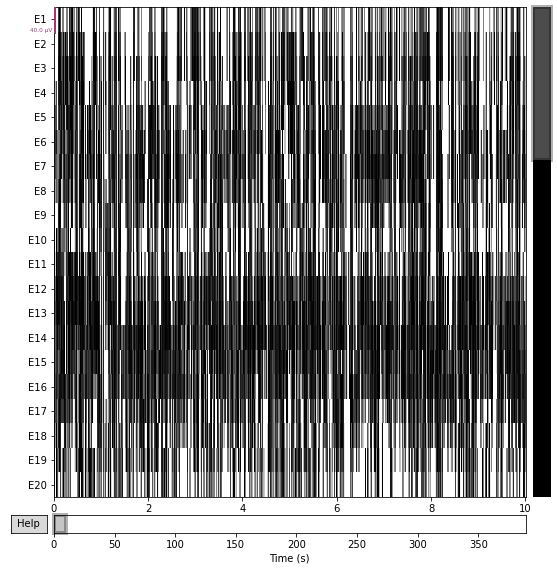

In [21]:
# ICA看一下情况 但还是决定先不做ICA了吧
raw_copy = raw.copy()
ica = ICA(n_components=50,random_state=97)
ica.fit(raw_copy)
ica.plot_sources(raw_copy)
# ica.plot_components()

ica.exclude = [i for i in range(5)]
ica.apply(raw_copy)
raw_copy.plot()
plt.show()


In [16]:
# raw_copy = raw.copy()
# data,times=raw_copy[:,:] #取3个channel先看一下
# transformer = FastICA(n_components=19,random_state=97)
# data = transformer.fit_transform(data)
# data = np.clip(data, -50, 50)
# for i in range(19):
#     plt.plot(np.arange(256*100,256*100+256*4),data[i,256*100:256*100+256*4].T)
#     plt.title("Sample channels")
#     plt.show()

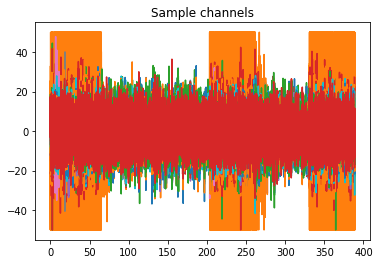

In [22]:
data,times=raw_copy[:,:] #取3个channel先看一下
data = np.clip(data, -50, 50)
plt.plot(times,data[:,:].T)
plt.title("Sample channels")
plt.show()

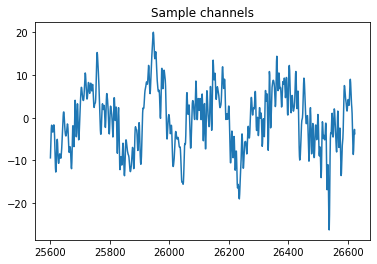

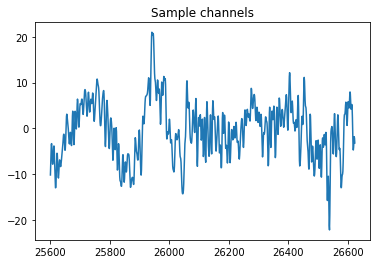

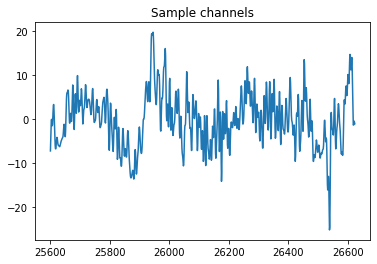

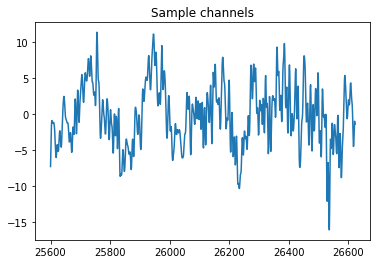

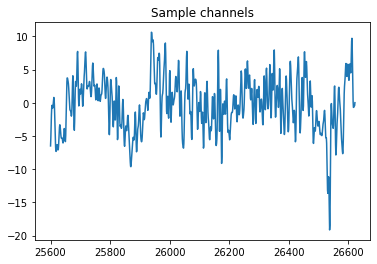

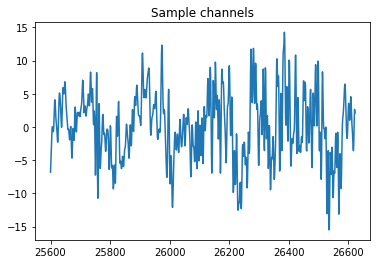

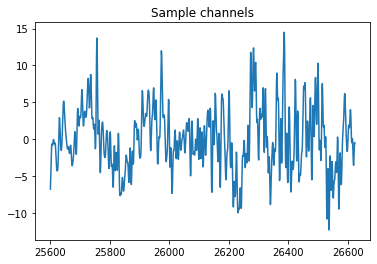

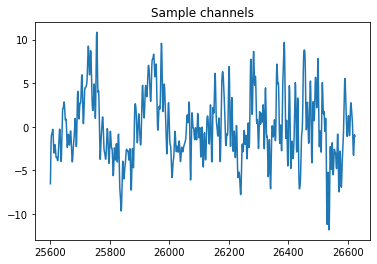

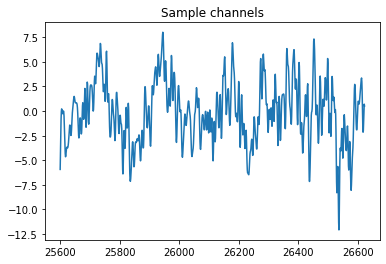

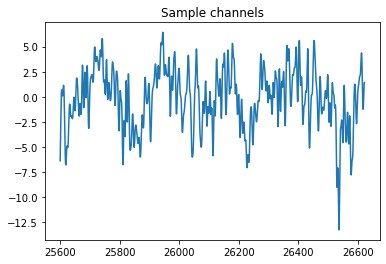

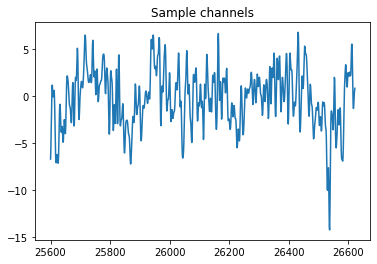

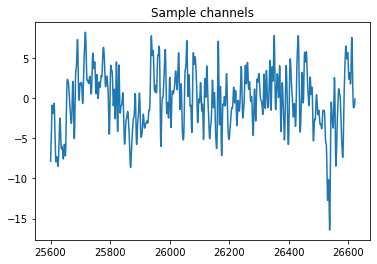

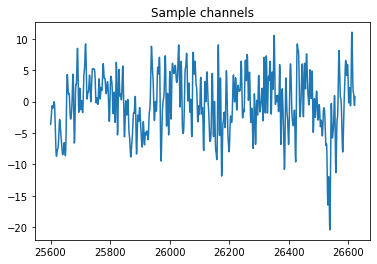

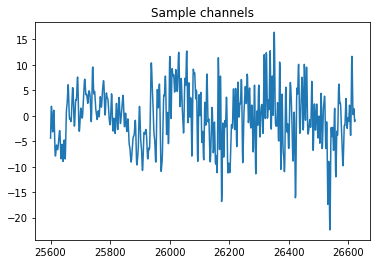

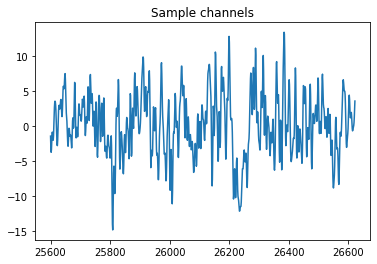

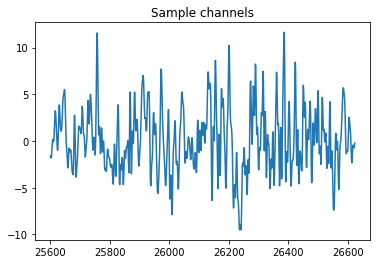

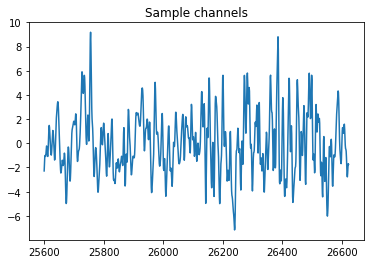

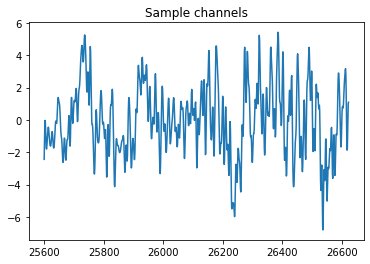

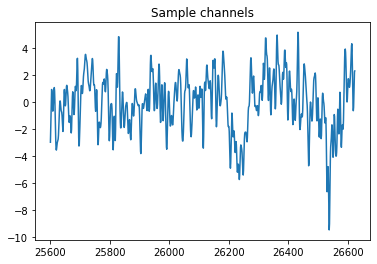

In [20]:
#特别关注一下Cz电极的情况
for i in range(19):
    plt.plot(np.arange(256*100,256*100+256*4),data[i,256*100:256*100+256*4].T)
    plt.title("Sample channels")
    plt.show()

In [ ]:
#原19通道顺序：
#['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 
#'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
#对应到129通道的索引：
#[21,23,35,51,69,32,44,57,10,8,123,103,91,82,121,107,95,128,61]

In [109]:
# def preprocess_raw_new(file_path):
#     data = scio.loadmat(file_path)
#     data = data[list(data.keys())[3]]
#     #data = data['a02020027rest_20150713_1049mat'][:-1]
#     # print(data) #128通道 记录的时间为5分钟左右

#     ch_names = ['E'+str(i) for i in range(1,129)]
#     ch_names.append('Cz')
#     #电极类型源代码可找支持的数据
#     ch_types = ['eeg']*129
#     #采样频率
#     sfreq = 250 # Hz
#     #组成info
#     info = mne.create_info(ch_names, sfreq, ch_types)
#     #组成原始数据
#     raw = mne.io.RawArray(data, info)
#     #必须要带通滤波 去除基线偏移
#     raw.filter(1.0,40.0)
#     #上采样 使得两个数据集频率一致
#     raw.resample(256)
    
#     #电极位置信息
#     montage = mne.channels.make_standard_montage("GSN-HydroCel-128")
#     raw.set_montage(montage,on_missing='ignore')
#     return raw

# def preprocess_raw_new(file_path):
#     data = np.loadtxt(file_path)
#     #data = data[list(data.keys())[3]]
#     #data = data['a02020027rest_20150713_1049mat'][:-1]
#     # print(data) #128通道 记录的时间为5分钟左右
#     if len(data)<129:
#         print(file_path)
#         cnt = 129-len(data)
#         for j in range(cnt):
#             data = np.append(data,np.array([[0.0]*len(data[0])]),axis=0)
#     ch_names = ['E'+str(i) for i in range(1,129)]
#     ch_names.append('Cz')
#     #电极类型源代码可找支持的数据
#     ch_types = ['eeg']*129
#     #采样频率
#     sfreq = 256 # Hz
#     #组成info
#     info = mne.create_info(ch_names, sfreq, ch_types)
#     #组成原始数据
#     raw = mne.io.RawArray(data, info)
#     #必须要带通滤波 去除基线偏移
#     raw.filter(1.0,35.0)
#     # #上采样 使得两个数据集频率一致
#     # raw.resample(256)
    
#     #电极位置信息
#     montage = mne.channels.make_standard_montage("GSN-HydroCel-128")
#     raw.set_montage(montage,on_missing='ignore')

#     ica = ICA(n_components=50,random_state=97)
#     ica.fit(raw)  
#     ica.exclude = [i for i in range(10)]
#     ica.apply(raw)
#     return raw


In [2]:
def preprocess_raw_new(file_path):
    data = np.loadtxt(file_path)
    data = data[:64,:]
    #data = data['a02020027rest_20150713_1049mat'][:-1]
    # print(data) #128通道 记录的时间为5分钟左右

    ch_names = ['E'+str(i) for i in range(1,65)]
    #电极类型源代码可找支持的数据
    ch_types = ['eeg']*64
    #采样频率
    sfreq = 256 # Hz
    #组成info
    info = mne.create_info(ch_names, sfreq, ch_types)
    #组成原始数据
    raw = mne.io.RawArray(data, info)
    #必须要带通滤波 去除基线偏移
    raw.filter(1.0,40.0)
    #上采样 使得两个数据集频率一致
    # raw.resample(256)
    
    #电极位置信息
    # montage = mne.channels.make_standard_montage("GSN-HydroCel-128")
    # raw.set_montage(montage,on_missing='ignore')
    return raw

In [4]:
#连续小波变换 可以选择只保留时频域的 或者保留时域+时频域的
def cwt(raw):
    sampling_rate = 256
    wavename = 'cgau8'
    totalscal = 4
    # 中心频率
    fc = pywt.central_frequency(wavename)
    # 计算对应频率的小波尺度
    cparam = 8 * fc * totalscal  #这里本来是2
    scales = cparam / np.arange(totalscal, 0, -0.5) #这里本来是-1
    data = raw
    raw_tf = []
    #组织格式应该是np.array 然后19channels*times*8components
    for i in range(19):
        [cwtmatr, frequencies] = pywt.cwt(data[i], scales, wavename, 1.0 / sampling_rate)
        cwtmatr = np.transpose(np.array(abs(cwtmatr)))
        raw_tf.append(np.concatenate([np.expand_dims(data[i],axis=1),cwtmatr],axis=1)) #19channels*times*(1+8)components
        #raw_tf.append(cwtmatr)
    raw_tf = np.array(raw_tf)
    #print(raw_tf.shape)
    return raw_tf
    

In [3]:
#快速傅里叶频域变换 针对每个样本来做...!
def fft_fc(data):
    raw_tf = []
    #组织格式应该是np.array 然后19channels*freqs
    for i in range(len(data)):
        yf = fft(data[i])
        N = len(data[i])
        y = np.abs(yf[0:N//2])*2.0/N
        raw_tf.append(y)
    raw_tf = np.array(raw_tf)
    #print(raw_ 
    # tf.shape)
    return raw_tf

In [4]:
#十折交叉验证 每次选HC(29)和MDD(24)各三个进验证集 其余是训练集
#暂定只用静息态的数据
#每次都这样一遍太麻烦了 先给每个受试者的样本存下来吧

#简洁一些的写法：用dict

#path = '/data0/violin/projects/mdd_practice/MDD_dataset_lanzhou_2015/MDD_dataset_lanzhou_2015_new'
path = '/data0/violin/projects/mdd_practice/MDD_dataset_new/data'

#pre_path = '/data0/violin/projects/mdd_practice/MDD_dataset_lanzhou_2015/data_rest_raw'
files = os.listdir(path)
idx_file = pd.read_excel(os.path.join(path,"Data_4_Import_REST.xlsx"))
# idx_file = pd.read_excel(os.path.join(path,"subjects_information_EEG_128channels_resting_lanzhou_2015.xlsx"))
# idx_dict = {} #subject id与下标映射的字典
# for idx,row in idx_file.iterrows():
#     idx_dict['0'+str(row['subject id'])] = idx

sfreq = 256
frame_length = 5
step = 2.5


def load_dataset_new(hc_list,mdd_list,pre_path,preload=False,tf_fc=None):
    samples_list = []
    label_list = []
    if preload == True: #已经处理好了 直接加载受试者的样本就好
        for i in hc_list:
            data_path = os.path.join(pre_path,"REST HC "+str(i)+".npy")
            samples = np.load(data_path)
            samples_list.append(samples)
            label_list = label_list + ([0]*len(samples))

        for i in mdd_list:
            data_path = os.path.join(pre_path,"REST MDD "+str(i)+".npy")
            samples = np.load(data_path)
            samples_list.append(samples)
            label_list = label_list + ([1]*len(samples))

    else:   #需要从头处理 注意list和np.array的转换 其实就不需要hc——list和mdd——list了
        # for file in files:
        #     names = file.split()
        #     #if not (".mat" in names[-1]):
        #     if not (".txt" in names[-1]):
        #         continue
        #     sub_id = names[0][:8]
        #     idx = idx_dict[sub_id]
        #     raw = preprocess_raw_new(os.path.join(path,file))
        #     #data,_ = raw[:,:]
        #     data,_ = raw[:,10*sfreq:-10*sfreq]
        #     data = np.clip(data, -50, 50)
        #     # if tf_fc is not None:
        #     #     data = tf_fc(data)
        #     #print(data.shape)
        #     samples = []
        #     for i in np.arange(0,int(data.shape[1]-frame_length*sfreq),int(step*sfreq)):
        #         if tf_fc is not None:
        #             samples.append(fft_fc(data[:,i:i+int(frame_length*sfreq)]))
        #         else:
        #             samples.append(data[:,i:i+int(frame_length*sfreq)])
        #     samples = np.array(samples)
        #     samples_list.append(samples)

        #     if idx>=24:
        #         label_list = label_list + ([0]*len(samples))
        #         data_path = os.path.join(pre_path,"REST HC "+str(idx-23)+".npy")
        #     else:
        #         label_list = label_list + ([1]*len(samples))
        #         data_path = os.path.join(pre_path,"REST MDD "+str(idx+1)+".npy")
            
        #     if os.path.exists(data_path): #如果已经有文件 则追加存储
        #         samples_part = np.load(data_path)
        #         samples =  np.concatenate((samples,samples_part), axis=0)

        #     np.save(data_path,samples)

        hc_cnt = 0
        mdd_cnt = 0
        for file in files:
            names = file.split("_")
            #if not (".mat" in names[-1]):
            if not (".txt" in names[-1]):
                continue
            sub_id = (int)(names[0])-507
            # idx = idx_dict[sub_id]
            raw = preprocess_raw_new(os.path.join(path,file))
            data,_ = raw[:,:]
            #data,_ = raw[:,10*sfreq:-10*sfreq]
            data = np.clip(data, -50, 50)
            # if tf_fc is not None:
            #     data = tf_fc(data)
            #print(data.shape)
            samples = []
            for i in np.arange(0,int(data.shape[1]-frame_length*sfreq),int(step*sfreq)):
                if tf_fc is not None:
                    samples.append(fft_fc(data[:,i:i+int(frame_length*sfreq)]))
                else:
                    samples.append(data[:,i:i+int(frame_length*sfreq)])
            samples = np.array(samples)
            samples_list.append(samples)

            if idx_file['BDI'].iloc[sub_id]<1.0:
                label_list = label_list + ([0]*len(samples))
                data_path = os.path.join(pre_path,"REST HC "+str(hc_cnt+1)+".npy")
                hc_cnt += 1
            elif idx_file['MDD'].iloc[sub_id]<=2.0:
                label_list = label_list + ([1]*len(samples))
                data_path = os.path.join(pre_path,"REST MDD "+str(mdd_cnt+1)+".npy")
                mdd_cnt += 1
            
            if os.path.exists(data_path): #如果已经有文件 则追加存储
                samples_part = np.load(data_path)
                samples =  np.concatenate((samples,samples_part), axis=0)

            np.save(data_path,samples)

    if len(samples_list)==0:
        return None,None

    samples_array = samples_list[0]  #把样本逐list拼接到np array
    for i in range(1,len(samples_list)):
        samples_array = np.concatenate((samples_array,samples_list[i]),axis=0)
    # samples_array = np.array(samples_list)
    label_list = np.array(label_list)
    # print(samples_array.shape)
    # print(samples_array[0])
    #print(label_list.shape)
    return torch.tensor(samples_array, dtype=torch.double),torch.tensor(label_list, dtype=torch.long)



In [5]:
#保存好了所有的object数据 就再加载确认一下
pre_path_0 = '/data0/violin/projects/mdd_practice/MDD_dataset_new/data_rest_raw_fft_part'
hc_list = [i for i in range(1,30)]
mdd_list = [i for i in range(1,25)]
x,y = load_dataset_new(hc_list,mdd_list,pre_path_0,False,fft_fc)
print(x.shape,y.shape)


Creating RawArray with float64 data, n_channels=64, n_times=59222
    Range : 0 ... 59221 =      0.000 ...   231.332 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Creating RawArray with float64 data, n_channels=64, n_times=74586
    Range : 0 ... 74585 =      0.000 ...   291.348 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Creating RawArray with float64 data, n_channels=64, n_times=94040
    Range : 0 ... 94039 =      0.000 ...   367.340 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Creating RawArray with float64 data, n_channels=64, n_times=77652
    Range : 0 ... 77651 =      0.000 ...   303.324 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Creating RawArray with float64 data, n_channels=64, n_times=77274
    Range : 0 ... 77273 =      0.000 ...   301.848 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Creating RawArray with float64 data, n_channels=64, n_times=47819
    Range : 0 ... 47818 =      0.000 ...   186.789 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Creating RawArray with float64 data, n_channels=64, n_times=118198
    Range : 0 ... 118197 =      0.000 ...   461.707 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Creating RawArray with float64 data, n_channels=64, n_times=78816
    Range : 0 ... 78815 =      0.000 ...   307.871 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Creating RawArray with float64 data, n_channels=64, n_times=91872
    Range : 0 ... 91871 =      0.000 ...   358.871 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Creating RawArray with float64 data, n_channels=64, n_times=105680
    Range : 0 ... 105679 =      0.000 ...   412.809 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Creating RawArray with float64 data, n_channels=64, n_times=80611
    Range : 0 ... 80610 =      0.000 ...   314.883 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Creating RawArray with float64 data, n_channels=64, n_times=82642
    Range : 0 ... 82641 =      0.000 ...   322.816 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Creating RawArray with float64 data, n_channels=64, n_times=57669
    Range : 0 ... 57668 =      0.000 ...   225.266 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Creating RawArray with float64 data, n_channels=64, n_times=113680
    Range : 0 ... 113679 =      0.000 ...   444.059 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Creating RawArray with float64 data, n_channels=64, n_times=96686
    Range : 0 ... 96685 =      0.000 ...   377.676 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Creating RawArray with float64 data, n_channels=64, n_times=98504
    Range : 0 ... 98503 =      0.000 ...   384.777 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Creating RawArray with float64 data, n_channels=64, n_times=59187
    Range : 0 ... 59186 =      0.000 ...   231.195 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Creating RawArray with float64 data, n_channels=64, n_times=62033
    Range : 0 ... 62032 =      0.000 ...   242.312 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Creating RawArray with float64 data, n_channels=64, n_times=104133
    Range : 0 ... 104132 =      0.000 ...   406.766 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Creating RawArray with float64 data, n_channels=64, n_times=121211
    Range : 0 ... 121210 =      0.000 ...   473.477 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Creating RawArray with float64 data, n_channels=64, n_times=106119
    Range : 0 ... 106118 =      0.000 ...   414.523 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Creating RawArray with float64 data, n_channels=64, n_times=104191
    Range : 0 ... 104190 =      0.000 ...   406.992 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Creating RawArray with float64 data, n_channels=64, n_times=105468
    Range : 0 ... 105467 =      0.000 ...   411.980 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Creating RawArray with float64 data, n_channels=64, n_times=80081
    Range : 0 ... 80080 =      0.000 ...   312.812 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Creating RawArray with float64 data, n_channels=64, n_times=43114
    Range : 0 ... 43113 =      0.000 ...   168.410 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Creating RawArray with float64 data, n_channels=64, n_times=99507
    Range : 0 ... 99506 =      0.000 ...   388.695 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Creating RawArray with float64 data, n_channels=64, n_times=93519
    Range : 0 ... 93518 =      0.000 ...   365.305 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Creating RawArray with float64 data, n_channels=64, n_times=59092
    Range : 0 ... 59091 =      0.000 ...   230.824 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Creating RawArray with float64 data, n_channels=64, n_times=95905
    Range : 0 ... 95904 =      0.000 ...   374.625 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Creating RawArray with float64 data, n_channels=64, n_times=63461
    Range : 0 ... 63460 =      0.000 ...   247.891 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Creating RawArray with float64 data, n_channels=64, n_times=58467
    Range : 0 ... 58466 =      0.000 ...   228.383 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Creating RawArray with float64 data, n_channels=64, n_times=67353
    Range : 0 ... 67352 =      0.000 ...   263.094 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Creating RawArray with float64 data, n_channels=64, n_times=105267
    Range : 0 ... 105266 =      0.000 ...   411.195 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Creating RawArray with float64 data, n_channels=64, n_times=78703
    Range : 0 ... 78702 =      0.000 ...   307.430 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Creating RawArray with float64 data, n_channels=64, n_times=79228
    Range : 0 ... 79227 =      0.000 ...   309.480 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Creating RawArray with float64 data, n_channels=64, n_times=48876
    Range : 0 ... 48875 =      0.000 ...   190.918 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Creating RawArray with float64 data, n_channels=64, n_times=50362
    Range : 0 ... 50361 =      0.000 ...   196.723 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Creating RawArray with float64 data, n_channels=64, n_times=82967
    Range : 0 ... 82966 =      0.000 ...   324.086 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Creating RawArray with float64 data, n_channels=64, n_times=115920
    Range : 0 ... 115919 =      0.000 ...   452.809 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Creating RawArray with float64 data, n_channels=64, n_times=35897
    Range : 0 ... 35896 =      0.000 ...   140.219 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Creating RawArray with float64 data, n_channels=64, n_times=96217
    Range : 0 ... 96216 =      0.000 ...   375.844 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Creating RawArray with float64 data, n_channels=64, n_times=109023
    Range : 0 ... 109022 =      0.000 ...   425.867 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Creating RawArray with float64 data, n_channels=64, n_times=102532
    Range : 0 ... 102531 =      0.000 ...   400.512 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Creating RawArray with float64 data, n_channels=64, n_times=90356
    Range : 0 ... 90355 =      0.000 ...   352.949 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Creating RawArray with float64 data, n_channels=64, n_times=92535
    Range : 0 ... 92534 =      0.000 ...   361.461 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Creating RawArray with float64 data, n_channels=64, n_times=83818
    Range : 0 ... 83817 =      0.000 ...   327.410 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Creating RawArray with float64 data, n_channels=64, n_times=91762
    Range : 0 ... 91761 =      0.000 ...   358.441 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Creating RawArray with float64 data, n_channels=64, n_times=88369
    Range : 0 ... 88368 =      0.000 ...   345.188 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Creating RawArray with float64 data, n_channels=64, n_times=71486
    Range : 0 ... 71485 =      0.000 ...   279.238 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Creating RawArray with float64 data, n_channels=64, n_times=92785
    Range : 0 ... 92784 =      0.000 ...   362.438 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Creating RawArray with float64 data, n_channels=64, n_times=104364
    Range : 0 ... 104363 =      0.000 ...   407.668 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Creating RawArray with float64 data, n_channels=64, n_times=95664
    Range : 0 ... 95663 =      0.000 ...   373.684 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Creating RawArray with float64 data, n_channels=64, n_times=55098
    Range : 0 ... 55097 =      0.000 ...   215.223 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Creating RawArray with float64 data, n_channels=64, n_times=91324
    Range : 0 ... 91323 =      0.000 ...   356.730 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Creating RawArray with float64 data, n_channels=64, n_times=100075
    Range : 0 ... 100074 =      0.000 ...   390.914 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Creating RawArray with float64 data, n_channels=64, n_times=68904
    Range : 0 ... 68903 =      0.000 ...   269.152 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Creating RawArray with float64 data, n_channels=64, n_times=94176
    Range : 0 ... 94175 =      0.000 ...   367.871 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Creating RawArray with float64 data, n_channels=64, n_times=98021
    Range : 0 ... 98020 =      0.000 ...   382.891 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Creating RawArray with float64 data, n_channels=64, n_times=99568
    Range : 0 ... 99567 =      0.000 ...   388.934 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Creating RawArray with float64 data, n_channels=64, n_times=61247
    Range : 0 ... 61246 =      0.000 ...   239.242 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Creating RawArray with float64 data, n_channels=64, n_times=71155
    Range : 0 ... 71154 =      0.000 ...   277.945 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Creating RawArray with float64 data, n_channels=64, n_times=121718
    Range : 0 ... 121717 =      0.000 ...   475.457 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Creating RawArray with float64 data, n_channels=64, n_times=101733
    Range : 0 ... 101732 =      0.000 ...   397.391 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Creating RawArray with float64 data, n_channels=64, n_times=89921
    Range : 0 ... 89920 =      0.000 ...   351.250 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Creating RawArray with float64 data, n_channels=64, n_times=95324
    Range : 0 ... 95323 =      0.000 ...   372.355 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Creating RawArray with float64 data, n_channels=64, n_times=26583
    Range : 0 ... 26582 =      0.000 ...   103.836 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Creating RawArray with float64 data, n_channels=64, n_times=74415
    Range : 0 ... 74414 =      0.000 ...   290.680 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Creating RawArray with float64 data, n_channels=64, n_times=86083
    Range : 0 ... 86082 =      0.000 ...   336.258 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Creating RawArray with float64 data, n_channels=64, n_times=122896
    Range : 0 ... 122895 =      0.000 ...   480.059 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Creating RawArray with float64 data, n_channels=64, n_times=97829
    Range : 0 ... 97828 =      0.000 ...   382.141 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Creating RawArray with float64 data, n_channels=64, n_times=63191
    Range : 0 ... 63190 =      0.000 ...   246.836 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Creating RawArray with float64 data, n_channels=64, n_times=61290
    Range : 0 ... 61289 =      0.000 ...   239.410 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Creating RawArray with float64 data, n_channels=64, n_times=64500
    Range : 0 ... 64499 =      0.000 ...   251.949 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Creating RawArray with float64 data, n_channels=64, n_times=80469
    Range : 0 ... 80468 =      0.000 ...   314.328 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Creating RawArray with float64 data, n_channels=64, n_times=79545
    Range : 0 ... 79544 =      0.000 ...   310.719 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Creating RawArray with float64 data, n_channels=64, n_times=114165
    Range : 0 ... 114164 =      0.000 ...   445.953 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Creating RawArray with float64 data, n_channels=64, n_times=82259
    Range : 0 ... 82258 =      0.000 ...   321.320 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Creating RawArray with float64 data, n_channels=64, n_times=112773
    Range : 0 ... 112772 =      0.000 ...   440.516 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Creating RawArray with float64 data, n_channels=64, n_times=73135
    Range : 0 ... 73134 =      0.000 ...   285.680 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Creating RawArray with float64 data, n_channels=64, n_times=53570
    Range : 0 ... 53569 =      0.000 ...   209.254 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Creating RawArray with float64 data, n_channels=64, n_times=93849
    Range : 0 ... 93848 =      0.000 ...   366.594 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Creating RawArray with float64 data, n_channels=64, n_times=87102
    Range : 0 ... 87101 =      0.000 ...   340.238 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Creating RawArray with float64 data, n_channels=64, n_times=102850
    Range : 0 ... 102849 =      0.000 ...   401.754 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Creating RawArray with float64 data, n_channels=64, n_times=83394
    Range : 0 ... 83393 =      0.000 ...   325.754 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Creating RawArray with float64 data, n_channels=64, n_times=93843
    Range : 0 ... 93842 =      0.000 ...   366.570 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Creating RawArray with float64 data, n_channels=64, n_times=91655
    Range : 0 ... 91654 =      0.000 ...   358.023 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Creating RawArray with float64 data, n_channels=64, n_times=107327
    Range : 0 ... 107326 =      0.000 ...   419.242 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Creating RawArray with float64 data, n_channels=64, n_times=111092
    Range : 0 ... 111091 =      0.000 ...   433.949 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Creating RawArray with float64 data, n_channels=64, n_times=98178
    Range : 0 ... 98177 =      0.000 ...   383.504 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Creating RawArray with float64 data, n_channels=64, n_times=69905
    Range : 0 ... 69904 =      0.000 ...   273.062 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Creating RawArray with float64 data, n_channels=64, n_times=79805
    Range : 0 ... 79804 =      0.000 ...   311.734 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Creating RawArray with float64 data, n_channels=64, n_times=65781
    Range : 0 ... 65780 =      0.000 ...   256.953 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Creating RawArray with float64 data, n_channels=64, n_times=71914
    Range : 0 ... 71913 =      0.000 ...   280.910 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Creating RawArray with float64 data, n_channels=64, n_times=110836
    Range : 0 ... 110835 =      0.000 ...   432.949 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Creating RawArray with float64 data, n_channels=64, n_times=53769
    Range : 0 ... 53768 =      0.000 ...   210.031 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Creating RawArray with float64 data, n_channels=64, n_times=91197
    Range : 0 ... 91196 =      0.000 ...   356.234 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Creating RawArray with float64 data, n_channels=64, n_times=68366
    Range : 0 ... 68365 =      0.000 ...   267.051 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Creating RawArray with float64 data, n_channels=64, n_times=54358
    Range : 0 ... 54357 =      0.000 ...   212.332 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Creating RawArray with float64 data, n_channels=64, n_times=103110
    Range : 0 ... 103109 =      0.000 ...   402.770 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Creating RawArray with float64 data, n_channels=64, n_times=92798
    Range : 0 ... 92797 =      0.000 ...   362.488 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Creating RawArray with float64 data, n_channels=64, n_times=79765
    Range : 0 ... 79764 =      0.000 ...   311.578 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Creating RawArray with float64 data, n_channels=64, n_times=62927
    Range : 0 ... 62926 =      0.000 ...   245.805 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Creating RawArray with float64 data, n_channels=64, n_times=96792
    Range : 0 ... 96791 =      0.000 ...   378.090 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Creating RawArray with float64 data, n_channels=64, n_times=100771
    Range : 0 ... 100770 =      0.000 ...   393.633 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Creating RawArray with float64 data, n_channels=64, n_times=46633
    Range : 0 ... 46632 =      0.000 ...   182.156 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Creating RawArray with float64 data, n_channels=64, n_times=103134
    Range : 0 ... 103133 =      0.000 ...   402.863 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Creating RawArray with float64 data, n_channels=64, n_times=88827
    Range : 0 ... 88826 =      0.000 ...   346.977 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Creating RawArray with float64 data, n_channels=64, n_times=94428
    Range : 0 ... 94427 =      0.000 ...   368.855 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Creating RawArray with float64 data, n_channels=64, n_times=91485
    Range : 0 ... 91484 =      0.000 ...   357.359 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Creating RawArray with float64 data, n_channels=64, n_times=92199
    Range : 0 ... 92198 =      0.000 ...   360.148 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Creating RawArray with float64 data, n_channels=64, n_times=97375
    Range : 0 ... 97374 =      0.000 ...   380.367 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Creating RawArray with float64 data, n_channels=64, n_times=82650
    Range : 0 ... 82649 =      0.000 ...   322.848 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Creating RawArray with float64 data, n_channels=64, n_times=105106
    Range : 0 ... 105105 =      0.000 ...   410.566 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Creating RawArray with float64 data, n_channels=64, n_times=71914
    Range : 0 ... 71913 =      0.000 ...   280.910 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Creating RawArray with float64 data, n_channels=64, n_times=100174
    Range : 0 ... 100173 =      0.000 ...   391.301 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Creating RawArray with float64 data, n_channels=64, n_times=103398
    Range : 0 ... 103397 =      0.000 ...   403.895 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Creating RawArray with float64 data, n_channels=64, n_times=78363
    Range : 0 ... 78362 =      0.000 ...   306.102 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Creating RawArray with float64 data, n_channels=64, n_times=93325
    Range : 0 ... 93324 =      0.000 ...   364.547 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Creating RawArray with float64 data, n_channels=64, n_times=106020
    Range : 0 ... 106019 =      0.000 ...   414.137 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


torch.Size([15700, 64, 640]) torch.Size([5127])


In [6]:
#data转cv用的
hc_idxs = np.arange(1,20)  #75 hc
mdd_idxs = np.arange(1,23) #44 mdd
np.random.seed(0)
#np.random.seed(41)
np.random.shuffle(hc_idxs)
np.random.shuffle(mdd_idxs)

n_fold = 10
n_sub_1 = 2
n_sub_2 = 3


pre_path_train = '/data0/violin/projects/mdd_practice/MDD_dataset_new/data_rest_raw_fft_part'
pre_path_test = '/data0/violin/projects/mdd_practice/MDD_dataset_new/data_rest_raw_fft_part'


output_path = '/data0/violin/projects/mdd_practice/MDD_dataset_new/cv_rest_raw_fft_part'

i1 = 0
i2 = 0

for fold in range(n_fold):
    print("fold "+str(fold+1)+": ")
    if fold>=9:
        n_sub_1 = 1
    if fold>=2:
        n_sub_2 = 2
    hc_train_list,mdd_train_list,hc_test_list,mdd_test_list = [],[],[],[]
    for i in range(len(hc_idxs)):
        if i>=i1 and i<i1+n_sub_1:
            hc_test_list.append(hc_idxs[i])
        else:
            hc_train_list.append(hc_idxs[i])
    for i in range(len(mdd_idxs)):
        if i>=i2 and i<i2+n_sub_2:
            mdd_test_list.append(mdd_idxs[i])
        else:
            mdd_train_list.append(mdd_idxs[i])
    print(hc_test_list,mdd_test_list)

    train_x, train_y = load_dataset_new(hc_train_list,mdd_train_list,pre_path_train,True)
    test_x, test_y = load_dataset_new(hc_test_list,mdd_test_list,pre_path_test,True)
    torch.save(train_x,os.path.join(output_path,'CV_train_x_'+str(fold+1)+'.pth'))
    torch.save(train_y,os.path.join(output_path,'CV_train_y_'+str(fold+1)+'.pth'))
    torch.save(test_x,os.path.join(output_path,'CV_test_x_'+str(fold+1)+'.pth'))
    torch.save(test_y,os.path.join(output_path,'CV_test_y_'+str(fold+1)+'.pth'))

    i1 += n_sub_1
    i2 += n_sub_2

fold 1: 
[11, 2] [20, 21, 17]
fold 2: 
[9, 19] [22, 2, 16]
fold 3: 
[15, 17] [11, 3]
fold 4: 
[7, 5] [12, 19]
fold 5: 
[3, 6] [13, 1]
fold 6: 
[14, 10] [4, 5]
fold 7: 
[8, 18] [10, 9]
fold 8: 
[12, 4] [14, 6]
fold 9: 
[1, 16] [18, 15]
fold 10: 
[13] [8, 7]


# 3.数据增强-简单类

## 3.1 ICA分解交换

In [ ]:
## ICA分解与交换 直接构建个体！
def diffuse_ICA(raw):
    raw_1 = raw.copy()
    ica_1 = ICA(n_components=19,random_state=97)
    ica_1.fit(raw_1)
    ica_2 = ica_1.copy()
    ica_1.exclude = [0,1]
    ica_2.exclude = [i for i in range(2,19)]
    raw_11 = raw_1.copy()
    raw_12 = raw_1.copy()
    ica_1.apply(raw_11)
    ica_2.apply(raw_12)
    return raw_11[:][0],raw_12[:][0]

def exchange_ICA(raw_1,raw_2):
    raw_1a,raw_1b = diffuse_ICA(raw_1)
    raw_2a,raw_2b = diffuse_ICA(raw_2)
    l = min(len(raw_1a[0]),len(raw_2a[0]))
    return raw_1a[:,:l]+raw_2b[:,:l],raw_2a[:,:l]+raw_1b[:,:l]


In [ ]:
#数据增强(ICA)用的代码
path = '/data0/violin/projects/mdd_practice/MDD_dataset/data'
#pre_path = '/data0/violin/projects/mdd_practice/MDD_dataset/data_rest'
files = os.listdir(path)
sfreq = 256
frame_length = 5
step = 2.5

missing_ec_hc = [12,18]
missing_ec_mdd = [4,8,12,16]
missing_eo_hc = [25]
missing_eo_mdd = [7,8]

def augmentation_ICA(hc_list,mdd_list,fold,preprocess_fc,out_path,tf_fc=None):
    samples_list,label_list = [],[]
    p1 = 0
    p2 = 0
    n1 = len(hc_list)
    n2 = len(mdd_list)
    while p1<n1 and p2<n2:
        s1 = 'H S'+str(hc_list[p1])+' EC.edf'
        s2 = 'H S'+str(hc_list[p1])+' EO.edf'
        s3 = 'MDD S'+str(mdd_list[p2])+' EC.edf'
        s4 = 'MDD S'+str(mdd_list[p2])+' EO.edf'
        if s1 in files and s2 in files:
            raw_1 = read_raw_edf(os.path.join(path,s1),preload=True)
            raw_2 = read_raw_edf(os.path.join(path,s2),preload=True)
            preprocess_fc(raw_1)
            preprocess_fc(raw_2)
        else:
            p1 += 1
            continue
        if s3 in files and s4 in files:
            raw_3 = read_raw_edf(os.path.join(path,s3),preload=True)
            raw_4 = read_raw_edf(os.path.join(path,s4),preload=True)
            preprocess_fc(raw_3)
            preprocess_fc(raw_4)        
        else:
            p2 += 1
            continue
    #需要从头处理 注意list和np.array的转换
        p1 += 1
        p2 += 1
        raw_13,raw_31 = exchange_ICA(raw_1,raw_3)
        raw_24,raw_42 = exchange_ICA(raw_2,raw_4)
        if tf_fc is not None:
            raw_13 = tf_fc(raw_13)
            raw_31 = tf_fc(raw_31)
            raw_24 = tf_fc(raw_24)
            raw_42 = tf_fc(raw_42)
        for i in np.arange(0,int(raw_13.shape[1]-frame_length*sfreq),int(step*sfreq)):
            #samples.append(fft_fc(data[:,i:i+int(frame_length*sfreq)]))
            samples_list.append(raw_13[:,i:i+int(frame_length*sfreq)])
            samples_list.append(raw_31[:,i:i+int(frame_length*sfreq)])
            label_list.append(0)
            label_list.append(1)
        for i in np.arange(0,int(raw_24.shape[1]-frame_length*sfreq),int(step*sfreq)):
        #samples.append(fft_fc(data[:,i:i+int(frame_length*sfreq)]))
            samples_list.append(raw_24[:,i:i+int(frame_length*sfreq)])
            samples_list.append(raw_42[:,i:i+int(frame_length*sfreq)])
            label_list.append(0)
            label_list.append(1)

    samples_array = torch.tensor(np.array(samples_list), dtype=torch.double)
    label_array = torch.tensor(np.array(label_list), dtype=torch.double)
    print(samples_array.shape)
    # print(samples_array[0])
    print(label_array.shape)
    torch.save(samples_array,os.path.join(out_path,'CV_aug_x_fold_'+str(fold)+'.pth'))
    torch.save(label_array,os.path.join(out_path,'CV_aug_y_fold_'+str(fold)+'.pth'))




## 3.2 FFT+60HZ分解交换

In [ ]:
## FFT滤波的分解与交换 直接构建个体！
def diffuse_fft(raw):
    data,_ = raw[:]
    raw_a = []
    raw_b = []
    for i in range(19):
        W = fftfreq(len(data[i]), d=1.0/256)
        f_signal = rfft(data[i])
        cut_f_signal_a = f_signal.copy()
        cut_f_signal_b = f_signal.copy()
        cut_f_signal_a[(W>=60)] = 0
        cut_f_signal_b[(W<60)] = 0
        raw_a.append(irfft(cut_f_signal_a))
        raw_b.append(irfft(cut_f_signal_b))
        
    return np.array(raw_a),np.array(raw_b)


def exchange_fft(raw_1,raw_2):
    raw_1a,raw_1b = diffuse_fft(raw_1)
    raw_2a,raw_2b = diffuse_fft(raw_2)
    l = min(len(raw_1a[0]),len(raw_2a[0]))
    return raw_1a[:,:l]+raw_2b[:,:l],raw_2a[:,:l]+raw_1b[:,:l]

In [ ]:
#数据增强(60Hz以上成分交换)用的代码
path = '/data0/violin/projects/mdd_practice/MDD_dataset/data'
#pre_path = '/data0/violin/projects/mdd_practice/MDD_dataset/data_rest'
files = os.listdir(path)
sfreq = 256
frame_length = 5
step = 2.5

missing_ec_hc = [12,18]
missing_ec_mdd = [4,8,12,16]
missing_eo_hc = [25]
missing_eo_mdd = [7,8]

def augmentation_fft(hc_list,mdd_list,fold,preprocess_fc,out_path,tf_fc=None):
    samples_list,label_list = [],[]
    p1 = 0
    p2 = 0
    n1 = len(hc_list)
    n2 = len(mdd_list)
    while p1<n1 and p2<n2:
        s1 = 'H S'+str(hc_list[p1])+' EC.edf'
        s2 = 'H S'+str(hc_list[p1])+' EO.edf'
        s3 = 'MDD S'+str(mdd_list[p2])+' EC.edf'
        s4 = 'MDD S'+str(mdd_list[p2])+' EO.edf'
        if s1 in files and s2 in files:
            raw_1 = read_raw_edf(os.path.join(path,s1),preload=True)
            raw_2 = read_raw_edf(os.path.join(path,s2),preload=True)
            preprocess_fc(raw_1)
            preprocess_fc(raw_2)
        else:
            p1 += 1
            continue
        if s3 in files and s4 in files:
            raw_3 = read_raw_edf(os.path.join(path,s3),preload=True)
            raw_4 = read_raw_edf(os.path.join(path,s4),preload=True)
            preprocess_fc(raw_3)
            preprocess_fc(raw_4)        
        else:
            p2 += 1
            continue
    #需要从头处理 注意list和np.array的转换
        p1 += 1
        p2 += 1
        raw_13,raw_31 = exchange_fft(raw_1,raw_3)
        raw_24,raw_42 = exchange_fft(raw_2,raw_4)
        # if tf_fc is not None:
        #     raw_13 = tf_fc(raw_13)
        #     raw_31 = tf_fc(raw_31)
        #     raw_24 = tf_fc(raw_24)
        #     raw_42 = tf_fc(raw_42)
        for i in np.arange(0,int(raw_13.shape[1]-frame_length*sfreq),int(step*sfreq)):
            #samples.append(fft_fc(data[:,i:i+int(frame_length*sfreq)]))
            if tf_fc is None:
                samples_list.append(raw_13[:,i:i+int(frame_length*sfreq)])
                samples_list.append(raw_31[:,i:i+int(frame_length*sfreq)])
            else:
                samples_list.append(tf_fc(raw_13[:,i:i+int(frame_length*sfreq)]))
                samples_list.append(tf_fc(raw_31[:,i:i+int(frame_length*sfreq)]))
            label_list.append(0)
            label_list.append(1)
        for i in np.arange(0,int(raw_24.shape[1]-frame_length*sfreq),int(step*sfreq)):
        #samples.append(fft_fc(data[:,i:i+int(frame_length*sfreq)]))
            if tf_fc is None:
                samples_list.append(raw_24[:,i:i+int(frame_length*sfreq)])
                samples_list.append(raw_42[:,i:i+int(frame_length*sfreq)])
            else:
                samples_list.append(tf_fc(raw_24[:,i:i+int(frame_length*sfreq)]))
                samples_list.append(tf_fc(raw_42[:,i:i+int(frame_length*sfreq)]))
            label_list.append(0)
            label_list.append(1)

    samples_array = torch.tensor(np.array(samples_list), dtype=torch.double)
    label_array = torch.tensor(np.array(label_list), dtype=torch.double)
    print(samples_array.shape)
    # print(samples_array[0])
    print(label_array.shape)
    torch.save(samples_array,os.path.join(out_path,'CV_aug_x_fold_'+str(fold)+'.pth'))
    torch.save(label_array,os.path.join(out_path,'CV_aug_y_fold_'+str(fold)+'.pth'))




## 3.3 时间序列-shift等

# 4.数据增强-Diffusion Models

## 4.1 模型定义（拟合噪声）

### 4.1.1 U-Net(暂时不用)

In [ ]:
# U-Net结构定义
class SelfAttention1(nn.Module):
    def __init__(self, channels, size):
        super().__init__()
        self.channels = channels
        self.size = size
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        x = x.view(-1, self.channels, self.size * self.size).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, self.size, self.size)


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, t):
        x = self.maxpool_conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = nn.Sequential(
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels, in_channels // 2),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, skip_x, t):
        x = self.up(x)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb



In [ ]:
class UNet(nn.Module):
    def __init__(self, c_in=3, c_out=3, time_dim=256, device="cuda"):
        super().__init__()
        self.device = device
        self.time_dim = time_dim
        self.inc = DoubleConv(c_in, 64)
        self.down1 = Down(64, 128)
        self.sa1 = SelfAttention1(128, 32)
        self.down2 = Down(128, 256)
        self.sa2 = SelfAttention1(256, 16)
        self.down3 = Down(256, 256)
        self.sa3 = SelfAttention1(256, 8)

        self.bot1 = DoubleConv(256, 512)
        self.bot2 = DoubleConv(512, 512)
        self.bot3 = DoubleConv(512, 256)

        self.up1 = Up(512, 128)
        self.sa4 = SelfAttention1(128, 16)
        self.up2 = Up(256, 64)
        self.sa5 = SelfAttention1(64, 32)
        self.up3 = Up(128, 64)
        self.sa6 = SelfAttention1(64, 64)
        self.outc = nn.Conv2d(64, c_out, kernel_size=1)

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def forward(self, x, t):
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, self.time_dim)

        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)

        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)

        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.outc(x)
        return output


class UNet_conditional(nn.Module):
    def __init__(self, c_in=3, c_out=3, time_dim=256, num_classes=None, device="cuda"):
        super().__init__()
        self.device = device
        self.time_dim = time_dim
        self.inc = DoubleConv(c_in, 64)
        self.down1 = Down(64, 128)
        self.sa1 = SelfAttention1(128, 32)
        self.down2 = Down(128, 256)
        self.sa2 = SelfAttention1(256, 16)
        self.down3 = Down(256, 256)
        self.sa3 = SelfAttention1(256, 8)

        self.bot1 = DoubleConv(256, 512)
        self.bot2 = DoubleConv(512, 512)
        self.bot3 = DoubleConv(512, 256)

        self.up1 = Up(512, 128)
        self.sa4 = SelfAttention1(128, 16)
        self.up2 = Up(256, 64)
        self.sa5 = SelfAttention1(64, 32)
        self.up3 = Up(128, 64)
        self.sa6 = SelfAttention1(64, 64)
        self.outc = nn.Conv2d(64, c_out, kernel_size=1)

        if num_classes is not None:
            self.label_emb = nn.Embedding(num_classes, time_dim)

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def forward(self, x, t, y):
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, self.time_dim)

        if y is not None:
            t += self.label_emb(y)

        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)

        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)

        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.outc(x)
        return output

### 4.1.2 DiffWave

In [6]:
Linear = nn.Linear
ConvTranspose2d = nn.ConvTranspose2d


def Conv1d(*args, **kwargs):
  layer = nn.Conv1d(*args, **kwargs)
  nn.init.kaiming_normal_(layer.weight)
  return layer


@torch.jit.script
def silu(x):
  return x * torch.sigmoid(x)


class DiffusionEmbedding(nn.Module):
  def __init__(self, max_steps):
    super().__init__()
    self.register_buffer('embedding', self._build_embedding(max_steps), persistent=False)
    self.projection1 = Linear(128, 512)
    self.projection2 = Linear(512, 512)

  def forward(self, diffusion_step):
    if diffusion_step.dtype in [torch.int32, torch.int64]:
      x = self.embedding[diffusion_step]
    else:
      x = self._lerp_embedding(diffusion_step)
    x = self.projection1(x)
    x = silu(x)
    x = self.projection2(x)
    x = silu(x)
    return x

  def _lerp_embedding(self, t):
    low_idx = torch.floor(t).long()
    high_idx = torch.ceil(t).long()
    low = self.embedding[low_idx]
    high = self.embedding[high_idx]
    return low + (high - low) * (t - low_idx)

  def _build_embedding(self, max_steps):
    steps = torch.arange(max_steps).unsqueeze(1)  # [T,1]
    dims = torch.arange(64).unsqueeze(0)          # [1,64]
    table = steps * 10.0**(dims * 4.0 / 63.0)     # [T,64]
    table = torch.cat([torch.sin(table), torch.cos(table)], dim=1)
    return table


class SpectrogramUpsampler(nn.Module):
  def __init__(self, n_mels):
    super().__init__()
    self.conv1 = ConvTranspose2d(1, 1, [3, 32], stride=[1, 16], padding=[1, 8])
    self.conv2 = ConvTranspose2d(1, 1,  [3, 32], stride=[1, 16], padding=[1, 8])

  def forward(self, x):
    x = torch.unsqueeze(x, 1)
    x = self.conv1(x)
    x = F.leaky_relu(x, 0.4)
    x = self.conv2(x)
    x = F.leaky_relu(x, 0.4)
    x = torch.squeeze(x, 1)
    return x


class ResidualBlock(nn.Module):
  def __init__(self, n_mels, residual_channels, dilation, uncond=True):
    '''
    :param n_mels: inplanes of conv1x1 for spectrogram conditional
    :param residual_channels: audio conv
    :param dilation: audio conv dilation
    :param uncond: disable spectrogram conditional
    '''
    super().__init__()
    self.dilated_conv = Conv1d(residual_channels, 2 * residual_channels, 3, padding=dilation, dilation=dilation)
    self.diffusion_projection = Linear(512, residual_channels)
    self.label_projection = Linear(512, 2*residual_channels)
    if not uncond: # conditional model
      self.conditioner_projection = Conv1d(n_mels, 2 * residual_channels, 1)
    else: # unconditional model
      self.conditioner_projection = None

    self.output_projection = Conv1d(residual_channels, 2 * residual_channels, 1)

  def forward(self, x, diffusion_step, label_emb = None, conditioner=None):
    assert (conditioner is None and self.conditioner_projection is None) or \
           (conditioner is not None and self.conditioner_projection is not None)

    diffusion_step = self.diffusion_projection(diffusion_step).unsqueeze(-1)
    y = x + diffusion_step
    if self.conditioner_projection is None: # using a unconditional model
      y = self.dilated_conv(y)
    else:
      conditioner = self.conditioner_projection(conditioner)
      y = self.dilated_conv(y) + conditioner
    if label_emb is not None:
      label_emb = self.label_projection(label_emb).unsqueeze(-1)
      y = y + label_emb
    gate, filter = torch.chunk(y, 2, dim=1)
    y = torch.sigmoid(gate) * torch.tanh(filter)

    y = self.output_projection(y)
    residual, skip = torch.chunk(y, 2, dim=1)
    return (x + residual) / np.sqrt(2.0), skip


class DiffWave(nn.Module):
  def __init__(self, unconditional, residual_channels,max_noise_step,n_mels,residual_layers,dilation_cycle_length,n_classes=None):
    super().__init__()
    #self.params = params
    self.input_projection = Conv1d(19, residual_channels, 1)
    self.diffusion_embedding = DiffusionEmbedding(max_noise_step)
    if unconditional: # use unconditional model
      self.spectrogram_upsampler = None
    else:
      self.spectrogram_upsampler = SpectrogramUpsampler(n_mels)

    self.residual_layers = nn.ModuleList([
        ResidualBlock(n_mels, residual_channels, 2**(i % dilation_cycle_length), uncond=unconditional)
        for i in range(residual_layers)
    ])
    self.skip_projection = Conv1d(residual_channels, residual_channels, 1)
    self.output_projection = Conv1d(residual_channels, 19, 1)
    nn.init.zeros_(self.output_projection.weight)

    if n_classes is not None:
      self.label_emb = nn.Embedding(n_classes, 512) #保持这个dim跟time embedding同步好了

  def forward(self, x, diffusion_step, classes=None,spectrogram=None):
    assert ((spectrogram is None and self.spectrogram_upsampler is None) or \
           (spectrogram is not None and self.spectrogram_upsampler is not None))
          #  and ((classes is None and self.label_emb is None) or \
          #  (classes is not None and self.label_emb is not None))
    #x = audio.unsqueeze(1)
    x = self.input_projection(x)
    x = F.relu(x)

    diffusion_step = self.diffusion_embedding(diffusion_step)
    if self.spectrogram_upsampler: # use conditional model
      spectrogram = self.spectrogram_upsampler(spectrogram)
    if classes is not None:
      classes = self.label_emb(classes)

    skip = None
    for layer in self.residual_layers:
      x, skip_connection = layer(x, diffusion_step, classes, spectrogram)
      skip = skip_connection if skip is None else skip_connection + skip

    x = skip / np.sqrt(len(self.residual_layers))
    x = self.skip_projection(x)
    x = F.relu(x)
    x = self.output_projection(x)
    return x

### 4.1.3 Ours(CNN-attention+spatial+条件引导)

In [ ]:
Linear = nn.Linear

class SelfAttention(nn.Module):
	def __init__(self, embed_size, heads):
		super().__init__()
		self.embed_size = embed_size
		self.heads = heads
		self.head_dim = embed_size // heads

		assert (self.head_dim * heads == embed_size), "Embed size needs to be div by heads"

		self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
		self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
		self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
		self.fc_out = nn.Linear(heads * self.head_dim, embed_size)

	def forward(self, values, keys, query, mask):
		N = query.shape[0]
		value_len , key_len , query_len = values.shape[1], keys.shape[1], query.shape[1]

		# split embedding into self.heads pieces
		values = values.reshape(N, value_len, self.heads, self.head_dim)
		keys = keys.reshape(N, key_len, self.heads, self.head_dim)
		queries = query.reshape(N, query_len, self.heads, self.head_dim)
		
		values = self.values(values)
		keys = self.keys(keys)
		queries = self.queries(queries)

		energy = torch.einsum("nqhd,nkhd->nhqk", queries, keys)
		# queries shape: (N, query_len, heads, heads_dim)
		# keys shape : (N, key_len, heads, heads_dim)
		# energy shape: (N, heads, query_len, key_len)

		if mask is not None:
			energy = energy.masked_fill(mask == 0, float("-1e20"))

		attention = torch.softmax(energy/ (self.embed_size ** (1/2)), dim=3)

		out = torch.einsum("nhql, nlhd->nqhd", [attention, values]).reshape(N, query_len, self.heads*self.head_dim)
		# attention shape: (N, heads, query_len, key_len)
		# values shape: (N, value_len, heads, heads_dim)
		# (N, query_len, heads, head_dim)

		out = self.fc_out(out)
		return out


class TransformerBlock(nn.Module):
	def __init__(self, embed_size, heads, dropout, forward_expansion):
		super().__init__()
		self.attention = SelfAttention(embed_size, heads)
		self.norm1 = nn.LayerNorm(embed_size)
		self.norm2 = nn.LayerNorm(embed_size)

		self.feed_forward = nn.Sequential(
			nn.Linear(embed_size, forward_expansion*embed_size),
			nn.ReLU(),
			nn.Linear(forward_expansion*embed_size, embed_size)
		)
		self.dropout = nn.Dropout(dropout)

	def forward(self, value, key, query, mask=None):
		attention = self.attention(value, key, query, mask)
		x = self.dropout(self.norm1(attention + query))
		forward = self.feed_forward(x)
		out = self.dropout(self.norm2(forward + x))
		return out

def Conv1d(*args, **kwargs):
  layer = nn.Conv1d(*args, **kwargs)
  nn.init.kaiming_normal_(layer.weight)
  return layer


@torch.jit.script
def silu(x):
  return x * torch.sigmoid(x)


class DiffusionEmbedding(nn.Module):
  def __init__(self, max_steps):
    super().__init__()
    self.register_buffer('embedding', self._build_embedding(max_steps), persistent=False)
    self.projection1 = Linear(128, 512)
    self.projection2 = Linear(512, 512)

  def forward(self, diffusion_step):
    if diffusion_step.dtype in [torch.int32, torch.int64]:
      x = self.embedding[diffusion_step]
    else:
      x = self._lerp_embedding(diffusion_step)
    x = self.projection1(x)
    x = silu(x)
    x = self.projection2(x)
    x = silu(x)
    return x

  def _lerp_embedding(self, t):
    low_idx = torch.floor(t).long()
    high_idx = torch.ceil(t).long()
    low = self.embedding[low_idx]
    high = self.embedding[high_idx]
    return low + (high - low) * (t - low_idx)

  def _build_embedding(self, max_steps):
    steps = torch.arange(max_steps).unsqueeze(1)  # [T,1]
    dims = torch.arange(64).unsqueeze(0)          # [1,64]
    table = steps * 10.0**(dims * 4.0 / 63.0)     # [T,64]
    table = torch.cat([torch.sin(table), torch.cos(table)], dim=1)
    return table


class SpectrogramUpsampler(nn.Module):
  def __init__(self, n_mels):
    super().__init__()
    self.conv1 = ConvTranspose2d(1, 1, [3, 32], stride=[1, 16], padding=[1, 8])
    self.conv2 = ConvTranspose2d(1, 1,  [3, 32], stride=[1, 16], padding=[1, 8])

  def forward(self, x):
    x = torch.unsqueeze(x, 1)
    x = self.conv1(x)
    x = F.leaky_relu(x, 0.4)
    x = self.conv2(x)
    x = F.leaky_relu(x, 0.4)
    x = torch.squeeze(x, 1)
    return x


class ResidualBlock(nn.Module):
  def __init__(self, n_mels, residual_channels, dilation, uncond=True):
    '''
    :param n_mels: inplanes of conv1x1 for spectrogram conditional
    :param residual_channels: audio conv
    :param dilation: audio conv dilation
    :param uncond: disable spectrogram conditional
    '''
    super().__init__()
    self.dilated_conv = Conv1d(residual_channels, 2 * residual_channels, 3, padding=dilation, dilation=dilation)
    self.diffusion_projection = Linear(512, residual_channels)
    self.label_projection = Linear(512, 2*residual_channels)
    if not uncond: # conditional model
      self.conditioner_projection = Conv1d(n_mels, 2 * residual_channels, 1)
    else: # unconditional model
      self.conditioner_projection = None

    self.output_projection = Conv1d(residual_channels, 2 * residual_channels, 1)

  def forward(self, x, diffusion_step, label_emb = None, conditioner=None):
    assert (conditioner is None and self.conditioner_projection is None) or \
           (conditioner is not None and self.conditioner_projection is not None)

    diffusion_step = self.diffusion_projection(diffusion_step).unsqueeze(-1)
    y = x + diffusion_step
    if self.conditioner_projection is None: # using a unconditional model
      y = self.dilated_conv(y)
    else:
      conditioner = self.conditioner_projection(conditioner)
      y = self.dilated_conv(y) + conditioner
    if label_emb is not None:
      label_emb = self.label_projection(label_emb).unsqueeze(-1)
      y = y + label_emb
    gate, filter = torch.chunk(y, 2, dim=1)
    y = torch.sigmoid(gate) * torch.tanh(filter)

    y = self.output_projection(y)
    residual, skip = torch.chunk(y, 2, dim=1)
    return (x + residual) / np.sqrt(2.0), skip


In [ ]:
class MDDNoiseNet(nn.Module):
  def __init__(self, unconditional, residual_channels,max_noise_step,n_mels,residual_layers,dilation_cycle_length,n_classes=None):
    super().__init__()
    #self.params = params
    self.input_projection = Conv1d(19, residual_channels, 1)
    self.diffusion_embedding = DiffusionEmbedding(max_noise_step)
    if unconditional: # use unconditional model
      self.spectrogram_upsampler = None
    else:
      self.spectrogram_upsampler = SpectrogramUpsampler(n_mels)

    self.residual_layers = nn.ModuleList([
        ResidualBlock(n_mels, residual_channels, 2**(i % dilation_cycle_length), uncond=unconditional)
        for i in range(residual_layers)
    ])
    self.skip_projection = Conv1d(residual_channels, residual_channels, 1)
    self.output_projection = Conv1d(residual_channels, 19, 1)
    nn.init.zeros_(self.output_projection.weight)

    if n_classes is not None:
      self.label_emb = nn.Embedding(n_classes, 512) #保持这个dim跟time embedding同步好了

  def forward(self, x, diffusion_step, classes=None,spectrogram=None):
    assert ((spectrogram is None and self.spectrogram_upsampler is None) or \
           (spectrogram is not None and self.spectrogram_upsampler is not None))
          #  and ((classes is None and self.label_emb is None) or \
          #  (classes is not None and self.label_emb is not None))
    #x = audio.unsqueeze(1)
    x = self.input_projection(x)
    x = F.relu(x)

    diffusion_step = self.diffusion_embedding(diffusion_step)
    if self.spectrogram_upsampler: # use conditional model
      spectrogram = self.spectrogram_upsampler(spectrogram)
    if classes is not None:
      classes = self.label_emb(classes)

    skip = None
    for layer in self.residual_layers:
      x, skip_connection = layer(x, diffusion_step, classes, spectrogram)
      skip = skip_connection if skip is None else skip_connection + skip

    x = skip / np.sqrt(len(self.residual_layers))
    x = self.skip_projection(x)
    x = F.relu(x)
    x = self.output_projection(x)
    return x

## 4.2 Diffusions方法定义

### 4.2.1 DDPM（无条件）

In [7]:
#非条件
class DDPM:
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02, seq_length=1280, n_channels=19, device="cuda"):
        super().__init__()
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.seq_length = seq_length
        self.n_channels = n_channels
        self.device = device

        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

    def prepare_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)

    def noise_images(self, x, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None] #这个写法是加维数了啊...(3,3)变(3,1,1,3)这样 但其实没必要吧 会广播的
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:,
              None, None]
        Ɛ = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * Ɛ, Ɛ

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,))

    def sample(self, model, n):
        logging.info(f"Sampling {n} new frames....")
        model.eval()
        with torch.no_grad():
            x = torch.randn((n, self.n_channels,self.seq_length)).to(self.device)
            for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
                t = (torch.ones(n) * i).long().to(self.device)
                predicted_noise = model(x, t)
                alpha = self.alpha[t][:, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None]
                beta = self.beta[t][:, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
        model.train()
        x = x.clamp(-1, 1) 
        #x = (x.clamp(-1, 1) + 1) / 2  #这个是必须要的 归一化
        # x = (x * 255).type(torch.uint8)
        return x


### 4.2.2 DDPM（有条件无classifier引导）

In [8]:
#条件生成 试一下那个classifier-free先
class DDPM_con:
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02, seq_length=1280, n_channels=19, device="cuda"):
        super().__init__()
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end

        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)
        
        self.seq_length = seq_length
        self.n_channels = n_channels
        self.device = device

    def prepare_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)

    def noise_images(self, x, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None]
        Ɛ = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * Ɛ, Ɛ

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,))

    def sample(self, model, n, labels, w=0.3): #w是默认的guidance强度
        logging.info(f"Sampling {n} new frames....")
        model.eval()
        with torch.no_grad():
            x = torch.randn((n, self.n_channels,self.seq_length)).to(self.device)
            for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
                t = (torch.ones(n) * i).long().to(self.device)
                predicted_noise = model(x, t, labels)
                predicted_noise_un = model(x,t)
                predicted_noise = (1+w)*predicted_noise-w*predicted_noise_un
                # if cfg_scale > 0:
                #     uncond_predicted_noise = model(x, t, None)
                #     predicted_noise = torch.lerp(uncond_predicted_noise, predicted_noise, cfg_scale)
                alpha = self.alpha[t][:, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None]
                beta = self.beta[t][:, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
        model.train()
        x = x.clamp(-1, 1) 
        #x = (x.clamp(-1, 1) + 1) / 2
        #x = (x * 255).type(torch.uint8)
        return x

### 4.2.3 DDPM（有条件classifier引导）

In [7]:
class DDPM_cfg:
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02, seq_length=1280, n_channels=19, device="cuda"):
        super().__init__()
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.seq_length = seq_length
        self.n_channels = n_channels
        self.device = device

        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1. - self.beta.to(device)
        self.alpha_hat = torch.cumprod(self.alpha, dim=0).to(device)

    def prepare_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps).to(self.device)

    def noise_images(self, x, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None].to(self.device) #这个写法是加维数了啊...(3,3)变(3,1,1,3)这样 但其实没必要吧 会广播的
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:,
              None, None].to(self.device)
        Ɛ = torch.randn_like(x).to(self.device)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * Ɛ, Ɛ

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,)).to(self.device)

    def sample(self, model, clf, n, y, w=0.5): #最主要的区别在这,w是引导强度
        logging.info(f"Sampling {n} new frames....")
        model.eval()
        with torch.no_grad():
            x = torch.randn((n, self.n_channels,self.seq_length)).to(self.device)
            for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
                t = (torch.ones(n) * i).long().to(self.device)
                predicted_noise = model(x, t)
                with torch.enable_grad(): #这里是要还是不要？如果是嵌套作用域 那么是里面这层作用
                    x_in = x.detach().requires_grad_(True)
                    log_probs = clf(x_in, t, self.device)
                    # log_probs = F.log_softmax(logits, dim=-1)
                    #selected = log_probs[range(len(logits)), y.view(-1)]
                    selected = log_probs[:, y.view(-1)]
                    grad = torch.autograd.grad(selected.sum(), x_in)[0] * w #这里应该是1？？
                predicted_noise = predicted_noise + grad

                alpha = self.alpha[t][:, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None]
                beta = self.beta[t][:, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
        model.train()
        x = x.clamp(-2, 2) #看看这个不要会怎么样
        #x = (x.clamp(-1, 1) + 1) / 2  #这个是必须要的 归一化
        # x = (x * 255).type(torch.uint8)
        return x


### 4.2.4 DDPM(有条件特征+classifier引导)

In [ ]:
class DDPM_ours:
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02, seq_length=1280, n_channels=19, device="cuda"):
        super().__init__()
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.seq_length = seq_length
        self.n_channels = n_channels
        self.device = device

        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1. - self.beta.to(device)
        self.alpha_hat = torch.cumprod(self.alpha, dim=0).to(device)

    def prepare_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps).to(self.device)

    def noise_images(self, x, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None].to(self.device) #这个写法是加维数了啊...(3,3)变(3,1,1,3)这样 但其实没必要吧 会广播的
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:,
              None, None].to(self.device)
        Ɛ = torch.randn_like(x).to(self.device)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * Ɛ, Ɛ

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,)).to(self.device)

    def sample(self, model, clf, n, y, w=0.5): #最主要的区别在这,w是引导强度
        logging.info(f"Sampling {n} new frames....")
        model.eval()
        with torch.no_grad():
            x = torch.randn((n, self.n_channels,self.seq_length)).to(self.device)
            for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
                t = (torch.ones(n) * i).long().to(self.device)
                predicted_noise = model(x, t)
                with torch.enable_grad(): #这里是要还是不要？如果是嵌套作用域 那么是里面这层作用
                    x_in = x.detach().requires_grad_(True)
                    log_probs = clf(x_in, t, self.device)
                    # log_probs = F.log_softmax(logits, dim=-1)
                    #selected = log_probs[range(len(logits)), y.view(-1)]
                    selected = log_probs[:, y.view(-1)]
                    grad = torch.autograd.grad(selected.sum(), x_in)[0] * w #这里应该是1？？
                predicted_noise = predicted_noise + grad

                alpha = self.alpha[t][:, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None]
                beta = self.beta[t][:, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
        model.train()
        x = x.clamp(-2, 2) #看看这个不要会怎么样
        #x = (x.clamp(-1, 1) + 1) / 2  #这个是必须要的 归一化
        # x = (x * 255).type(torch.uint8)
        return x


## 4.3 训练与推理

In [9]:
class EMA:
    def __init__(self, beta):
        super().__init__()
        self.beta = beta
        self.step = 0

    def update_model_average(self, ma_model, current_model):
        for current_params, ma_params in zip(current_model.parameters(), ma_model.parameters()):
            old_weight, up_weight = ma_params.data, current_params.data
            ma_params.data = self.update_average(old_weight, up_weight)

    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new

    def step_ema(self, ema_model, model, step_start_ema=2000):
        if self.step < step_start_ema:
            self.reset_parameters(ema_model, model)
            self.step += 1
            return
        self.update_model_average(ema_model, model)
        self.step += 1

    def reset_parameters(self, ema_model, model):
        ema_model.load_state_dict(model.state_dict())

In [12]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, save_path, n_fold, patience=3, verbose=False, delta=0):
        """
        Args:
            save_path : 模型保存文件夹
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.save_path = save_path
        self.n_fold = n_fold #是进行到第几折
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.best_epoch = 0 #最佳的epoch
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, n_epoch, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, n_epoch, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, n_epoch, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, n_epoch, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        path = os.path.join(self.save_path, ('best_network_'+str(self.n_fold)+'.pth'))
        torch.save(model.state_dict(), path)	# 这里会存储迄今最优模型的参数
        self.val_loss_min = val_loss
        self.best_epoch = n_epoch


### 4.3.1 unconditional

In [20]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
n_epoch = 20  #这里注意改！
#n_patience = 10
batch_size = 128
noise_steps = 2000 #暂且diffusion和inference都用同样的步数
pre_path_train = '/data0/violin/projects/mdd_practice/MDD_dataset/data_rest_raw'
part_train = 'REST'
model_path = '/data0/violin/projects/mdd_practice/models/ddpm_test'
aug_path = '/data0/violin/projects/mdd_practice/aug_results/ddpm_test'

#model = UNet().to(device)
model = DiffWave(unconditional=True, residual_channels=32,max_noise_step=noise_steps,\
        n_mels=1,residual_layers=2,dilation_cycle_length=4).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
mse = nn.MSELoss()
diffusion = DDPM(noise_steps=noise_steps, device=device)
#logger = SummaryWriter(os.path.join("runs", args.run_name))
#只有MDD的 不要HC的
train_x,_ = load_dataset([],[i for i in range(1,35)],preprocess_raw,pre_path_train,True,part_train)
#train_x,_ = load_dataset([i for i in range(1,31)],[],preprocess_raw,pre_path_train,True,part_train)
#train_x = train_x.unsqueeze(2)
# 进行归一化 很重要！逐channel来做比较好
#MinMaxScaler(feature_range=(-1.0, 1.0))
#channels_sca = [MinMaxScaler(feature_range=(-1.0, 1.0)) for i in range(19)]
channels_sca = [StandardScaler() for i in range(19)]
train_x0 = []
for i in range(19):
    train_x0.append(channels_sca[i].fit_transform(train_x[:,i,:]))
train_x0 = torch.Tensor(np.array(train_x0))
train_x0 = train_x0.transpose(0,1)
#print(train_x0.shape)
#train_x = sca.fit_transform(train_x)
train_data = TensorDataset(train_x0)
dataLoader = DataLoader(train_data, batch_size = batch_size, shuffle=True)
l = len(dataLoader)
#early_stopping = EarlyStopping(model_path,0,patience=n_patience, verbose=True)

for epoch in range(n_epoch):
    logging.info(f"Starting epoch {epoch}:")
    pbar = tqdm(dataLoader)
    for i, (x0) in enumerate(pbar):
        x0 = x0[0].to(device)
        t = diffusion.sample_timesteps(x0.shape[0]).to(device)
        x_t, noise = diffusion.noise_images(x0, t)
        predicted_noise = model(x_t, t)
        loss = mse(noise, predicted_noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_postfix(MSE=loss.item())
        #logger.add_scalar("MSE", loss.item(), global_step=epoch * l + i)

    torch.save(model.state_dict(), os.path.join(model_path,"epoch_"+str(epoch)+".pth"))
    #save_images(sampled_images, os.path.join("results", args.run_name, f"{epoch}.jpg"))
    
sampled_images = diffusion.sample(model, n=100)
results = []
for i in range(19):
    results.append(channels_sca[i].inverse_transform(sampled_images[:,i,:]))
results = torch.Tensor(np.array(results)).transpose(0,1)
#sampled_images = sca.inverse_transform(sampled_images)
torch.save(results,os.path.join(aug_path,"step_"+str(noise_steps)+"_mdd.pth"))

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

0it [00:00, ?it/s]

(19, 1280)


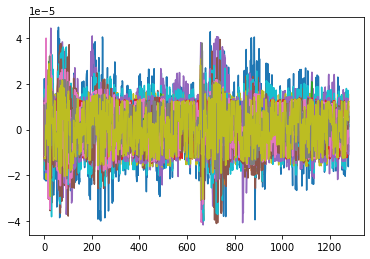

In [12]:
hc_data = np.array(torch.load(os.path.join(aug_path,"step_"+str(noise_steps)+"_hc.pth")).to("cpu"))
print(hc_data[0].shape)
plt.plot(np.arange(hc_data[0].shape[-1]),hc_data[0].T)

(19, 1280)


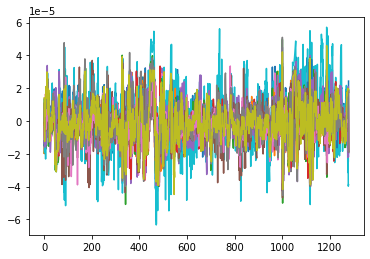

In [13]:
#tmp = torch.load(os.path.join(aug_path,"epoch_"+str(19)+".pth")).to("cpu")
mdd_data = np.array(torch.load(os.path.join(aug_path,"step_"+str(noise_steps)+"_mdd.pth")).to("cpu"))
print(mdd_data[0].shape)
plt.plot(np.arange(mdd_data[0].shape[-1]),mdd_data[0].T)

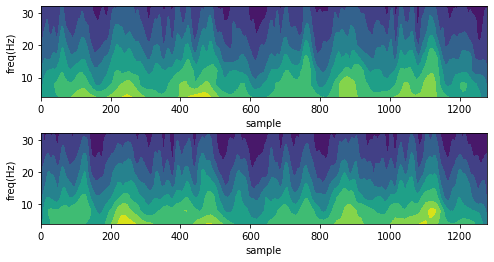

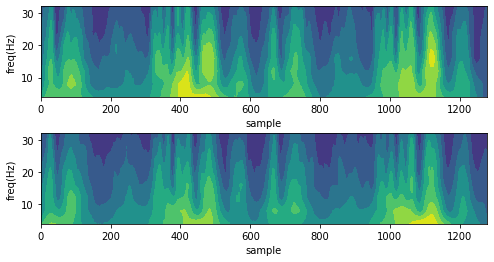

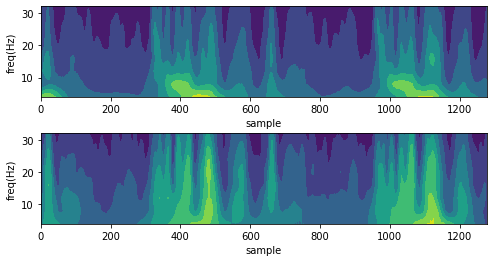

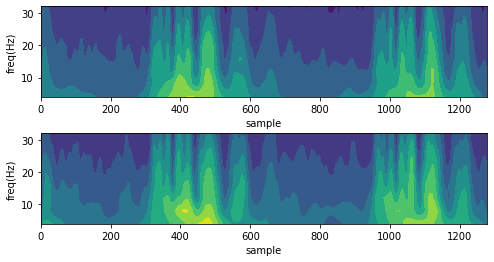

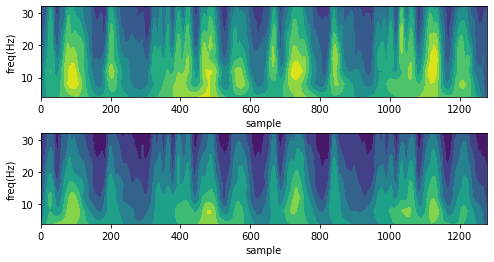

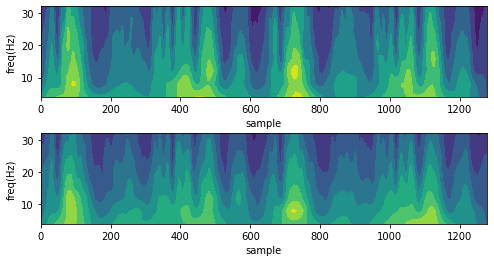

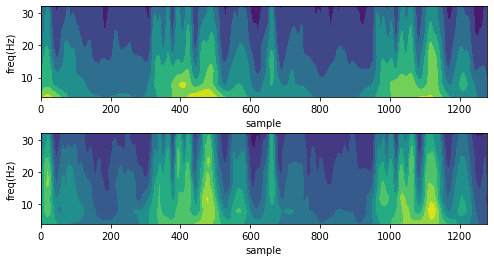

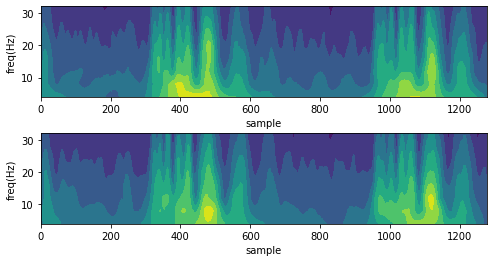

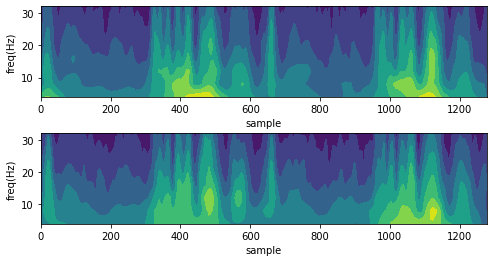

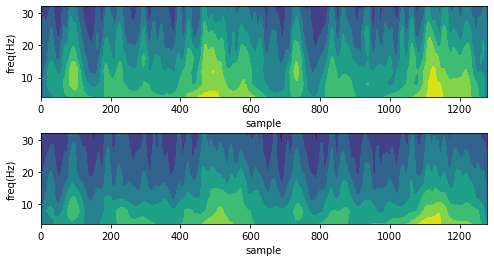

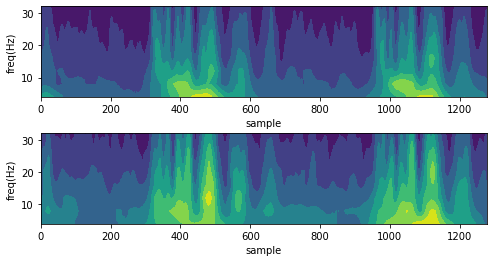

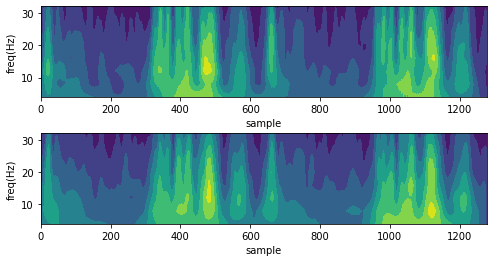

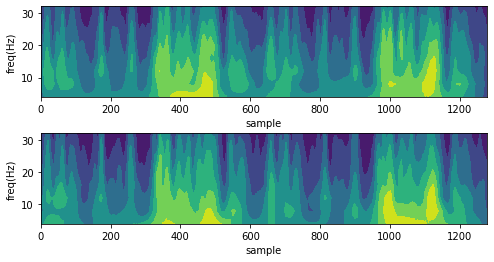

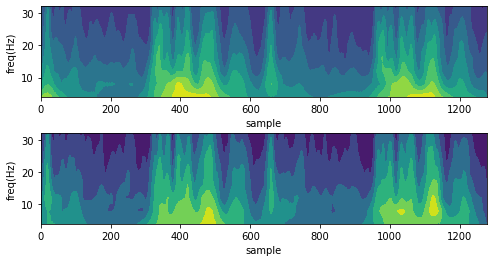

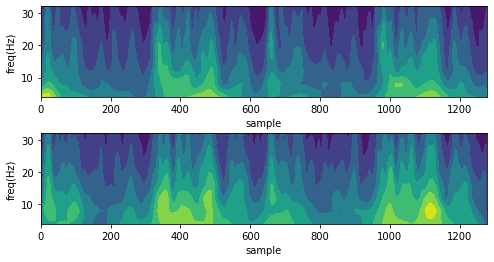

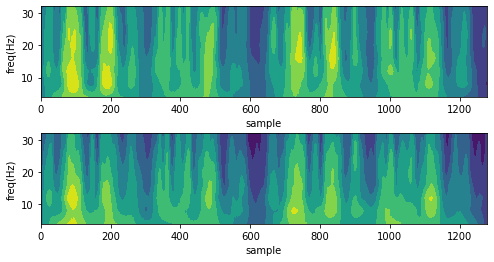

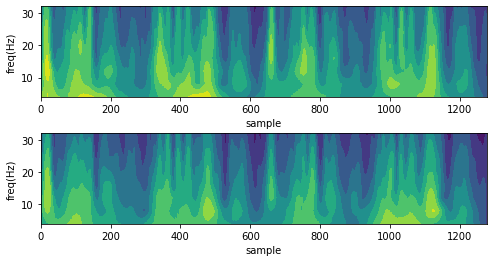

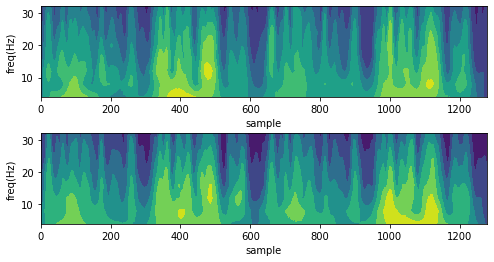

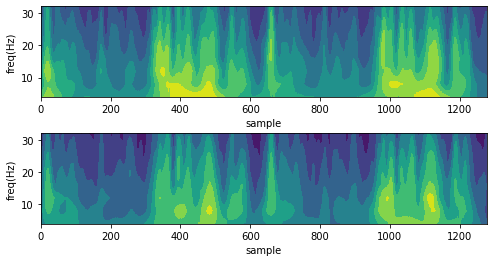

In [13]:
#cwt连续小波变换看一下结果
#hc_data = np.array(torch.load(os.path.join(aug_path,"step_"+str(noise_steps)+"_hc.pth")).to("cpu"))
#mdd_data = np.array(torch.load(os.path.join(aug_path,"step_"+str(noise_steps)+"_mdd.pth")).to("cpu"))
hc_data = np.array(torch.load(os.path.join(aug_path,"class_step_"+str(noise_steps)+"_hc.pth")).to("cpu"))
mdd_data = np.array(torch.load(os.path.join(aug_path,"class_step_"+str(noise_steps)+"_mdd.pth")).to("cpu"))
sampling_rate = 256
wavename = 'cgau8'
totalscal = 4
# 中心频率
fc = pywt.central_frequency(wavename)
# 计算对应频率的小波尺度
cparam = 8 * fc * totalscal  #这里本来是2
scales = cparam / np.arange(totalscal, 0, -0.5) #这里本来是-1
frequencies = [32.,28.,24.,20.,16.,12.,8.,4.] #计算得到

figs_hc = []
for i in range(19):
    [cwtmatr, frequencies] = pywt.cwt(hc_data[:,i], scales, wavename, 1.0 / sampling_rate)
    cwtmatr = np.array(abs(cwtmatr))#[:,:45000]
    figs_hc.append(cwtmatr)
figs_hc = np.array(figs_hc)
figs_mdd = []
for i in range(19):
    [cwtmatr, frequencies] = pywt.cwt(mdd_data[:,i], scales, wavename, 1.0 / sampling_rate)
    cwtmatr = np.array(abs(cwtmatr))#[:,:45000]
    figs_mdd.append(cwtmatr)
figs_mdd = np.array(figs_mdd)

for i in range(19):
    plt.figure(figsize=(8, 4))
    plt.subplot(211)
    t = np.arange(0, hc_data.shape[-1], 1.0)
    plt.contourf(t, frequencies, np.mean(figs_hc[i],axis=1))
    plt.ylabel(u"freq(Hz)")
    plt.xlabel(u"sample")
    plt.subplot(212)
    plt.contourf(t, frequencies, np.mean(figs_mdd[i],axis=1))
    plt.ylabel(u"freq(Hz)")
    plt.xlabel(u"sample")
    plt.subplots_adjust(hspace=0.4)
    plt.show()

### 4.3.2 conditional-无classifier引导

In [10]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
n_epoch = 20  #这里注意改！
#n_patience = 10
batch_size = 128
noise_steps = 2000 #暂且diffusion和inference都用同样的步数
pre_path_train = '/data0/violin/projects/mdd_practice/MDD_dataset/data_rest_raw'
part_train = 'REST'
model_path = '/data0/violin/projects/mdd_practice/models/ddpm_test_class'
aug_path = '/data0/violin/projects/mdd_practice/aug_results/ddpm_test'

#model = UNet().to(device)
model = DiffWave(unconditional=True, residual_channels=32,max_noise_step=noise_steps,\
        n_mels=1,residual_layers=2,dilation_cycle_length=4,n_classes=2).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
mse = nn.MSELoss()
diffusion = DDPM_con(noise_steps=noise_steps, device=device)
#logger = SummaryWriter(os.path.join("runs", args.run_name))
train_x,train_y = load_dataset([i for i in range(1,31)],[i for i in range(1,35)],preprocess_raw,pre_path_train,True,part_train)
train_y = train_y.long()
#train_x = train_x.unsqueeze(2)
# 进行归一化 很重要！逐channel来做比较好
#channels_sca = [MinMaxScaler(feature_range=(-1.0, 1.0)) for i in range(19)]
#好像还是标准化的结果更好一些呢
channels_sca = [StandardScaler() for i in range(19)]
train_x0 = []
for i in range(19):
    train_x0.append(channels_sca[i].fit_transform(train_x[:,i,:]))
train_x0 = torch.Tensor(np.array(train_x0))
train_x0 = train_x0.transpose(0,1)
#print(train_x0.shape)
#train_x = sca.fit_transform(train_x)
train_data = TensorDataset(train_x0,train_y)
dataLoader = DataLoader(train_data, batch_size = batch_size, shuffle=True)
l = len(dataLoader)
p = 0.1 #多大几率把label mask掉来训练
#early_stopping = EarlyStopping(model_path,0,patience=n_patience, verbose=True)

for epoch in range(n_epoch):
    logging.info(f"Starting epoch {epoch}:")
    pbar = tqdm(dataLoader)
    for i, (x0,y) in enumerate(pbar):
        x0 = x0.to(device)
        y = y.to(device)
        t = diffusion.sample_timesteps(x0.shape[0]).to(device)
        x_t, noise = diffusion.noise_images(x0, t)
        # predicted_noise = model(x_t, t, y)
        # loss = mse(noise, predicted_noise)
        p1 = (int)(x0.shape[0]*p)
        predicted_noise_un = model(x_t[:p1],t[:p1])
        predicted_noise = model(x_t[p1:], t[p1:], y[p1:])
        loss = p*mse(noise[:p1], predicted_noise_un) + (1-p)*mse(noise[p1:],predicted_noise)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_postfix(MSE=loss.item())
        #logger.add_scalar("MSE", loss.item(), global_step=epoch * l + i)

    torch.save(model.state_dict(), os.path.join(model_path,"epoch_"+str(epoch)+".pth"))
    #save_images(sampled_images, os.path.join("results", args.run_name, f"{epoch}.jpg"))
    
sampled_images = diffusion.sample(model, 100, torch.Tensor([0]*100).long().to(device),w=1.0)
results = []
for i in range(19):
    results.append(channels_sca[i].inverse_transform(sampled_images[:,i,:]))
results = torch.Tensor(np.array(results)).transpose(0,1)
torch.save(results,os.path.join(aug_path,"class_step_"+str(noise_steps)+"_hc.pth"))

sampled_images = diffusion.sample(model, 100, torch.Tensor([1]*100).long().to(device),w=1.0)
results = []
for i in range(19):
    results.append(channels_sca[i].inverse_transform(sampled_images[:,i,:]))
results = torch.Tensor(np.array(results)).transpose(0,1)
torch.save(results,os.path.join(aug_path,"class_step_"+str(noise_steps)+"_mdd.pth"))

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

torch.Size([19, 1280])


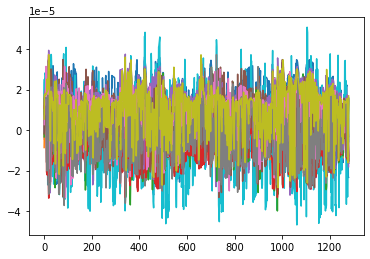

In [11]:
#tmp = torch.load(os.path.join(aug_path,"epoch_"+str(19)+".pth")).to("cpu")
tmp = torch.load(os.path.join(aug_path,"class_step_"+str(noise_steps)+"_hc.pth")).to("cpu")
print(tmp[0].shape)
plt.plot(np.arange(tmp[0].shape[-1]),tmp[0].T)

torch.Size([19, 1280])


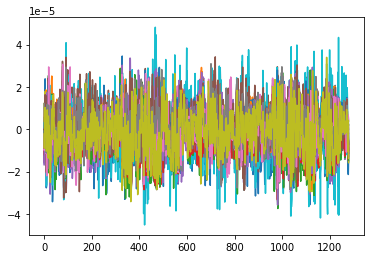

In [12]:
#tmp = torch.load(os.path.join(aug_path,"epoch_"+str(19)+".pth")).to("cpu")
tmp = torch.load(os.path.join(aug_path,"class_step_"+str(noise_steps)+"_mdd.pth")).to("cpu")
print(tmp[0].shape)
plt.plot(np.arange(tmp[0].shape[-1]),tmp[0].T)

### 4.3.3 conditional-classifier引导

#### 4.3.3.1 step1

In [12]:
#step1 用噪声数据训练classifier
#原数据集
hc_idxs = np.arange(1,31)  #30 hc
mdd_idxs = np.arange(1,35) #34-1=33 mdd
np.random.seed(42)
np.random.shuffle(hc_idxs)
np.random.shuffle(mdd_idxs)

n_fold = 10
n_sub = 3
batch_size = 128
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
n_epoch = 50  #这里注意改！
n_patience = 20
max_noise_t = 1000

pre_path_train = '/data0/violin/projects/mdd_practice/MDD_dataset/data_rest_raw'
part_train = 'REST'
pre_path_test = '/data0/violin/projects/mdd_practice/MDD_dataset/data_rest_raw'
part_test = 'REST'
model_path = '/data0/violin/projects/mdd_practice/models/ddpm_3step_test/step1'

i1 = 0
i2 = 0
hc_acc_list = [-1.0 for i in range(31)]
mdd_acc_list = [-1.0 for i in range(35)]
f1_list,acc_list,rec_list,pre_list = [],[],[],[]

ddpm_cfg = DDPM_cfg(noise_steps=max_noise_t,device=torch.device("cpu"))

for fold in range(n_fold):
    print("fold "+str(fold+1)+": ")
    hc_train_list,mdd_train_list,hc_test_list,mdd_test_list = [],[],[],[]
    for i in range(len(hc_idxs)):
        if i>=i1 and i<i1+n_sub:
            if (part_test=='EC' and hc_idxs[i] in missing_ec_hc) \
            or (part_test=='EO' and hc_idxs[i] in missing_eo_hc) : #如果没有相关数据 则往前跳一个
                i1 += 1
                continue
            hc_test_list.append(hc_idxs[i])
        else:
            hc_train_list.append(hc_idxs[i])
    for i in range(len(mdd_idxs)):
        if i>=i2 and i<i2+n_sub:
            if (part_test=='REST' and mdd_idxs[i] == 8) or (part_test=='EC' and mdd_idxs[i] in missing_ec_mdd) \
            or (part_test=='EO' and mdd_idxs[i] in missing_eo_mdd) : #如果没有相关数据 则往前跳一个
                i2 += 1
                continue
            mdd_test_list.append(mdd_idxs[i])
        else:
            mdd_train_list.append(mdd_idxs[i])
    print(hc_test_list,mdd_test_list)

    # if fold>0: #注意了！！用于跳过
    #     i1 += n_sub
    #     i2 += n_sub
    #     continue

    train_x, train_y = load_dataset(hc_train_list,mdd_train_list,\
        preprocess_raw,pre_path_train,True,part_train)
    #好像还是标准化的结果更好一些呢
    channels_sca = [StandardScaler() for i in range(19)]
    train_x0 = []
    for i in range(19):
        train_x0.append(channels_sca[i].fit_transform(train_x[:,i,:]))
    train_x0 = torch.Tensor(np.array(train_x0))
    train_x = train_x0.transpose(0,1)
    train_t = ddpm_cfg.sample_timesteps(train_x.shape[0])
    train_x,_ = ddpm_cfg.noise_images(train_x,train_t)
    train_x = train_x.unsqueeze(2)
    train_data = TensorDataset(train_x,train_t,train_y)
    dataLoader_train = DataLoader(train_data, batch_size = batch_size, shuffle=True)

    test_x, test_y = load_dataset(hc_test_list,mdd_test_list,\
        preprocess_raw,pre_path_test,True,part_test)
    test_x0 = []
    for i in range(19):
        test_x0.append(channels_sca[i].transform(test_x[:,i,:]))
    test_x0 = torch.Tensor(np.array(test_x0))
    test_x = test_x0.transpose(0,1)
    test_t = ddpm_cfg.sample_timesteps(test_x.shape[0]) #测试集是否加噪声的区别
    test_x,_ = ddpm_cfg.noise_images(test_x,test_t)
    test_x = test_x.unsqueeze(2)

    model = CNN_transformer_1d(max_noise_t)
    model = model.to(device)
    optim = torch.optim.Adam(model.parameters(),lr=1e-3)
    loss_function = nn.BCELoss()

    early_stopping = EarlyStopping(model_path,fold,patience=n_patience, verbose=True)
    tmp_f1_list,tmp_acc_list,tmp_rec_list,tmp_pre_list = [],[],[],[]
    tmp_hc_acc_list = [[] for i in range(len(hc_test_list))]
    tmp_mdd_acc_list = [[]for i in range(len(mdd_test_list))]

    for epoch in range(n_epoch):
        model.train()
        for batch_idx, (train_x, train_t, train_y) in enumerate(dataLoader_train):
            optim.zero_grad()
            train_x = train_x.to(device)
            train_t = train_t.to(device)
            train_y = train_y.to(device)
            # print(model(train_x).shape)  #看一下flatten完事之后的size
            output = model(train_x,train_t,device).squeeze(-1)[:,1]
            #print(output)
            loss = loss_function(output,train_y)
            loss.backward()
            optim.step()
            if batch_idx%10 == 0:
                print('Train Epoch: {} [{}/{}]\tloss: {:.6f}'.format(
                    epoch, batch_idx*len(train_x), len(dataLoader_train.dataset),loss.data.cpu().numpy()))
        #测试部分
        model.eval()
        model = model.to(torch.device("cpu"))
        #整体测试 这里的测试方式要看一下 测试集上样本是加噪声还是不加？加了的结果每一折都在60-65之间
        output_test = model(test_x,test_t,torch.device("cpu")).squeeze(-1)[:,1]
        test_loss = loss_function(output_test,test_y)
        output_y = (output_test>=0.5).long()
        test_y0 = test_y.long()
        tmp_f1_list.append(f1_score(test_y0,output_y))
        tmp_acc_list.append(accuracy_score(test_y0,output_y))
        tmp_rec_list.append(recall_score(test_y0,output_y))
        tmp_pre_list.append(precision_score(test_y0,output_y))
        print("Validate Epoch: {}  loss: {:.6f}  f1: {:.3f}  acc: {:.3f} recall: {:.3f}  precision: {:.3f}".\
            format(epoch, test_loss,tmp_f1_list[epoch],tmp_acc_list[epoch],tmp_rec_list[epoch],tmp_pre_list[epoch]))
        #early_stopping(test_loss, epoch, model)
        early_stopping(-tmp_acc_list[epoch], epoch, model)  #以acc为early stop标准
        if early_stopping.early_stop:
            print("Early stopping")
            break
            
        model = model.to(device)
    
    # model.load_state_dict(torch.load(os.path.join(model_path,"best_network_"+str(fold)+".pth")))
    # model.eval()
    # model = model.to(torch.device("cpu"))
    # #整体测试 这里的测试方式不加噪声 acc平均0.75 依然是召回率高一些
    # output_test = model(test_x,torch.zeros_like(test_y,dtype=torch.int32),torch.device("cpu")).squeeze(-1)[:,1]
    # test_loss = loss_function(output_test,test_y)
    # output_y = (output_test>=0.5).long()
    # test_y0 = test_y.long()
    # tmp_f1_list.append(f1_score(test_y0,output_y))
    # tmp_acc_list.append(accuracy_score(test_y0,output_y))
    # tmp_rec_list.append(recall_score(test_y0,output_y))
    # tmp_pre_list.append(precision_score(test_y0,output_y))
    # print("Test loss: {:.6f}  f1: {:.3f}  acc: {:.3f} recall: {:.3f}  precision: {:.3f}".\
    #     format(test_loss,tmp_f1_list[0],tmp_acc_list[0],tmp_rec_list[0],tmp_pre_list[0]))



fold 1: 
[28, 16, 24] [11, 1, 24]
Train Epoch: 0 [0/12618]	loss: 0.737789
Train Epoch: 0 [1280/12618]	loss: 0.773202
Train Epoch: 0 [2560/12618]	loss: 0.752771
Train Epoch: 0 [3840/12618]	loss: 0.706208
Train Epoch: 0 [5120/12618]	loss: 0.690565
Train Epoch: 0 [6400/12618]	loss: 0.722047
Train Epoch: 0 [7680/12618]	loss: 0.731165
Train Epoch: 0 [8960/12618]	loss: 0.690052
Train Epoch: 0 [10240/12618]	loss: 0.709871
Train Epoch: 0 [11520/12618]	loss: 0.732315
Validate Epoch: 0  loss: 0.706567  f1: 0.630  acc: 0.517 recall: 0.817  precision: 0.512
Validation loss decreased (inf --> -0.517290).  Saving model ...
Train Epoch: 1 [0/12618]	loss: 0.702673
Train Epoch: 1 [1280/12618]	loss: 0.671954
Train Epoch: 1 [2560/12618]	loss: 0.672825
Train Epoch: 1 [3840/12618]	loss: 0.674384
Train Epoch: 1 [5120/12618]	loss: 0.658063
Train Epoch: 1 [6400/12618]	loss: 0.645071
Train Epoch: 1 [7680/12618]	loss: 0.678807
Train Epoch: 1 [8960/12618]	loss: 0.674889
Train Epoch: 1 [10240/12618]	loss: 0.60001

#### 4.3.3.2 step2

In [10]:
#step2 训练ddpm拟合噪声，并用classifier引导采样
#原数据集
hc_idxs = np.arange(1,31)  #30 hc
mdd_idxs = np.arange(1,35) #34-1=33 mdd
np.random.seed(42)
np.random.shuffle(hc_idxs)
np.random.shuffle(mdd_idxs)

n_fold = 10
n_sub = 3
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
device_1 = torch.device("cuda:1" if torch.cuda.is_available() else "cpu") #试一下 sample的时候用另一个gpu 防止爆显存
#device_1 = torch.device("cpu")
n_epoch = 20  #这里注意改！
#n_patience = 10
batch_size = 128
noise_steps = 1000 #暂且diffusion和inference都用同样的步数
pre_path_train = '/data0/violin/projects/mdd_practice/MDD_dataset/data_rest_raw'
part_train = 'REST'
part_test = 'REST'
clf_path = '/data0/violin/projects/mdd_practice/models/ddpm_3step_test/step1'
model_path = '/data0/violin/projects/mdd_practice/models/ddpm_3step_test/step2'
aug_path = '/data0/violin/projects/mdd_practice/aug_results/ddpm_3step_test'

diffusion = DDPM_cfg(noise_steps=noise_steps, device=device)
diffusion_1 = DDPM_cfg(noise_steps=noise_steps, device=device_1)
i1 = 0
i2 = 0

for fold in range(n_fold):
    print("fold "+str(fold+1)+": ")
    hc_train_list,mdd_train_list,hc_test_list,mdd_test_list = [],[],[],[]
    for i in range(len(hc_idxs)):
        if i>=i1 and i<i1+n_sub:
            if (part_test=='EC' and hc_idxs[i] in missing_ec_hc) \
            or (part_test=='EO' and hc_idxs[i] in missing_eo_hc) : #如果没有相关数据 则往前跳一个
                i1 += 1
                continue
            hc_test_list.append(hc_idxs[i])
        else:
            hc_train_list.append(hc_idxs[i])
    for i in range(len(mdd_idxs)):
        if i>=i2 and i<i2+n_sub:
            if (part_test=='REST' and mdd_idxs[i] == 8) or (part_test=='EC' and mdd_idxs[i] in missing_ec_mdd) \
            or (part_test=='EO' and mdd_idxs[i] in missing_eo_mdd) : #如果没有相关数据 则往前跳一个
                i2 += 1
                continue
            mdd_test_list.append(mdd_idxs[i])
        else:
            mdd_train_list.append(mdd_idxs[i])
    print(hc_test_list,mdd_test_list)

    if fold<7:
        i1 += n_sub
        i2 += n_sub
        continue 
    #model = UNet().to(device)
    model = DiffWave(unconditional=True, residual_channels=32,max_noise_step=noise_steps,\
            n_mels=1,residual_layers=2,dilation_cycle_length=4,n_classes=2).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    mse = nn.MSELoss()
    #logger = SummaryWriter(os.path.join("runs", args.run_name))
    train_x,train_y = load_dataset(hc_train_list,mdd_train_list,preprocess_raw,pre_path_train,True,part_train)
    train_y = train_y.long()
    #train_x = train_x.unsqueeze(2)
    # 进行归一化 很重要！逐channel来做比较好
    #channels_sca = [MinMaxScaler(feature_range=(-1.0, 1.0)) for i in range(19)]
    #好像还是标准化的结果更好一些呢
    channels_sca = [StandardScaler() for i in range(19)]
    train_x0 = []
    for i in range(19):
        train_x0.append(channels_sca[i].fit_transform(train_x[:,i,:]))
    train_x0 = torch.Tensor(np.array(train_x0))
    train_x0 = train_x0.transpose(0,1)
    #print(train_x0.shape)
    #train_x = sca.fit_transform(train_x)
    train_data = TensorDataset(train_x0,train_y)
    dataLoader = DataLoader(train_data, batch_size = batch_size, shuffle=True)
    # early_stopping = EarlyStopping(model_path,fold,patience=n_patience, verbose=True)
    l = len(dataLoader)
    p = 0.1 #多大几率把label mask掉来训练 这个可以去掉
    weight = 1.0 #分类器引导强度

    # for epoch in range(n_epoch):
    #     logging.info(f"Starting epoch {epoch}:")
    #     pbar = tqdm(dataLoader)
    #     for i, (x0,y) in enumerate(pbar):
    #         x0 = x0.to(device)
    #         y = y.to(device)
    #         t = diffusion.sample_timesteps(x0.shape[0]).to(device)
    #         x_t, noise = diffusion.noise_images(x0, t)
    #         # predicted_noise = model(x_t, t, y)
    #         # loss = mse(noise, predicted_noise)
    #         p1 = (int)(x0.shape[0]*p)
    #         predicted_noise_un = model(x_t[:p1],t[:p1])
    #         predicted_noise = model(x_t[p1:], t[p1:], y[p1:])
    #         loss = p*mse(noise[:p1], predicted_noise_un) + (1-p)*mse(noise[p1:],predicted_noise)
    #         optimizer.zero_grad()
    #         loss.backward()
    #         optimizer.step()

    #         pbar.set_postfix(MSE=loss.item())
    #         #logger.add_scalar("MSE", loss   .item(), glo
    # 
    # bal_step=epoch * l + i)

    #     torch.save(model.state_dict(), os.path.join(model_path,"fold_"+str(fold)+".pth"))
    #     # early_stopping(, epoch, model)  #以loss为early stop标准

    n_samples = 4000
    model.load_state_dict(torch.load(os.path.join(model_path,"fold_"+str(fold)+".pth")))
    model = model.to(device_1) #转换到另一块gpu上inference
    clf = CNN_transformer_1d(noise_steps).to(device_1)
    clf.load_state_dict(torch.load(os.path.join(clf_path,"best_network_"+str(fold)+".pth")))
    model.eval()
    clf.eval()
    sampled_images = diffusion_1.sample(model, clf, n_samples, torch.Tensor([0]*n_samples).long().to(device_1),w=weight)
    sampled_images = sampled_images.to(torch.device("cpu"))
    results = []
    for i in range(19):
        results.append(channels_sca[i].inverse_transform(sampled_images[:,i,:]))
    results = torch.Tensor(np.array(results)).transpose(0,1)
    torch.save(results,os.path.join(aug_path,"class_step_"+str(noise_steps)+"_fold_"+str(fold)+"_hc_1.pth"))

    sampled_images = diffusion_1.sample(model, clf, n_samples, torch.Tensor([1]*n_samples).long().to(device_1),w=weight)
    sampled_images = sampled_images.to(torch.device("cpu"))
    results = []
    for i in range(19):
        results.append(channels_sca[i].inverse_transform(sampled_images[:,i,:]))
    results = torch.Tensor(np.array(results)).transpose(0,1)
    torch.save(results,os.path.join(aug_path,"class_step_"+ str(noise_steps)+"_fold_"+str(fold)+"_mdd_1.pth"))

fold 1: 
[28, 16, 24] [11, 1, 24]
fold 2: 
[18, 9, 10] [6, 22, 17]
fold 3: 
[29, 25, 13] [13, 26, 29]
fold 4: 
[1, 5, 17] [33, 10, 2]
fold 5: 
[6, 14, 12] [14, 27, 25]
fold 6: 
[23, 2, 3] [4, 18, 21]
fold 7: 
[26, 4, 22] [9, 7, 34]
fold 8: 
[27, 19, 30] [5, 3, 20]


0it [00:00, ?it/s]

0it [00:00, ?it/s]

fold 9: 
[27, 19, 30] [5, 3, 20]


0it [00:00, ?it/s]

0it [00:00, ?it/s]

fold 10: 
[27, 19, 30] [5, 3, 20]


0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [2]:
# aug_path = '/data0/violin/projects/mdd_practice/aug_results/ddpm_3step_test'
# noise_steps = 1000
# for fold in range(10):
#     p1 = torch.load(os.path.join(aug_path,"class_step_"+ str(noise_steps)+"_fold_"+str(fold)+"_mdd_1.pth"))
#     p2 = torch.load(os.path.join(aug_path,"class_step_"+ str(noise_steps)+"_fold_"+str(fold)+"_mdd.pth"))
#     p = torch.cat([p1,p2],dim=0)
#     torch.save(p,os.path.join(aug_path,"class_step_"+ str(noise_steps)+"_fold_"+str(fold)+"_mdd_0.pth"))

#     p1 = torch.load(os.path.join(aug_path,"class_step_"+ str(noise_steps)+"_fold_"+str(fold)+"_hc_1.pth"))
#     p2 = torch.load(os.path.join(aug_path,"class_step_"+ str(noise_steps)+"_fold_"+str(fold)+"_hc.pth"))
#     p = torch.cat([p1,p2],dim=0)
#     torch.save(p,os.path.join(aug_path,"class_step_"+ str(noise_steps)+"_fold_"+str(fold)+"_hc_0.pth"))

torch.Size([19, 1280])


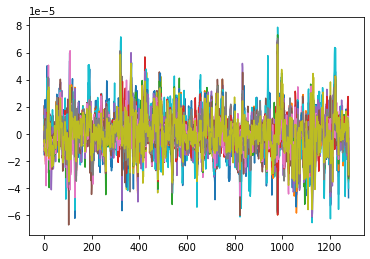

In [3]:
#tmp = torch.load(os.path.join(aug_path,"epoch_"+str(19)+".pth")).to("cpu")
aug_path = '/data0/violin/projects/mdd_practice/aug_results/ddpm_3step_test'
noise_steps = 1000
tmp = torch.load(os.path.join(aug_path,"class_step_"+str(noise_steps)+"_fold_"+str(0)+"_hc_0.pth")).to("cpu")
print(tmp[0].shape)
plt.plot(np.arange(tmp[0].shape[-1]),tmp[10].T)

torch.Size([19, 1280])


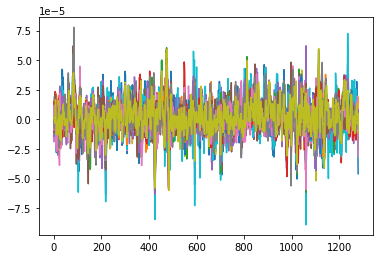

In [4]:
#tmp = torch.load(os.path.join(aug_path,"epoch_"+str(19)+".pth")).to("cpu")
tmp = torch.load(os.path.join(aug_path,"class_step_"+str(noise_steps)+"_fold_"+str(0)+"_mdd_0.pth")).to("cpu")
print(tmp[0].shape)
plt.plot(np.arange(tmp[0].shape[-1]),tmp[1].T)

6000


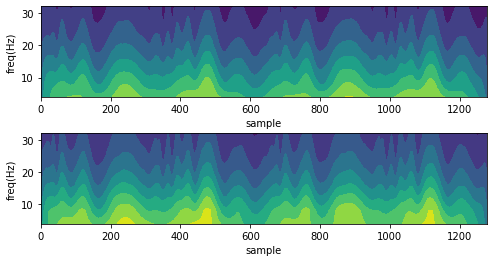

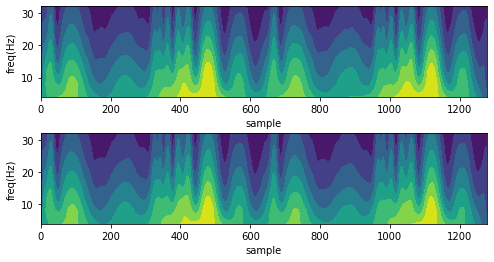

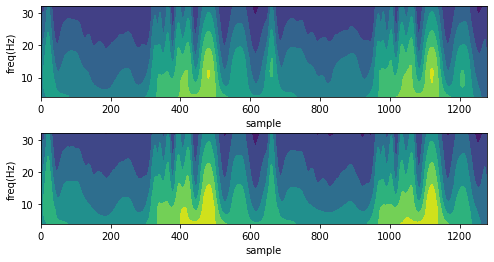

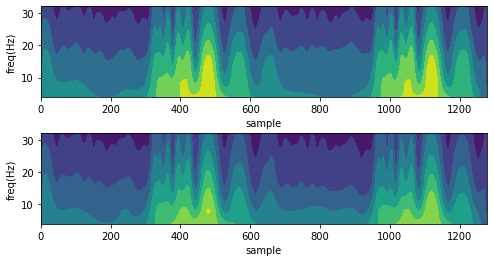

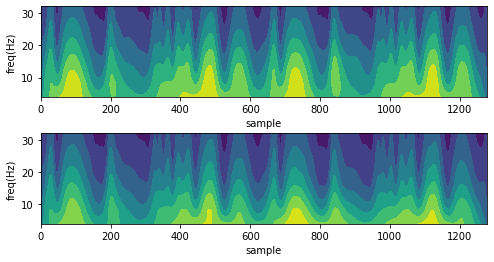

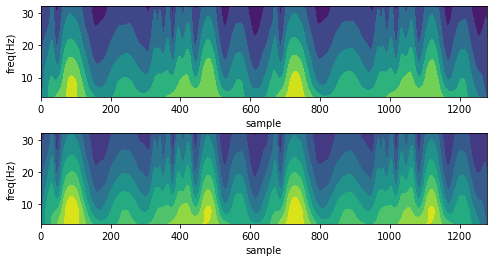

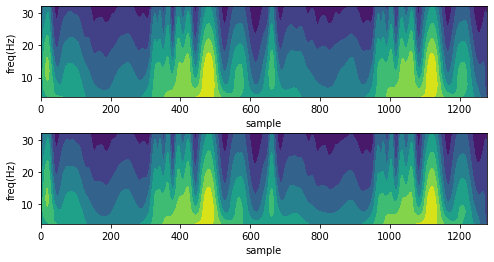

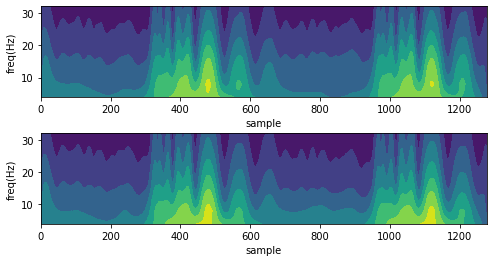

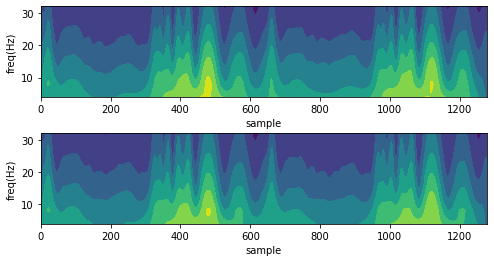

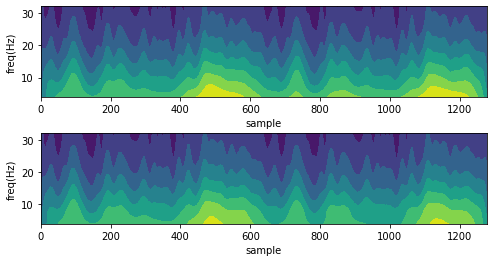

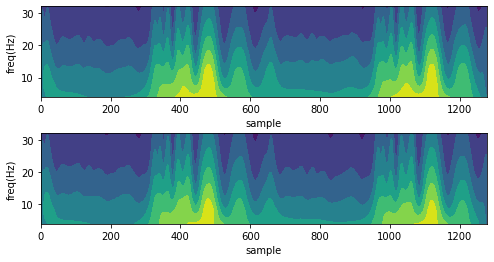

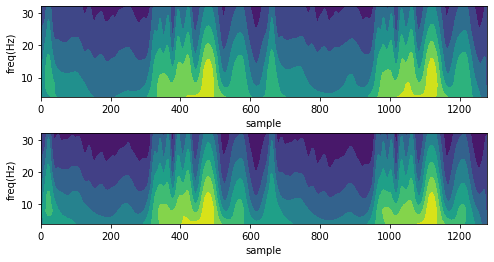

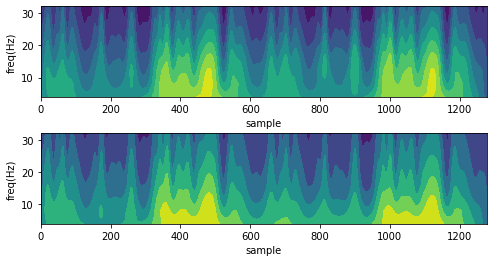

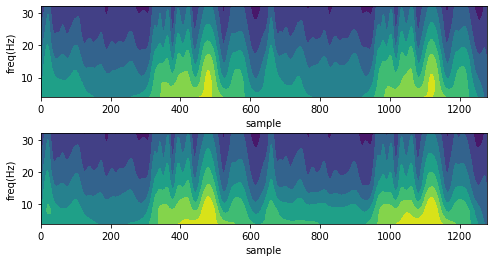

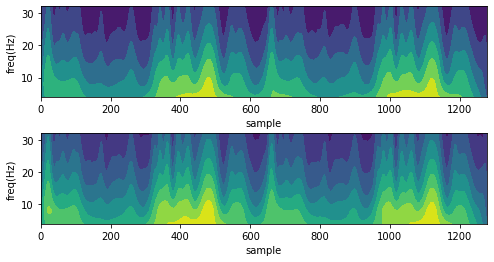

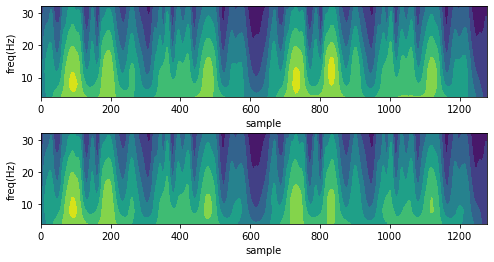

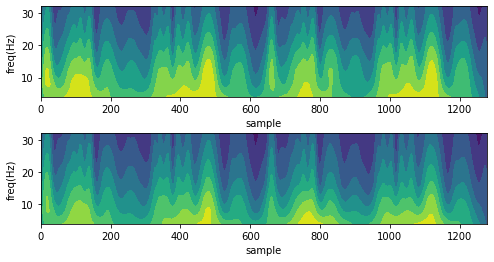

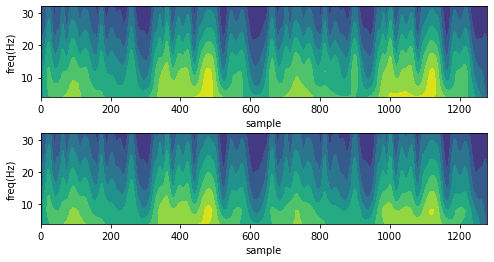

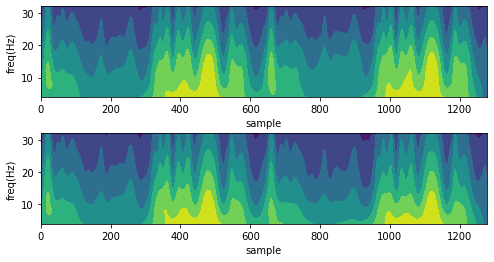

In [5]:
#cwt连续小波变换看一下结果 生成的结果
#hc_data = np.array(torch.load(os.path.join(aug_path,"step_"+str(noise_steps)+"_hc.pth")).to("cpu"))
#mdd_data = np.array(torch.load(os.path.join(aug_path,"step_"+str(noise_steps)+"_mdd.pth")).to("cpu"))
aug_path = '/data0/violin/projects/mdd_practice/aug_results/ddpm_3step_test'
noise_steps = 1000
hc_data = np.array(torch.load(os.path.join(aug_path,"class_step_"+str(noise_steps)+"_fold_"+str(9)+"_hc_0.pth")).to("cpu"))
mdd_data = np.array(torch.load(os.path.join(aug_path,"class_step_"+str(noise_steps)+"_fold_"+str(9)+"_mdd_0.pth")).to("cpu"))
print(len(hc_data))
sampling_rate = 256
wavename = 'cgau8'
totalscal = 4
# 中心频率
fc = pywt.central_frequency(wavename)
# 计算对应频率的小波尺度
cparam = 8 * fc * totalscal  #这里本来是2
scales = cparam / np.arange(totalscal, 0, -0.5) #这里本来是-1
frequencies = [32.,28.,24.,20.,16.,12.,8.,4.] #计算得到

figs_hc = []
for i in range(19):
    [cwtmatr, frequencies] = pywt.cwt(hc_data[:,i], scales, wavename, 1.0 / sampling_rate)
    cwtmatr = np.array(abs(cwtmatr))#[:,:45000]
    figs_hc.append(cwtmatr)
figs_hc = np.array(figs_hc)
figs_mdd = []
for i in range(19):
    [cwtmatr, frequencies] = pywt.cwt(mdd_data[:,i], scales, wavename, 1.0 / sampling_rate)
    cwtmatr = np.array(abs(cwtmatr))#[:,:45000]
    figs_mdd.append(cwtmatr)
figs_mdd = np.array(figs_mdd)

for i in range(19):
    plt.figure(figsize=(8, 4))
    plt.subplot(211)
    t = np.arange(0, hc_data.shape[-1], 1.0)
    plt.contourf(t, frequencies, np.mean(figs_hc[i],axis=1))
    plt.ylabel(u"freq(Hz)")
    plt.xlabel(u"sample")
    plt.subplot(212)
    plt.contourf(t, frequencies, np.mean(figs_mdd[i],axis=1))
    plt.ylabel(u"freq(Hz)")
    plt.xlabel(u"sample")
    plt.subplots_adjust(hspace=0.4)
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


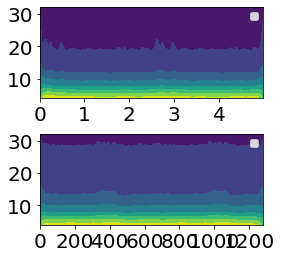

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


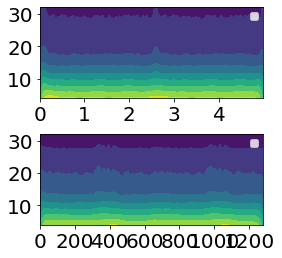

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


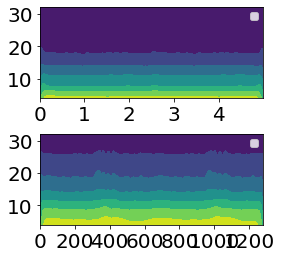

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


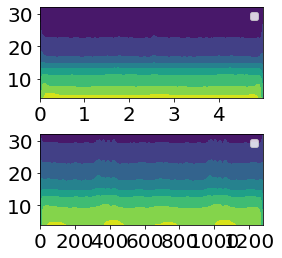

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


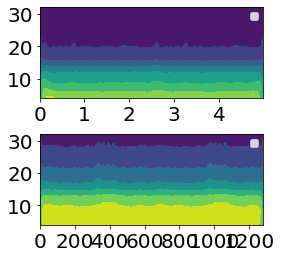

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


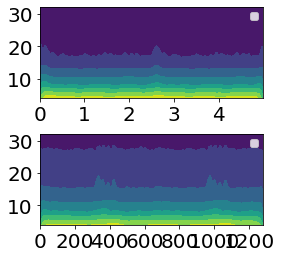

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


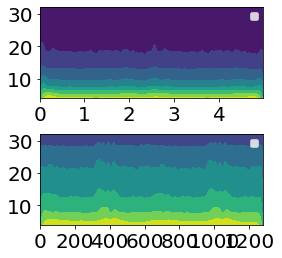

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


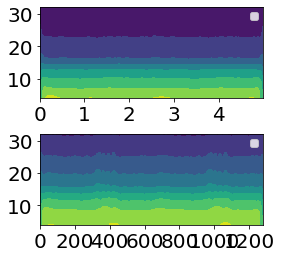

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


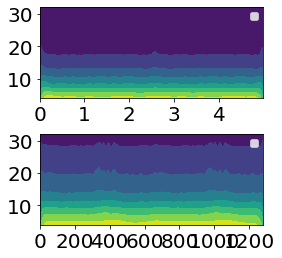

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


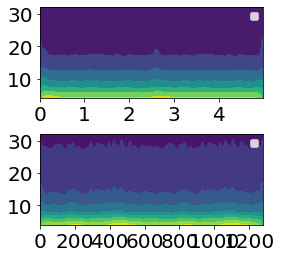

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


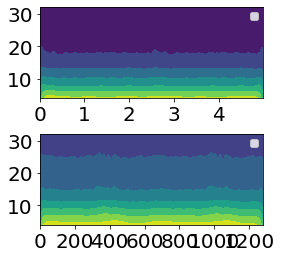

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


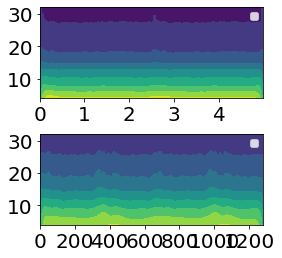

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


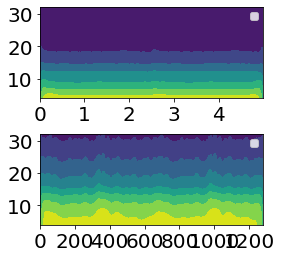

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


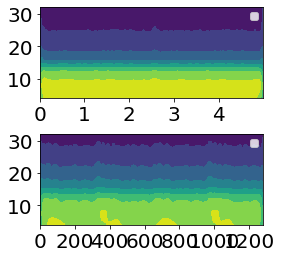

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


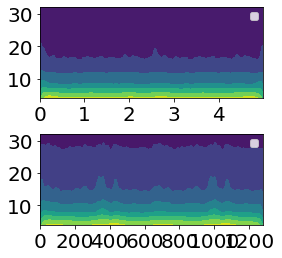

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


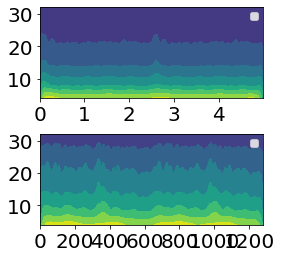

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


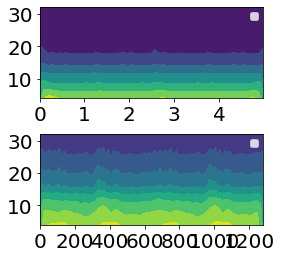

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


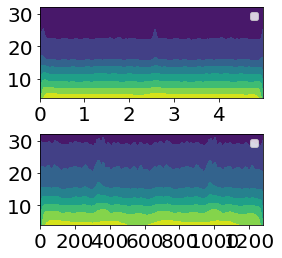

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


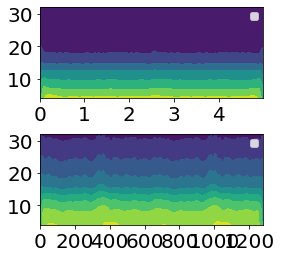

In [ ]:
pre_path_train = '/data0/violin/projects/mdd_practice/MDD_dataset/data_rest_raw'
part_train = 'REST'
hc_data,_ = load_dataset([i for i in range(1,31)],[],\
        preprocess_raw,pre_path_train,True,part_train)
hc_data = np.array(hc_data)
mdd_data,_ = load_dataset([],[i for i in range(1,35)],\
        preprocess_raw,pre_path_train,True,part_train)
mdd_data = np.array(mdd_data)
sampling_rate = 256
wavename = 'cgau8'
totalscal = 4
# 中心频率
fc = pywt.central_frequency(wavename)
# 计算对应频率的小波尺度
cparam = 8 * fc * totalscal  #这里本来是2
scales = cparam / np.arange(totalscal, 0, -0.5) #这里本来是-1
frequencies = [32.,28.,24.,20.,16.,12.,8.,4.] #计算得到

figs_hc = []
for i in range(19):
    [cwtmatr, frequencies] = pywt.cwt(hc_data[:,i], scales, wavename, 1.0 / sampling_rate)
    cwtmatr = np.array(abs(cwtmatr))#[:,:45000]
    figs_hc.append(cwtmatr)
figs_hc = np.array(figs_hc)
figs_mdd = []
for i in range(19):
    [cwtmatr, frequencies] = pywt.cwt(mdd_data[:,i], scales, wavename, 1.0 / sampling_rate)
    cwtmatr = np.array(abs(cwtmatr))#[:,:45000]
    figs_mdd.append(cwtmatr)
figs_mdd = np.array(figs_mdd)

from matplotlib import cm
for i in range(19):
    plt.figure(figsize=(4, 4))
    plt.subplot(211)
    t = np.arange(0, hc_data.shape[-1], 1.0)
    p = plt.contourf(t/256, frequencies, np.mean(figs_hc[i],axis=1))
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    fig.colorbar(p)
    #plt.ylabel(u"Frequency(Hz)")
    #plt.xlabel(u"sample")
    plt.subplot(212)
    p = plt.contourf(t/256, frequencies, np.mean(figs_mdd[i],axis=1))
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    fig.colorbar(p)
    #plt.ylabel(u"freq(Hz)")
    #plt.xlabel(u"sample")
    plt.subplots_adjust(hspace=1.0)
    plt.show()

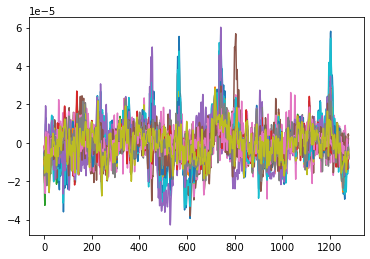

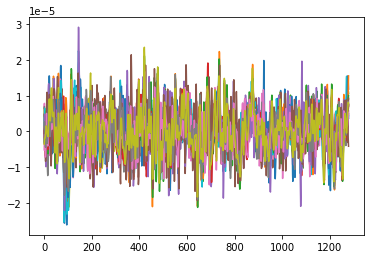

In [27]:
plt.plot(np.arange(hc_data[0].shape[-1]),hc_data[0].T)
plt.show()
plt.plot(np.arange(mdd_data[0].shape[-1]),mdd_data[0].T)

#### 4.3.3.3 step3

In [1]:
#step3 classifier fine-tune

In [10]:
#原数据集 先测一下生成质量（step2在step1上的分类精度）
hc_idxs = np.arange(1,31)  #30 hc
mdd_idxs = np.arange(1,35) #34-1=33 mdd
np.random.seed(42)
np.random.shuffle(hc_idxs)
np.random.shuffle(mdd_idxs)
n_fold = 10
n_sub = 3

clf_path = '/data0/violin/projects/mdd_practice/models/ddpm_3step_test/step1'
noise_steps = 1000
aug_path = '/data0/violin/projects/mdd_practice/aug_results/ddpm_3step_test'

#device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
pre_path_train = '/data0/violin/projects/mdd_practice/MDD_dataset/data_rest_raw'
part_train = 'REST'
part_test = 'REST'



i1 = 0
i2 = 0

for fold in range(n_fold):
    print("fold "+str(fold+1)+": ")
    hc_train_list,mdd_train_list,hc_test_list,mdd_test_list = [],[],[],[]
    for i in range(len(hc_idxs)):
        if i>=i1 and i<i1+n_sub:
            if (part_test=='EC' and hc_idxs[i] in missing_ec_hc) \
            or (part_test=='EO' and hc_idxs[i] in missing_eo_hc) : #如果没有相关数据 则往前跳一个
                i1 += 1
                continue
            hc_test_list.append(hc_idxs[i])
        else:
            hc_train_list.append(hc_idxs[i])
    for i in range(len(mdd_idxs)):
        if i>=i2 and i<i2+n_sub:
            if (part_test=='REST' and mdd_idxs[i] == 8) or (part_test=='EC' and mdd_idxs[i] in missing_ec_mdd) \
            or (part_test=='EO' and mdd_idxs[i] in missing_eo_mdd) : #如果没有相关数据 则往前跳一个
                i2 += 1
                continue
            mdd_test_list.append(mdd_idxs[i])
        else:
            mdd_train_list.append(mdd_idxs[i])
    print(hc_test_list,mdd_test_list)

    # if fold>0:
    #     i1 += n_sub
    #     i2 += n_sub
    #     continue 

    train_x,_ = load_dataset(hc_train_list,mdd_train_list,preprocess_raw,pre_path_train,True,part_train)
    channels_sca = [StandardScaler() for i in range(19)]
    for i in range(19):
        channels_sca[i].fit_transform(train_x[:,i,:])

    loss_function = nn.BCELoss()
    clf = CNN_transformer_1d(noise_steps).to(device)
    clf.load_state_dict(torch.load(os.path.join(clf_path,"best_network_"+str(fold)+".pth")))
    clf.eval()
    hc_data = torch.load(os.path.join(aug_path,"class_step_"+str(noise_steps)+"_fold_"+str(fold)+"_hc_0.pth"))
    mdd_data = torch.load(os.path.join(aug_path,"class_step_"+str(noise_steps)+"_fold_"+str(fold)+"_mdd_0.pth"))
    #label_hc = torch.zeros([hc_data.shape[0],1])
    #label_mdd = torch.ones([mdd_data.shape[0],1])
    label_hc = torch.ones([hc_data.shape[0],1])
    label_mdd = torch.zeros([mdd_data.shape[0],1])
    test_x = np.array(torch.cat([hc_data,mdd_data],dim=0))
    test_x0 = []
    for i in range(19):
        test_x0.append(channels_sca[i].transform(test_x[:,i,:]))
    test_x0 = torch.Tensor(np.array(test_x0))
    test_x = test_x0.transpose(0,1).unsqueeze(2).to(device)
    test_y = torch.cat([label_hc,label_mdd],dim=0).to(device).squeeze(-1)
    test_t = torch.zeros_like(test_y,dtype=torch.int32).to(device)
    print(test_x.shape)
    print(test_t.shape)
    output_test = clf(test_x,test_t,device).squeeze(-1)[:,1]
    test_loss = loss_function(output_test,test_y)
    output_y = (output_test>=0.5).long()
    test_y0 = test_y.long()
    print("Test loss: {:.6f}  f1: {:.3f}  acc: {:.3f} recall: {:.3f}  precision: {:.3f}".\
        format(test_loss,f1_score(test_y0,output_y),accuracy_score(test_y0,output_y),recall_score(test_y0,output_y),precision_score(test_y0,output_y)))


fold 1: 
[28, 16, 24] [11, 1, 24]
torch.Size([12000, 19, 1, 1280])
torch.Size([12000])
Test loss: 0.703952  f1: 0.667  acc: 0.500 recall: 1.000  precision: 0.500
fold 2: 
[28, 16, 24] [1, 24, 6]
torch.Size([12000, 19, 1, 1280])
torch.Size([12000])
Test loss: 0.745847  f1: 0.667  acc: 0.500 recall: 1.000  precision: 0.500
fold 3: 
[28, 16, 24] [1, 24, 6]
torch.Size([12000, 19, 1, 1280])
torch.Size([12000])
Test loss: 0.693355  f1: 0.665  acc: 0.502 recall: 0.991  precision: 0.501
fold 4: 
[28, 16, 24] [1, 24, 6]
torch.Size([12000, 19, 1, 1280])
torch.Size([12000])
Test loss: 0.695266  f1: 0.003  acc: 0.500 recall: 0.002  precision: 0.435
fold 5: 
[28, 16, 24] [1, 24, 6]


KeyboardInterrupt: 

In [8]:
#原数据集
hc_idxs = np.arange(1,31)  #30 hc
mdd_idxs = np.arange(1,35) #34-1=33 mdd
np.random.seed(42)
np.random.shuffle(hc_idxs)
np.random.shuffle(mdd_idxs)

n_fold = 10
n_sub = 3
batch_size = 128
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
n_epoch = 30  #这里注意改！
n_patience = 10

clf_path = '/data0/violin/projects/mdd_practice/models/ddpm_3step_test/step1'
noise_steps = 1000
aug_path = '/data0/violin/projects/mdd_practice/aug_results/ddpm_3step_test'
pre_path_train = '/data0/violin/projects/mdd_practice/MDD_dataset/data_rest_raw'
part_train = 'REST'
pre_path_test = '/data0/violin/projects/mdd_practice/MDD_dataset/data_rest_raw'
part_test = 'REST'
model_path = '/data0/violin/projects/mdd_practice/models/ddpm_3step_test/step3'

i1 = 0
i2 = 0
hc_acc_list = [-1.0 for i in range(31)]
mdd_acc_list = [-1.0 for i in range(35)]
f1_list,acc_list,rec_list,pre_list = [],[],[],[]

for fold in range(n_fold):
    print("fold "+str(fold+1)+": ")
    hc_train_list,mdd_train_list,hc_test_list,mdd_test_list = [],[],[],[]
    for i in range(len(hc_idxs)):
        if i>=i1 and i<i1+n_sub:
            if (part_test=='EC' and hc_idxs[i] in missing_ec_hc) \
            or (part_test=='EO' and hc_idxs[i] in missing_eo_hc) : #如果没有相关数据 则往前跳一个
                i1 += 1
                continue
            hc_test_list.append(hc_idxs[i])
        else:
            hc_train_list.append(hc_idxs[i])
    for i in range(len(mdd_idxs)):
        if i>=i2 and i<i2+n_sub:
            if (part_test=='REST' and mdd_idxs[i] == 8) or (part_test=='EC' and mdd_idxs[i] in missing_ec_mdd) \
            or (part_test=='EO' and mdd_idxs[i] in missing_eo_mdd) : #如果没有相关数据 则往前跳一个
                i2 += 1
                continue
            mdd_test_list.append(mdd_idxs[i])
        else:
            mdd_train_list.append(mdd_idxs[i])
    print(hc_test_list,mdd_test_list)

    # if fold<5: #注意了！！用于跳过
    #     i1 += n_sub
    #     i2 += n_sub
    #     continue

    train_x, train_y = load_dataset(hc_train_list,mdd_train_list,\
        preprocess_raw,pre_path_train,True,part_train)

    #带上数据增强
    # hc_data = torch.load(os.path.join(aug_path,"class_step_"+str(noise_steps)+"_fold_"+str(fold)+"_hc_0.pth"))
    # mdd_data = torch.load(os.path.join(aug_path,"class_step_"+str(noise_steps)+"_fold_"+str(fold)+"_mdd_0.pth"))
    # label_hc = torch.ones([hc_data.shape[0]])
    # label_mdd = torch.zeros([mdd_data.shape[0]])
    # train_x = torch.cat([train_x,hc_data,mdd_data],dim=0)
    # train_y = torch.cat([train_y,label_hc,label_mdd],dim=0)
    
    tmp_x = []
    channels_sca = [StandardScaler() for i in range(19)]
    for i in range(19):
        tmp_x.append(channels_sca[i].fit_transform(train_x[:,i,:]))
    tmp_x = torch.Tensor(np.array(tmp_x))
    train_x = tmp_x.transpose(0,1).unsqueeze(2)
    train_t = torch.zeros_like(train_y,dtype=torch.int32)
    train_data = TensorDataset(train_x,train_t,train_y)
    dataLoader_train = DataLoader(train_data, batch_size = batch_size, shuffle=True)

    test_x, test_y = load_dataset(hc_test_list,mdd_test_list,\
        preprocess_raw,pre_path_test,True,part_test)
    test_x0 = []
    for i in range(19):
        test_x0.append(channels_sca[i].transform(test_x[:,i,:]))
    test_x0 = torch.Tensor(np.array(test_x0))
    test_x = test_x0.transpose(0,1).unsqueeze(2)
    test_t = torch.zeros_like(test_y,dtype=torch.int32)

    #每个subject的样本单独测试一下 看是谁低了
    test_x_list,test_y_list = [],[]
    for idx in hc_test_list:
        x,y = load_dataset([idx],[],preprocess_raw,pre_path_test,True,part_test)
        tmp_x = []
        for i in range(19):
            tmp_x.append(channels_sca[i].transform(x[:,i,:]))
        tmp_x = torch.Tensor(np.array(tmp_x))
        #test_x_list.append(x)
        test_x_list.append(tmp_x.transpose(0,1).unsqueeze(2))
        #.reshape(-1,19*8,1280))
        test_y_list.append(y)
    for idx in mdd_test_list:
        x,y = load_dataset([],[idx],preprocess_raw,pre_path_test,True,part_test)
        tmp_x = []
        for i in range(19):
            tmp_x.append(channels_sca[i].transform(x[:,i,:]))
        tmp_x = torch.Tensor(np.array(tmp_x))
        #test_x_list.append(x)
        test_x_list.append(tmp_x.transpose(0,1).unsqueeze(2))
        test_y_list.append(y)
    print("OK")

    model = CNN_transformer_1d(noise_steps).to(device)
    # model.load_state_dict(torch.load(os.path.join(clf_path,"best_network_"+str(fold)+".pth")))
    model = model.to(device)
    optim = torch.optim.Adam(model.parameters(),lr=1e-3)
    loss_function = nn.BCELoss()

    early_stopping = EarlyStopping(model_path,fold,patience=n_patience, verbose=True)
    tmp_f1_list,tmp_acc_list,tmp_rec_list,tmp_pre_list = [],[],[],[]
    tmp_hc_acc_list = [[] for i in range(len(hc_test_list))]
    tmp_mdd_acc_list = [[]for i in range(len(mdd_test_list))]

    for epoch in range(n_epoch):
        model.train()
        for batch_idx, (train_x, train_t, train_y) in enumerate(dataLoader_train):
            optim.zero_grad()
            train_x = train_x.to(device)
            train_y = train_y.to(device)
            train_t = train_t.to(device)
            # print(model(train_x).shape)  #看一下flatten完事之后的size
            output = model(train_x,train_t,device).squeeze(-1)[:,1] 
            #print(output)
            loss = loss_function(output,train_y)
            loss.backward()
            optim.step()
            if batch_idx%10 == 0:
                print('Train Epoch: {} [{}/{}]\tloss: {:.6f}'.format(
                    epoch, batch_idx*len(train_x), len(dataLoader_train.dataset),loss.data.cpu().numpy()))
        #测试部分
        model.eval()
        model = model.to(torch.device("cpu"))
        #整体测试
        output_test = model(test_x,test_t,torch.device("cpu")).squeeze(-1)[:,1]
        test_loss = loss_function(output_test,test_y)
        output_y = (output_test>=0.5).long()
        test_y0 = test_y.long()
        tmp_f1_list.append(f1_score(test_y0,output_y))
        tmp_acc_list.append(accuracy_score(test_y0,output_y))
        tmp_rec_list.append(recall_score(test_y0,output_y))
        tmp_pre_list.append(precision_score(test_y0,output_y))
        print("Validate Epoch: {}  loss: {:.6f}  f1: {:.3f}  acc: {:.3f} recall: {:.3f}  precision: {:.3f}".\
            format(epoch, test_loss,tmp_f1_list[epoch],tmp_acc_list[epoch],tmp_rec_list[epoch],tmp_pre_list[epoch]))
        #early_stopping(test_loss, epoch, model)
        early_stopping(-tmp_acc_list[epoch], epoch, model)  #以acc为early stop标准
        if early_stopping.early_stop:
            print("Early stopping")
            break

        #个体测试
        for i in range(len(hc_test_list)):
            output_test = model(test_x_list[i],torch.zeros_like(test_y_list[i],dtype=torch.int32),torch.device("cpu")).squeeze(-1)[:,1]
            test_loss = loss_function(output_test,test_y_list[i])
            output_y = (output_test>=0.5).long()
            test_y0 = test_y_list[i].long()
            print("HC: {}  loss: {:.6f} acc: {:.3f}".\
                format(hc_test_list[i],test_loss,accuracy_score(test_y0,output_y)))
            tmp_hc_acc_list[i].append(accuracy_score(test_y0,output_y))

        for i in range(len(mdd_test_list)):
            output_test = model(test_x_list[i+len(hc_test_list)],torch.zeros_like(test_y_list[i+len(hc_test_list)],dtype=torch.int32),torch.device("cpu")).squeeze(-1)[:,1]
            test_loss = loss_function(output_test,test_y_list[i+len(hc_test_list)])
            output_y = (output_test>=0.5).long()
            test_y0 = test_y_list[i+len(hc_test_list)].long()
            print("MDD: {}  loss: {:.6f} acc: {:.3f}".\
                format(mdd_test_list[i],test_loss,accuracy_score(test_y0,output_y)))
            tmp_mdd_acc_list[i].append(accuracy_score(test_y0,output_y))
            
        model = model.to(device)

    best_epoch = early_stopping.best_epoch
    f1_list.append(tmp_f1_list[best_epoch])
    acc_list.append(tmp_acc_list[best_epoch])
    rec_list.append(tmp_rec_list[best_epoch])
    pre_list.append(tmp_pre_list[best_epoch])
    for i in range(len(hc_test_list)):
        hc_acc_list[hc_test_list[i]] = tmp_hc_acc_list[i][best_epoch]
    for i in range(len(mdd_test_list)):
        mdd_acc_list[mdd_test_list[i]] = tmp_mdd_acc_list[i][best_epoch]
    i1 += n_sub
    i2 += n_sub


#model.load_state_dict(torch.load('checkpoint.pt'))
print(f1_list,acc_list,rec_list,pre_list)
print(np.mean(f1_list),np.mean(acc_list),np.mean(rec_list),np.mean(pre_list))
#np.save('/data0/violin/projects/mdd_practice/tmp/hc_acc.npy',np.array(hc_acc_list))
#np.save('/data0/violin/projects/mdd_practice/tmp/mdd_acc.npy',np.array(mdd_acc_list))

fold 1: 
[28, 16, 24] [11, 1, 24]
OK
Train Epoch: 0 [0/12618]	loss: 0.763460
Train Epoch: 0 [1280/12618]	loss: 0.658114
Train Epoch: 0 [2560/12618]	loss: 0.674424
Train Epoch: 0 [3840/12618]	loss: 0.669203
Train Epoch: 0 [5120/12618]	loss: 0.591376
Train Epoch: 0 [6400/12618]	loss: 0.531132
Train Epoch: 0 [7680/12618]	loss: 0.392504
Train Epoch: 0 [8960/12618]	loss: 0.374252
Train Epoch: 0 [10240/12618]	loss: 0.355915
Train Epoch: 0 [11520/12618]	loss: 0.365060
Validate Epoch: 0  loss: 0.770688  f1: 0.760  acc: 0.685 recall: 0.994  precision: 0.616
Validation loss decreased (inf --> -0.685251).  Saving model ...
HC: 28  loss: 0.045747 acc: 1.000
HC: 16  loss: 2.373245 acc: 0.000
HC: 24  loss: 1.930790 acc: 0.111
MDD: 11  loss: 0.122248 acc: 0.996
MDD: 1  loss: 0.117989 acc: 0.987
MDD: 24  loss: 0.073717 acc: 1.000
Train Epoch: 1 [0/12618]	loss: 0.263808
Train Epoch: 1 [1280/12618]	loss: 0.282254
Train Epoch: 1 [2560/12618]	loss: 0.254127
Train Epoch: 1 [3840/12618]	loss: 0.233841
Train

In [9]:
a1 = np.array(hc_acc_list)
a2 = np.array(mdd_acc_list)
print(a1)
print(a2)

a1 = a1[a1>=0.0]
a2 = a2[a2>=0.0]



print(np.mean(a1)/2+np.mean(a2)/2)

[-1.          0.89883268  0.99579832  0.90376569  1.          1.
  0.80753138  0.98084291  1.          1.          1.          1.
  1.          1.          1.          1.          0.527897    0.82572614
  0.95798319  1.          0.96356275  1.          0.91561181  1.
  0.78723404  0.20168067  0.9832636   0.8940678   1.          1.
  0.8940678 ]
[-1.          0.83263598  0.63247863  0.87830688  0.88235294  0.05462185
  0.95798319  0.99152542 -1.          1.          0.81434599  0.44491525
  0.95945946  0.97095436  0.94514768 -1.         -1.          0.91914894
  0.83122363  0.73305085  0.70464135  1.          1.          1.
  0.97890295  0.97457627  0.99576271  0.52320675 -1.          1.
  1.          1.          1.          1.          1.        ]
0.8927184480599792


# 5.数据增强-GANs

In [9]:
#判别器定义一下 需要添加label作为输入
#CNN part
class CNN_1d_module(nn.Module):
    def __init__(self,n_dim):
        super().__init__()
        self.model1 = nn.Sequential(  
            nn.MaxPool1d(5), 
            nn.BatchNorm1d(n_dim),
            nn.Conv1d(n_dim,16,10), #input_n,kernel_n,kernel_size
            nn.ReLU(),
            nn.MaxPool1d(5),
            nn.BatchNorm1d(16),
            nn.Conv1d(16,32,20,1,1), #padding=1
            nn.ReLU())


    def forward(self,x):
        x = self.model1(x)
        return x
    
class SelfAttention(nn.Module):
	def __init__(self, embed_size, heads):
		super().__init__()
		self.embed_size = embed_size
		self.heads = heads
		self.head_dim = embed_size // heads

		assert (self.head_dim * heads == embed_size), "Embed size needs to be div by heads"

		self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
		self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
		self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
		self.fc_out = nn.Linear(heads * self.head_dim, embed_size)

	def forward(self, values, keys, query, mask):
		N = query.shape[0]
		value_len , key_len , query_len = values.shape[1], keys.shape[1], query.shape[1]

		# split embedding into self.heads pieces
		values = values.reshape(N, value_len, self.heads, self.head_dim)
		keys = keys.reshape(N, key_len, self.heads, self.head_dim)
		queries = query.reshape(N, query_len, self.heads, self.head_dim)
		
		values = self.values(values)
		keys = self.keys(keys)
		queries = self.queries(queries)

		energy = torch.einsum("nqhd,nkhd->nhqk", queries, keys)
		# queries shape: (N, query_len, heads, heads_dim)
		# keys shape : (N, key_len, heads, heads_dim)
		# energy shape: (N, heads, query_len, key_len)

		if mask is not None:
			energy = energy.masked_fill(mask == 0, float("-1e20"))

		attention = torch.softmax(energy/ (self.embed_size ** (1/2)), dim=3)

		out = torch.einsum("nhql, nlhd->nqhd", [attention, values]).reshape(N, query_len, self.heads*self.head_dim)
		# attention shape: (N, heads, query_len, key_len)
		# values shape: (N, value_len, heads, heads_dim)
		# (N, query_len, heads, head_dim)

		out = self.fc_out(out)
		return out


class TransformerBlock(nn.Module):
	def __init__(self, embed_size, heads, dropout, forward_expansion):
		super().__init__()
		self.attention = SelfAttention(embed_size, heads)
		self.norm1 = nn.LayerNorm(embed_size)
		self.norm2 = nn.LayerNorm(embed_size)

		self.feed_forward = nn.Sequential(
			nn.Linear(embed_size, forward_expansion*embed_size),
			nn.ReLU(),
			nn.Linear(forward_expansion*embed_size, embed_size)
		)
		self.dropout = nn.Dropout(dropout)

	def forward(self, value, key, query, mask=None):
		attention = self.attention(value, key, query, mask)
		x = self.dropout(self.norm1(attention + query))
		forward = self.feed_forward(x)
		out = self.dropout(self.norm2(forward + x))
		return out

#注意 这里最后一层需要concat一个代表timestamp(加噪)的向量
class CNN_transformer_1d(nn.Module):
    def __init__(self):       
        super().__init__()
        self.CNN_1d_module = CNN_1d_module(19)
        self.time_embedding = nn.Embedding(32,32)
        self.drop_out = nn.Dropout(0.5)
        self.attention_module_tm = TransformerBlock(32,4,0.5,32) 
        # self.fc2 = nn.Sequential(
        #     nn.Linear(32,1), 
        #     nn.Sigmoid())
        self.fc2 = nn.Sequential(
            nn.Linear(64,2), 
            nn.Softmax(dim=-1))
        self.class_embedding = nn.Embedding(2,32)

    def forward(self,x,label,device):
        x = x.squeeze(2)
        part = self.CNN_1d_module(x) 
        part = part.transpose(1,2) #batch_size*time*dim
        t = self.time_embedding(torch.IntTensor([i for i in range(part.shape[1])]).to(device))
        part = part+t
        part = self.drop_out(part)
        # print(part.shape)
        part = self.attention_module_tm(part,part,part)
        #part = self.fc1(part)
        part = part[:,-1,:] #last step
        label_emb = self.class_embedding(label)
        part = torch.cat([part,label_emb],dim=1)
        part = self.fc2(part)
        return part



In [10]:
#注意 这里最后一层需要concat一个代表timestamp(加噪)的向量 还是判别器（去掉最后一层sigmoid/softmax）
class CNN_transformer_1d_wgan(nn.Module):
    def __init__(self):       
        super().__init__()
        self.CNN_1d_module = CNN_1d_module(19)
        self.time_embedding = nn.Embedding(32,32)
        self.drop_out = nn.Dropout(0.5)
        self.attention_module_tm = TransformerBlock(32,4,0.5,32) 
        # self.fc2 = nn.Sequential(
        #     nn.Linear(32,1), 
        #     nn.Sigmoid())
        self.fc2 = nn.Linear(64,2)
        self.class_embedding = nn.Embedding(2,32)

    def forward(self,x,label,device):
        x = x.squeeze(2)
        part = self.CNN_1d_module(x) 
        part = part.transpose(1,2) #batch_size*time*dim
        t = self.time_embedding(torch.IntTensor([i for i in range(part.shape[1])]).to(device))
        part = part+t
        part = self.drop_out(part)
        # print(part.shape)
        part = self.attention_module_tm(part,part,part)
        #part = self.fc1(part)
        part = part[:,-1,:] #last step
        label_emb = self.class_embedding(label)
        part = torch.cat([part,label_emb],dim=1)
        part = self.fc2(part)
        return part



## 5.1 CGAN（or GAN？）

In [8]:
#还是需要label作为输入引导的 条件生成模型
#原数据集
hc_idxs = np.arange(1,31)  #30 hc
mdd_idxs = np.arange(1,35) #34-1=33 mdd
np.random.seed(42)
np.random.shuffle(hc_idxs)
np.random.shuffle(mdd_idxs)

n_fold = 10
n_sub = 3
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
device_1 = torch.device("cuda:1" if torch.cuda.is_available() else "cpu") #试一下 sample的时候用另一个gpu 防止爆显存
#device_1 = torch.device("cpu")
n_epoch = 10  #这里注意改！
#n_patience = 10
batch_size = 128
noise_steps = 1
pre_path_train = '/data0/violin/projects/mdd_practice/MDD_dataset/data_rest_raw'
part_train = 'REST'
part_test = 'REST'
model_path = '/data0/violin/projects/mdd_practice/models/gan_test' #这里保存G就可以了
aug_path = '/data0/violin/projects/mdd_practice/aug_results/gan_test'

i1 = 0
i2 = 0

for fold in range(n_fold):
    print("fold "+str(fold+1)+": ")
    hc_train_list,mdd_train_list,hc_test_list,mdd_test_list = [],[],[],[]
    for i in range(len(hc_idxs)):
        if i>=i1 and i<i1+n_sub:
            if (part_test=='EC' and hc_idxs[i] in missing_ec_hc) \
            or (part_test=='EO' and hc_idxs[i] in missing_eo_hc) : #如果没有相关数据 则往前跳一个
                i1 += 1
                continue
            hc_test_list.append(hc_idxs[i])
        else:
            hc_train_list.append(hc_idxs[i])
    for i in range(len(mdd_idxs)):
        if i>=i2 and i<i2+n_sub:
            if (part_test=='REST' and mdd_idxs[i] == 8) or (part_test=='EC' and mdd_idxs[i] in missing_ec_mdd) \
            or (part_test=='EO' and mdd_idxs[i] in missing_eo_mdd) : #如果没有相关数据 则往前跳一个
                i2 += 1
                continue
            mdd_test_list.append(mdd_idxs[i])
        else:
            mdd_train_list.append(mdd_idxs[i])
    print(hc_test_list,mdd_test_list)

    # if fold<7:
    #     i1 += n_sub
    #     i2 += n_sub
    #     continue 
    G = DiffWave(unconditional=True, residual_channels=32,max_noise_step=noise_steps,\
            n_mels=1,residual_layers=2,dilation_cycle_length=4,n_classes=2).to(device)
    optimizerG = torch.optim.AdamW(G.parameters(), lr=1e-4)
    #optimizerG = torch.optim.RMSprop(G.parameters(), lr=1e-4)
    D = CNN_transformer_1d().to(device)
    optimizerD = torch.optim.AdamW(D.parameters(), lr=2*1e-4)
    #optimizerD = torch.optim.RMSprop(D.parameters(), lr=2*1e-4)
    loss_function = nn.BCELoss()
    #logger = SummaryWriter(os.path.join("runs", args.run_name))
    train_x,train_y = load_dataset(hc_train_list,mdd_train_list,preprocess_raw,pre_path_train,True,part_train)
    train_y = train_y.long()
    #train_x = train_x.unsqueeze(2)
    # 进行归一化 很重要！逐channel来做比较好
    #channels_sca = [MinMaxScaler(feature_range=(-1.0, 1.0)) for i in range(19)]
    #好像还是标准化的结果更好一些呢
    #channels_sca = [StandardScaler() for i in range(19)]
    # train_x0 = []
    # for i in range(19):
    #     train_x0.append(channels_sca[i].fit_transform(train_x[:,i,:]))
    # train_x0 = torch.Tensor(np.array(train_x0))
    # train_x0 = train_x0.transpose(0,1)
    train_x0 = train_x

    train_data = TensorDataset(train_x0,train_y)
    dataLoader = DataLoader(train_data, batch_size = batch_size, shuffle=True)
    # early_stopping = EarlyStopping(model_path,fold,patience=n_patience, verbose=True)

    for epoch in range(n_epoch):
        logging.info(f"Starting epoch {epoch}:")
        pbar = tqdm(dataLoader)
        for i, (x,label_mdd) in enumerate(pbar):
            x = x.to(device)
            label_mdd = label_mdd.to(device)
            noise = torch.randn_like(x).to(device)
            x_fake = G(noise,torch.zeros(x.shape[0]).long().to(device),label_mdd)
            label_real = torch.ones(x.shape[0]).to(device)
            label_fake = torch.zeros(x.shape[0]).to(device)
            output_real = D(x,label_mdd,device)[:,1]
            output_fake = D(x_fake,label_mdd,device)[:,1]

            optimizerD.zero_grad()
            lossD_real = loss_function(output_real,label_real)
            lossD_fake = loss_function(output_fake,label_fake)
            lossD = lossD_real + lossD_fake
            lossD.backward(retain_graph=True)
            optimizerD.step()

            #更新了一步D后 再用D的结果来更新G 且这里的标签要反着来 妙啊
            optimizerG.zero_grad()
            label_reverse = torch.ones(x.shape[0]).to(device)
            output = D(x_fake,label_mdd,device)[:,1]
            lossG = loss_function(output,label_reverse) #这个label是反着来的 也就是说是“对抗”
            lossG.backward(retain_graph=True)
            optimizerG.step()

            if i%10 == 0:
                print('Train Epoch: {} [{}/{}]\tloss_D: {:.6f}\tloss_G: {:.6f}'.format(
                    epoch, i*len(train_x), len(dataLoader.dataset),lossD.data.cpu().numpy(),lossG.data.cpu().numpy()))

        torch.save(G.state_dict(), os.path.join(model_path,"fold_"+str(fold)+".pth"))
        # early_stopping(, epoch, model)  #以loss为early stop标准

    n_samples = 1700
    #G.load_state_dict(torch.load(os.path.join(model_path,"fold_"+str(fold)+".pth")))
    G.eval()
    G = G.to(device_1)

    for j in range(1):
        noise = torch.randn((n_samples,19,1280)).to(device_1)
        sampled_mdd = G(noise,torch.zeros(noise.shape[0]).long().to(device_1),torch.ones(noise.shape[0]).long().to(device_1)).to("cpu")#.detach().numpy()
        results = sampled_mdd
        # results = []
        # for i in range(19):
        #     results.append(channels_sca[i].inverse_transform(sampled_mdd[:,i,:]))
        # results = torch.Tensor(np.array(results)).transpose(0,1)
        torch.save(results,os.path.join(aug_path,"class_fold_"+str(fold)+"_mdd_"+str(j)+".pth"))

        noise = torch.randn((n_samples,19,1280)).to(device_1)
        sampled_hc = G(noise,torch.zeros(noise.shape[0]).long().to(device),torch.zeros(noise.shape[0]).long().to(device_1)).to("cpu")#.detach().numpy()
        results = sampled_hc
        # results = []
        # for i in range(19):
        #     results.append(channels_sca[i].inverse_transform(sampled_hc[:,i,:]))
        # results = torch.Tensor(np.array(results)).transpose(0,1)
        torch.save(results,os.path.join(aug_path,"class_fold_"+str(fold)+"_hc_"+str(j)+".pth"))


fold 1: 
[28, 16, 24] [11, 1, 24]


  0%|          | 0/99 [00:00<?, ?it/s]

Train Epoch: 0 [0/12618]	loss_D: 1.709920	loss_G: 0.984085
Train Epoch: 0 [126180/12618]	loss_D: 1.451005	loss_G: 0.750313
Train Epoch: 0 [252360/12618]	loss_D: 1.409173	loss_G: 0.760001
Train Epoch: 0 [378540/12618]	loss_D: 1.381770	loss_G: 0.728034
Train Epoch: 0 [504720/12618]	loss_D: 1.267436	loss_G: 0.827229
Train Epoch: 0 [630900/12618]	loss_D: 1.224006	loss_G: 0.920412
Train Epoch: 0 [757080/12618]	loss_D: 1.143001	loss_G: 0.984587
Train Epoch: 0 [883260/12618]	loss_D: 0.806559	loss_G: 1.369605
Train Epoch: 0 [1009440/12618]	loss_D: 0.907593	loss_G: 1.325639
Train Epoch: 0 [1135620/12618]	loss_D: 0.833240	loss_G: 1.567836


  0%|          | 0/99 [00:00<?, ?it/s]

Train Epoch: 1 [0/12618]	loss_D: 0.811106	loss_G: 1.733766
Train Epoch: 1 [126180/12618]	loss_D: 0.630031	loss_G: 1.878862
Train Epoch: 1 [252360/12618]	loss_D: 0.596273	loss_G: 2.205357
Train Epoch: 1 [378540/12618]	loss_D: 0.444400	loss_G: 2.275382
Train Epoch: 1 [504720/12618]	loss_D: 0.454051	loss_G: 2.736036
Train Epoch: 1 [630900/12618]	loss_D: 0.329674	loss_G: 2.638750
Train Epoch: 1 [757080/12618]	loss_D: 0.306578	loss_G: 2.825774
Train Epoch: 1 [883260/12618]	loss_D: 0.290463	loss_G: 3.283985
Train Epoch: 1 [1009440/12618]	loss_D: 0.291768	loss_G: 3.249233
Train Epoch: 1 [1135620/12618]	loss_D: 0.303659	loss_G: 3.428752


  0%|          | 0/99 [00:00<?, ?it/s]

Train Epoch: 2 [0/12618]	loss_D: 0.289249	loss_G: 3.332154
Train Epoch: 2 [126180/12618]	loss_D: 0.157461	loss_G: 3.723962
Train Epoch: 2 [252360/12618]	loss_D: 0.195748	loss_G: 3.453772
Train Epoch: 2 [378540/12618]	loss_D: 0.147574	loss_G: 3.783875
Train Epoch: 2 [504720/12618]	loss_D: 0.209979	loss_G: 3.703613
Train Epoch: 2 [630900/12618]	loss_D: 0.157896	loss_G: 3.981315
Train Epoch: 2 [757080/12618]	loss_D: 0.178994	loss_G: 4.147534
Train Epoch: 2 [883260/12618]	loss_D: 0.151723	loss_G: 4.036452
Train Epoch: 2 [1009440/12618]	loss_D: 0.142915	loss_G: 4.029256
Train Epoch: 2 [1135620/12618]	loss_D: 0.191300	loss_G: 4.100097


  0%|          | 0/99 [00:00<?, ?it/s]

Train Epoch: 3 [0/12618]	loss_D: 0.058243	loss_G: 4.214272
Train Epoch: 3 [126180/12618]	loss_D: 0.125090	loss_G: 4.422243
Train Epoch: 3 [252360/12618]	loss_D: 0.188776	loss_G: 4.417455
Train Epoch: 3 [378540/12618]	loss_D: 0.089610	loss_G: 4.336816
Train Epoch: 3 [504720/12618]	loss_D: 0.090194	loss_G: 4.376614
Train Epoch: 3 [630900/12618]	loss_D: 0.132652	loss_G: 4.574858
Train Epoch: 3 [757080/12618]	loss_D: 0.117218	loss_G: 4.636551
Train Epoch: 3 [883260/12618]	loss_D: 0.060714	loss_G: 4.515852
Train Epoch: 3 [1009440/12618]	loss_D: 0.123905	loss_G: 4.681104
Train Epoch: 3 [1135620/12618]	loss_D: 0.055638	loss_G: 4.850247


  0%|          | 0/99 [00:00<?, ?it/s]

Train Epoch: 4 [0/12618]	loss_D: 0.073410	loss_G: 4.799021
Train Epoch: 4 [126180/12618]	loss_D: 0.054436	loss_G: 4.814896
Train Epoch: 4 [252360/12618]	loss_D: 0.101571	loss_G: 4.707758
Train Epoch: 4 [378540/12618]	loss_D: 0.026086	loss_G: 4.873435
Train Epoch: 4 [504720/12618]	loss_D: 0.090471	loss_G: 4.732359
Train Epoch: 4 [630900/12618]	loss_D: 0.051123	loss_G: 4.902937
Train Epoch: 4 [757080/12618]	loss_D: 0.076884	loss_G: 5.022105
Train Epoch: 4 [883260/12618]	loss_D: 0.109914	loss_G: 5.165927
Train Epoch: 4 [1009440/12618]	loss_D: 0.024321	loss_G: 5.121998
Train Epoch: 4 [1135620/12618]	loss_D: 0.061149	loss_G: 5.185296


  0%|          | 0/99 [00:00<?, ?it/s]

Train Epoch: 5 [0/12618]	loss_D: 0.234042	loss_G: 5.191396
Train Epoch: 5 [126180/12618]	loss_D: 0.019360	loss_G: 5.580078
Train Epoch: 5 [252360/12618]	loss_D: 0.067295	loss_G: 5.073014
Train Epoch: 5 [378540/12618]	loss_D: 0.050106	loss_G: 5.187422
Train Epoch: 5 [504720/12618]	loss_D: 0.072262	loss_G: 5.271944
Train Epoch: 5 [630900/12618]	loss_D: 0.022486	loss_G: 5.305924
Train Epoch: 5 [757080/12618]	loss_D: 0.018993	loss_G: 5.285866
Train Epoch: 5 [883260/12618]	loss_D: 0.034472	loss_G: 5.568978
Train Epoch: 5 [1009440/12618]	loss_D: 0.054139	loss_G: 5.314803
Train Epoch: 5 [1135620/12618]	loss_D: 0.015842	loss_G: 5.490555


  0%|          | 0/99 [00:00<?, ?it/s]

Train Epoch: 6 [0/12618]	loss_D: 0.012899	loss_G: 5.493873
Train Epoch: 6 [126180/12618]	loss_D: 0.022520	loss_G: 5.468612
Train Epoch: 6 [252360/12618]	loss_D: 0.014449	loss_G: 5.394832
Train Epoch: 6 [378540/12618]	loss_D: 0.013074	loss_G: 5.489477
Train Epoch: 6 [504720/12618]	loss_D: 0.014304	loss_G: 5.654073
Train Epoch: 6 [630900/12618]	loss_D: 0.015309	loss_G: 5.563504
Train Epoch: 6 [757080/12618]	loss_D: 0.021789	loss_G: 5.757423
Train Epoch: 6 [883260/12618]	loss_D: 0.009487	loss_G: 5.823649
Train Epoch: 6 [1009440/12618]	loss_D: 0.065658	loss_G: 5.448784
Train Epoch: 6 [1135620/12618]	loss_D: 0.111568	loss_G: 5.676945


  0%|          | 0/99 [00:00<?, ?it/s]

Train Epoch: 7 [0/12618]	loss_D: 0.059185	loss_G: 5.719646
Train Epoch: 7 [126180/12618]	loss_D: 0.107496	loss_G: 5.708769
Train Epoch: 7 [252360/12618]	loss_D: 0.011692	loss_G: 5.680728
Train Epoch: 7 [378540/12618]	loss_D: 0.029339	loss_G: 5.693139
Train Epoch: 7 [504720/12618]	loss_D: 0.009839	loss_G: 5.852219
Train Epoch: 7 [630900/12618]	loss_D: 0.012589	loss_G: 5.754977
Train Epoch: 7 [757080/12618]	loss_D: 0.010717	loss_G: 5.691235
Train Epoch: 7 [883260/12618]	loss_D: 0.082600	loss_G: 5.927788
Train Epoch: 7 [1009440/12618]	loss_D: 0.057197	loss_G: 5.906886
Train Epoch: 7 [1135620/12618]	loss_D: 0.009439	loss_G: 5.847768


  0%|          | 0/99 [00:00<?, ?it/s]

Train Epoch: 8 [0/12618]	loss_D: 0.009870	loss_G: 5.824745
Train Epoch: 8 [126180/12618]	loss_D: 0.009137	loss_G: 5.730149
Train Epoch: 8 [252360/12618]	loss_D: 0.008126	loss_G: 6.057893
Train Epoch: 8 [378540/12618]	loss_D: 0.103128	loss_G: 5.930938
Train Epoch: 8 [504720/12618]	loss_D: 0.029189	loss_G: 5.968819
Train Epoch: 8 [630900/12618]	loss_D: 0.009080	loss_G: 6.066813
Train Epoch: 8 [757080/12618]	loss_D: 0.019667	loss_G: 5.959805
Train Epoch: 8 [883260/12618]	loss_D: 0.015061	loss_G: 5.893171
Train Epoch: 8 [1009440/12618]	loss_D: 0.106108	loss_G: 6.000517
Train Epoch: 8 [1135620/12618]	loss_D: 0.054414	loss_G: 6.060702


  0%|          | 0/99 [00:00<?, ?it/s]

Train Epoch: 9 [0/12618]	loss_D: 0.121825	loss_G: 5.732066
Train Epoch: 9 [126180/12618]	loss_D: 0.008224	loss_G: 6.013011
Train Epoch: 9 [252360/12618]	loss_D: 0.006634	loss_G: 6.054722
Train Epoch: 9 [378540/12618]	loss_D: 0.058445	loss_G: 6.090152
Train Epoch: 9 [504720/12618]	loss_D: 0.007989	loss_G: 6.111179
Train Epoch: 9 [630900/12618]	loss_D: 0.057063	loss_G: 6.250747
Train Epoch: 9 [757080/12618]	loss_D: 0.019951	loss_G: 6.153315
Train Epoch: 9 [883260/12618]	loss_D: 0.007192	loss_G: 6.395961
Train Epoch: 9 [1009440/12618]	loss_D: 0.006574	loss_G: 6.216309
Train Epoch: 9 [1135620/12618]	loss_D: 0.039119	loss_G: 6.591656
fold 2: 
[28, 16, 24] [1, 24, 6]


KeyboardInterrupt: 

(19, 1280)


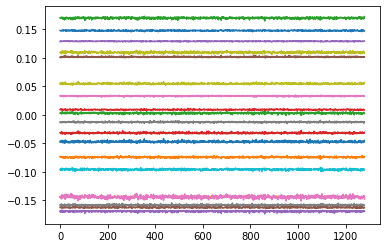

In [19]:
#tmp = torch.load(os.path.join(aug_path,"epoch_"+str(19)+".pth")).to("cpu")
aug_path = '/data0/violin/projects/mdd_practice/aug_results/wgangp_test'
tmp = torch.load(os.path.join(aug_path,"class_fold_"+str(0)+"_hc_0.pth")).to("cpu").detach().numpy()
print(tmp[0].shape)
plt.plot(np.arange(tmp[0].shape[-1]),tmp[110].T)

(19, 1280)


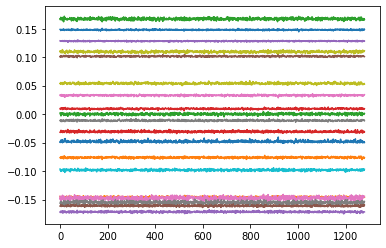

In [20]:
aug_path = '/data0/violin/projects/mdd_practice/aug_results/wgangp_test'
tmp = torch.load(os.path.join(aug_path,"class_fold_"+str(0)+"_mdd_0.pth")).to("cpu").detach().numpy()
print(tmp[0].shape)
plt.plot(np.arange(tmp[0].shape[-1]),tmp[1000].T)

1700


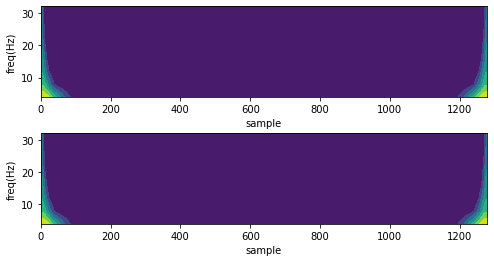

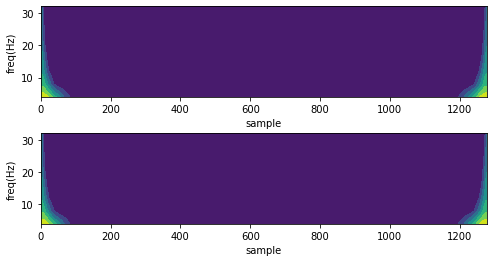

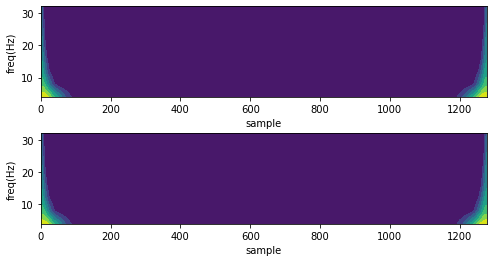

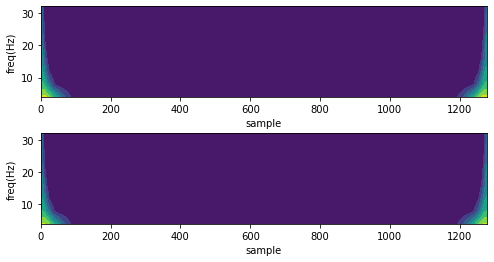

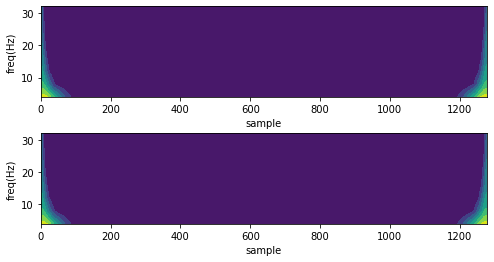

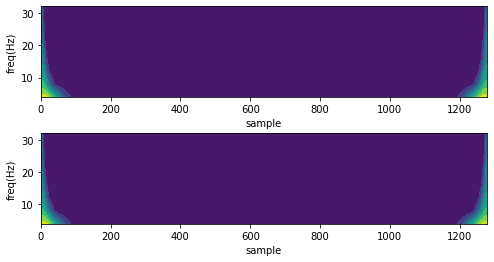

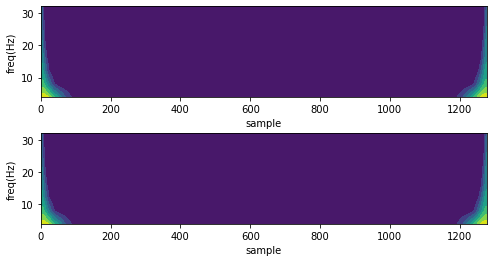

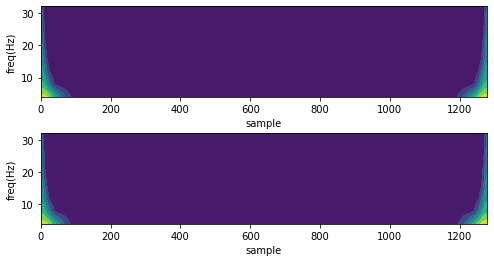

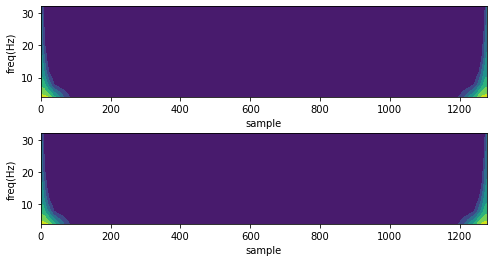

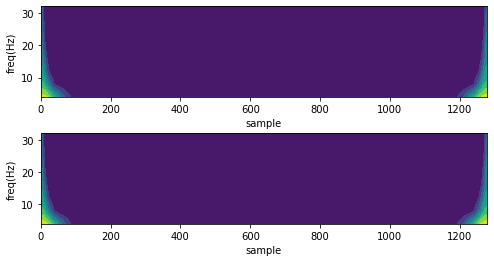

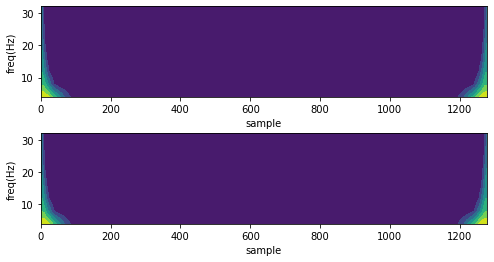

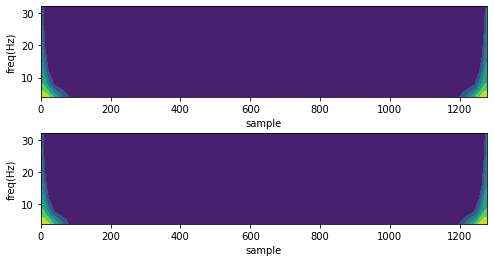

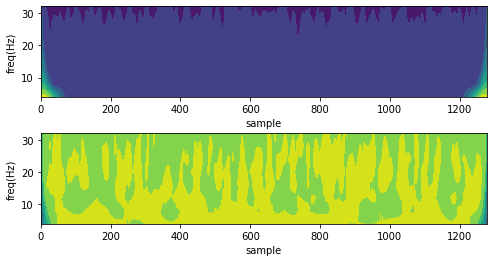

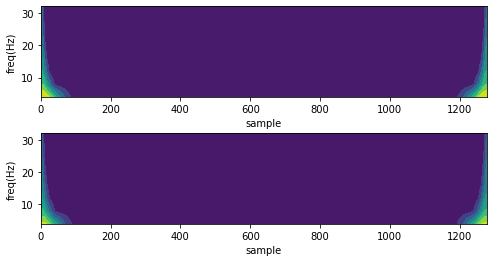

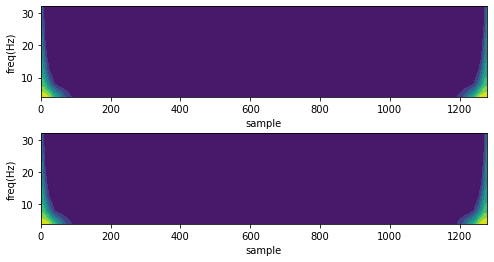

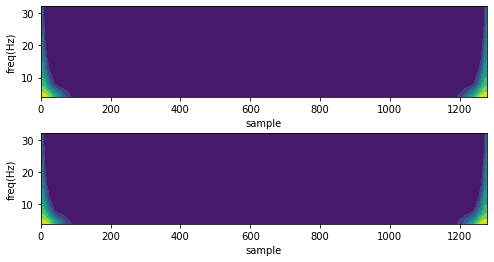

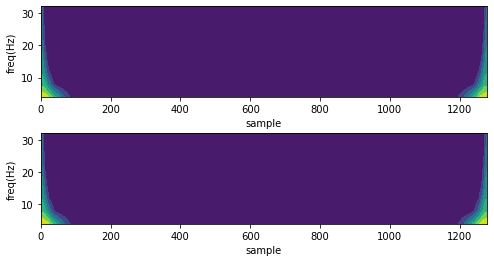

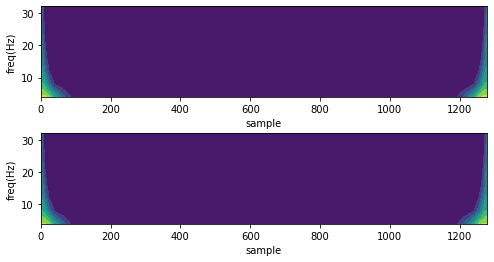

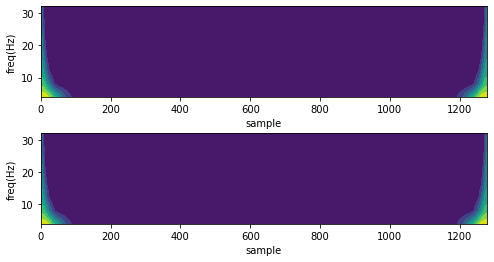

In [21]:
#cwt连续小波变换看一下结果 生成的结果
#hc_data = np.array(torch.load(os.path.join(aug_path,"step_"+str(noise_steps)+"_hc.pth")).to("cpu"))
#mdd_data = np.array(torch.load(os.path.join(aug_path,"step_"+str(noise_steps)+"_mdd.pth")).to("cpu"))
aug_path = '/data0/violin/projects/mdd_practice/aug_results/wgangp_test'
noise_steps = 1000
hc_data = np.array(torch.load(os.path.join(aug_path,"class_fold_"+str(0)+"_hc_0.pth")).to("cpu").detach().numpy())
mdd_data = np.array(torch.load(os.path.join(aug_path,"class_fold_"+str(0)+"_mdd_0.pth")).to("cpu").detach().numpy())
print(len(hc_data))
sampling_rate = 256
wavename = 'cgau8'
totalscal = 4
# 中心频率
fc = pywt.central_frequency(wavename)
# 计算对应频率的小波尺度
cparam = 8 * fc * totalscal  #这里本来是2
scales = cparam / np.arange(totalscal, 0, -0.5) #这里本来是-1
frequencies = [32.,28.,24.,20.,16.,12.,8.,4.] #计算得到

figs_hc = []
for i in range(19):
    [cwtmatr, frequencies] = pywt.cwt(hc_data[:,i], scales, wavename, 1.0 / sampling_rate)
    cwtmatr = np.array(abs(cwtmatr))#[:,:45000]
    figs_hc.append(cwtmatr)
figs_hc = np.array(figs_hc)
figs_mdd = []
for i in range(19):
    [cwtmatr, frequencies] = pywt.cwt(mdd_data[:,i], scales, wavename, 1.0 / sampling_rate)
    cwtmatr = np.array(abs(cwtmatr))#[:,:45000]
    figs_mdd.append(cwtmatr)
figs_mdd = np.array(figs_mdd)

for i in range(19):
    plt.figure(figsize=(8, 4))
    plt.subplot(211)
    t = np.arange(0, hc_data.shape[-1], 1.0)
    plt.contourf(t, frequencies, np.mean(figs_hc[i],axis=1))
    plt.ylabel(u"freq(Hz)")
    plt.xlabel(u"sample")
    plt.subplot(212)
    plt.contourf(t, frequencies, np.mean(figs_mdd[i],axis=1))
    plt.ylabel(u"freq(Hz)")
    plt.xlabel(u"sample")
    plt.subplots_adjust(hspace=0.4)
    plt.show()

## 5.2 WGAN

In [10]:
#还是需要label作为输入引导的 条件生成模型
#原数据集
#torch.autograd.set_detect_anomaly = True
hc_idxs = np.arange(1,31)  #30 hc
mdd_idxs = np.arange(1,35) #34-1=33 mdd
np.random.seed(42)
np.random.shuffle(hc_idxs)
np.random.shuffle(mdd_idxs)

n_fold = 10
n_sub = 3
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
device_1 = torch.device("cuda:1" if torch.cuda.is_available() else "cpu") #试一下 sample的时候用另一个gpu 防止爆显存
#device_1 = torch.device("cpu")
n_epoch = 10  #这里注意改！
#n_patience = 10
batch_size = 128
noise_steps = 1
pre_path_train = '/data0/violin/projects/mdd_practice/MDD_dataset/data_rest_raw'
part_train = 'REST'
part_test = 'REST'
model_path = '/data0/violin/projects/mdd_practice/models/wgan_test' #这里保存G就可以了
aug_path = '/data0/violin/projects/mdd_practice/aug_results/wgan_test'

i1 = 0
i2 = 0

for fold in range(n_fold):
    print("fold "+str(fold+1)+": ")
    hc_train_list,mdd_train_list,hc_test_list,mdd_test_list = [],[],[],[]
    for i in range(len(hc_idxs)):
        if i>=i1 and i<i1+n_sub:
            if (part_test=='EC' and hc_idxs[i] in missing_ec_hc) \
            or (part_test=='EO' and hc_idxs[i] in missing_eo_hc) : #如果没有相关数据 则往前跳一个
                i1 += 1
                continue
            hc_test_list.append(hc_idxs[i])
        else:
            hc_train_list.append(hc_idxs[i])
    for i in range(len(mdd_idxs)):
        if i>=i2 and i<i2+n_sub:
            if (part_test=='REST' and mdd_idxs[i] == 8) or (part_test=='EC' and mdd_idxs[i] in missing_ec_mdd) \
            or (part_test=='EO' and mdd_idxs[i] in missing_eo_mdd) : #如果没有相关数据 则往前跳一个
                i2 += 1
                continue
            mdd_test_list.append(mdd_idxs[i])
        else:
            mdd_train_list.append(mdd_idxs[i])
    print(hc_test_list,mdd_test_list)

    # if fold<7:
    #     i1 += n_sub
    #     i2 += n_sub
    #     continue 
    G = DiffWave(unconditional=True, residual_channels=32,max_noise_step=noise_steps,\
            n_mels=1,residual_layers=2,dilation_cycle_length=4,n_classes=2).to(device)
    optimizerG = torch.optim.RMSprop(G.parameters(), lr=1e-4)
    D = CNN_transformer_1d_wgan().to(device)
    optimizerD = torch.optim.RMSprop(D.parameters(), lr=2*1e-4)
    #logger = SummaryWriter(os.path.join("runs", args.run_name))
    train_x,train_y = load_dataset(hc_train_list,mdd_train_list,preprocess_raw,pre_path_train,True,part_train)
    train_y = train_y.long()
    #train_x = train_x.unsqueeze(2)
    # 进行归一化 很重要！逐channel来做比较好
    #channels_sca = [MinMaxScaler(feature_range=(-1.0, 1.0)) for i in range(19)]
    #好像还是标准化的结果更好一些呢
    #channels_sca = [StandardScaler() for i in range(19)]
    # train_x0 = []
    # for i in range(19):
    #     train_x0.append(channels_sca[i].fit_transform(train_x[:,i,:]))
    # train_x0 = torch.Tensor(np.array(train_x0))
    # train_x0 = train_x0.transpose(0,1)
    train_x0 = train_x

    train_data = TensorDataset(train_x0,train_y)
    dataLoader = DataLoader(train_data, batch_size = batch_size, shuffle=True)
    # early_stopping = EarlyStopping(model_path,fold,patience=n_patience, verbose=True)

    for epoch in range(n_epoch):
        logging.info(f"Starting epoch {epoch}:")
        pbar = tqdm(dataLoader)
        for i, (x,label_mdd) in enumerate(pbar):
            x = x.to(device)
            label_mdd = label_mdd.to(device)
            noise = torch.randn_like(x).to(device)
            for p in D.parameters():
                p.data.clamp_(-0.1, 0.1)
            x_fake = G(noise,torch.zeros(x.shape[0]).long().to(device),label_mdd)
            output_real = D(x,label_mdd,device)[:,1]
            output_fake = D(x_fake,label_mdd,device)[:,1]

            optimizerD.zero_grad()
            lossD = -(output_real.mean()-output_fake.mean())
            lossD.backward(retain_graph=True)
            optimizerD.step()

            #更新了一步D后 再用D的结果来更新G 且这里的标签要反着来 妙啊
            optimizerG.zero_grad()
            lossG = -D(x_fake,label_mdd,device)[:,1].mean()
            lossG.backward(retain_graph=True)
            optimizerG.step()

            if i%10 == 0:
                print('Train Epoch: {} [{}/{}]\tloss_D: {:.6f}\tloss_G: {:.6f}'.format(
                    epoch, i*len(train_x), len(dataLoader.dataset),lossD.data.cpu().numpy(),lossG.data.cpu().numpy()))

        torch.save(G.state_dict(), os.path.join(model_path,"fold_"+str(fold)+".pth"))
        # early_stopping(, epoch, model)  #以loss为early stop标准

    n_samples = 1700
    #G.load_state_dict(torch.load(os.path.join(model_path,"fold_"+str(fold)+".pth")))
    G.eval()
    G = G.to(device_1)

    for j in range(1):
        noise = torch.randn((n_samples,19,1280)).to(device_1)
        sampled_mdd = G(noise,torch.zeros(noise.shape[0]).long().to(device_1),torch.ones(noise.shape[0]).long().to(device_1)).to("cpu")#.detach().numpy()
        results = sampled_mdd
        # results = []
        # for i in range(19):
        #     results.append(channels_sca[i].inverse_transform(sampled_mdd[:,i,:]))
        # results = torch.Tensor(np.array(results)).transpose(0,1)
        torch.save(results,os.path.join(aug_path,"class_fold_"+str(fold)+"_mdd_"+str(j)+".pth"))

        noise = torch.randn((n_samples,19,1280)).to(device_1)
        sampled_hc = G(noise,torch.zeros(noise.shape[0]).long().to(device),torch.zeros(noise.shape[0]).long().to(device_1)).to("cpu")#.detach().numpy()
        results = sampled_hc
        # results = []
        # for i in range(19):
        #     results.append(channels_sca[i].inverse_transform(sampled_hc[:,i,:]))
        # results = torch.Tensor(np.array(results)).transpose(0,1)
        torch.save(results,os.path.join(aug_path,"class_fold_"+str(fold)+"_hc_"+str(j)+".pth"))


fold 1: 
[28, 16, 24] [11, 1, 24]


  0%|          | 0/99 [00:00<?, ?it/s]

Train Epoch: 0 [0/12618]	loss_D: -0.004404	loss_G: 0.051866
Train Epoch: 0 [126180/12618]	loss_D: -0.016611	loss_G: 0.070730
Train Epoch: 0 [252360/12618]	loss_D: -0.013022	loss_G: 0.057239
Train Epoch: 0 [378540/12618]	loss_D: -0.039127	loss_G: 0.065471
Train Epoch: 0 [504720/12618]	loss_D: -0.024796	loss_G: 0.077540
Train Epoch: 0 [630900/12618]	loss_D: -0.072531	loss_G: 0.093407
Train Epoch: 0 [757080/12618]	loss_D: -0.082553	loss_G: 0.088419
Train Epoch: 0 [883260/12618]	loss_D: -0.094925	loss_G: 0.121134
Train Epoch: 0 [1009440/12618]	loss_D: -0.127882	loss_G: 0.121386
Train Epoch: 0 [1135620/12618]	loss_D: -0.165613	loss_G: 0.179358


  0%|          | 0/99 [00:00<?, ?it/s]

Train Epoch: 1 [0/12618]	loss_D: -0.206032	loss_G: 0.133747
Train Epoch: 1 [126180/12618]	loss_D: -0.205144	loss_G: 0.156686
Train Epoch: 1 [252360/12618]	loss_D: -0.238455	loss_G: 0.209289
Train Epoch: 1 [378540/12618]	loss_D: -0.280343	loss_G: 0.197987
Train Epoch: 1 [504720/12618]	loss_D: -0.304639	loss_G: 0.233494
Train Epoch: 1 [630900/12618]	loss_D: -0.328284	loss_G: 0.231240
Train Epoch: 1 [757080/12618]	loss_D: -0.395591	loss_G: 0.252694
Train Epoch: 1 [883260/12618]	loss_D: -0.396851	loss_G: 0.243645
Train Epoch: 1 [1009440/12618]	loss_D: -0.426027	loss_G: 0.251833
Train Epoch: 1 [1135620/12618]	loss_D: -0.458818	loss_G: 0.319687


  0%|          | 0/99 [00:00<?, ?it/s]

Train Epoch: 2 [0/12618]	loss_D: -0.493674	loss_G: 0.261413
Train Epoch: 2 [126180/12618]	loss_D: -0.491391	loss_G: 0.319605
Train Epoch: 2 [252360/12618]	loss_D: -0.576819	loss_G: 0.320865
Train Epoch: 2 [378540/12618]	loss_D: -0.558043	loss_G: 0.308867
Train Epoch: 2 [504720/12618]	loss_D: -0.569909	loss_G: 0.306399
Train Epoch: 2 [630900/12618]	loss_D: -0.566791	loss_G: 0.337536
Train Epoch: 2 [757080/12618]	loss_D: -0.584530	loss_G: 0.349720
Train Epoch: 2 [883260/12618]	loss_D: -0.597546	loss_G: 0.343633
Train Epoch: 2 [1009440/12618]	loss_D: -0.598175	loss_G: 0.352200
Train Epoch: 2 [1135620/12618]	loss_D: -0.590347	loss_G: 0.357256


  0%|          | 0/99 [00:00<?, ?it/s]

Train Epoch: 3 [0/12618]	loss_D: -0.599648	loss_G: 0.349652
Train Epoch: 3 [126180/12618]	loss_D: -0.579748	loss_G: 0.375541
Train Epoch: 3 [252360/12618]	loss_D: -0.607984	loss_G: 0.371606
Train Epoch: 3 [378540/12618]	loss_D: -0.617971	loss_G: 0.372620
Train Epoch: 3 [504720/12618]	loss_D: -0.614764	loss_G: 0.373373
Train Epoch: 3 [630900/12618]	loss_D: -0.605609	loss_G: 0.369045
Train Epoch: 3 [757080/12618]	loss_D: -0.631601	loss_G: 0.375057
Train Epoch: 3 [883260/12618]	loss_D: -0.625836	loss_G: 0.377691
Train Epoch: 3 [1009440/12618]	loss_D: -0.628881	loss_G: 0.371914
Train Epoch: 3 [1135620/12618]	loss_D: -0.627169	loss_G: 0.358450


  0%|          | 0/99 [00:00<?, ?it/s]

Train Epoch: 4 [0/12618]	loss_D: -0.631843	loss_G: 0.377269
Train Epoch: 4 [126180/12618]	loss_D: -0.638969	loss_G: 0.367540
Train Epoch: 4 [252360/12618]	loss_D: -0.617921	loss_G: 0.373040
Train Epoch: 4 [378540/12618]	loss_D: -0.639652	loss_G: 0.370296
Train Epoch: 4 [504720/12618]	loss_D: -0.639462	loss_G: 0.379720
Train Epoch: 4 [630900/12618]	loss_D: -0.624569	loss_G: 0.383154
Train Epoch: 4 [757080/12618]	loss_D: -0.639700	loss_G: 0.366930
Train Epoch: 4 [883260/12618]	loss_D: -0.626130	loss_G: 0.372581
Train Epoch: 4 [1009440/12618]	loss_D: -0.639046	loss_G: 0.380548


## 5.3 WGAN-GP

In [16]:
def cal_gradient_penalty(disc_net, device, real, fake, label_mdd):
    """
    用于计算WGAN-GP引入的gradient penalty
    """
    # 系数alpha
    alpha = torch.rand(real.size(0),1,1)
    alpha = alpha.expand(real.size())
    alpha = alpha.to(device)

    # 按公式计算x
    interpolates = alpha * real + ((1 - alpha) * fake)

    # 为得到梯度先计算y
    interpolates = autograd.Variable(interpolates, requires_grad=True)
    disc_interpolates = disc_net(interpolates,label_mdd,device)

    # 计算梯度
    gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(disc_interpolates.size()).to(device),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]

    # 利用梯度计算出gradient penalty
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [18]:
#还是需要label作为输入引导的 条件生成模型
#原数据集
#torch.autograd.set_detect_anomaly = True
hc_idxs = np.arange(1,31)  #30 hc
mdd_idxs = np.arange(1,35) #34-1=33 mdd
np.random.seed(42)
np.random.shuffle(hc_idxs)
np.random.shuffle(mdd_idxs)

n_fold = 10
n_sub = 3
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
device_1 = torch.device("cuda:1" if torch.cuda.is_available() else "cpu") #试一下 sample的时候用另一个gpu 防止爆显存
#device_1 = torch.device("cpu")
n_epoch = 10  #这里注意改！
#n_patience = 10
batch_size = 128
noise_steps = 1
pre_path_train = '/data0/violin/projects/mdd_practice/MDD_dataset/data_rest_raw'
part_train = 'REST'
part_test = 'REST'
model_path = '/data0/violin/projects/mdd_practice/models/wgangp_test' #这里保存G就可以了
aug_path = '/data0/violin/projects/mdd_practice/aug_results/wgangp_test'

i1 = 0
i2 = 0

for fold in range(n_fold):
    print("fold "+str(fold+1)+": ")
    hc_train_list,mdd_train_list,hc_test_list,mdd_test_list = [],[],[],[]
    for i in range(len(hc_idxs)):
        if i>=i1 and i<i1+n_sub:
            if (part_test=='EC' and hc_idxs[i] in missing_ec_hc) \
            or (part_test=='EO' and hc_idxs[i] in missing_eo_hc) : #如果没有相关数据 则往前跳一个
                i1 += 1
                continue
            hc_test_list.append(hc_idxs[i])
        else:
            hc_train_list.append(hc_idxs[i])
    for i in range(len(mdd_idxs)):
        if i>=i2 and i<i2+n_sub:
            if (part_test=='REST' and mdd_idxs[i] == 8) or (part_test=='EC' and mdd_idxs[i] in missing_ec_mdd) \
            or (part_test=='EO' and mdd_idxs[i] in missing_eo_mdd) : #如果没有相关数据 则往前跳一个
                i2 += 1
                continue
            mdd_test_list.append(mdd_idxs[i])
        else:
            mdd_train_list.append(mdd_idxs[i])
    print(hc_test_list,mdd_test_list)

    if fold>0:
        i1 += n_sub
        i2 += n_sub
        continue 
    G = DiffWave(unconditional=True, residual_channels=32,max_noise_step=noise_steps,\
            n_mels=1,residual_layers=2,dilation_cycle_length=4,n_classes=2).to(device)
    optimizerG = torch.optim.RMSprop(G.parameters(), lr=1e-5)
    D = CNN_transformer_1d_wgan().to(device)
    optimizerD = torch.optim.RMSprop(D.parameters(), lr=2*1e-5)
    #logger = SummaryWriter(os.path.join("runs", args.run_name))
    train_x,train_y = load_dataset(hc_train_list,mdd_train_list,preprocess_raw,pre_path_train,True,part_train)
    train_y = train_y.long()
    #train_x = train_x.unsqueeze(2)
    # 进行归一化 很重要！逐channel来做比较好
    #channels_sca = [MinMaxScaler(feature_range=(-1.0, 1.0)) for i in range(19)]
    #好像还是标准化的结果更好一些呢
    #channels_sca = [StandardScaler() for i in range(19)]
    # train_x0 = []
    # for i in range(19):
    #     train_x0.append(channels_sca[i].fit_transform(train_x[:,i,:]))
    # train_x0 = torch.Tensor(np.array(train_x0))
    # train_x0 = train_x0.transpose(0,1)
    train_x0 = train_x

    train_data = TensorDataset(train_x0,train_y)
    dataLoader = DataLoader(train_data, batch_size = batch_size, shuffle=True)
    # early_stopping = EarlyStopping(model_path,fold,patience=n_patience, verbose=True)

    for epoch in range(n_epoch):
        logging.info(f"Starting epoch {epoch}:")
        pbar = tqdm(dataLoader)
        for i, (x,label_mdd) in enumerate(pbar):
            x = x.to(device)
            label_mdd = label_mdd.to(device)
            noise = torch.randn_like(x).to(device)
            # for p in D.parameters():
            #     p.data.clamp_(-0.1, 0.1)
            x_fake = G(noise,torch.zeros(x.shape[0]).long().to(device),label_mdd)
            output_real = D(x,label_mdd,device)[:,1]
            output_fake = D(x_fake,label_mdd,device)[:,1]

            optimizerD.zero_grad()
            gradient_penalty = cal_gradient_penalty(D, device, x.data, x_fake.data, label_mdd)
            lossD = -(output_real.mean()-output_fake.mean()) + gradient_penalty * 0.1
            lossD.backward(retain_graph=True)
            optimizerD.step()

            #更新了一步D后 再用D的结果来更新G 且这里的标签要反着来 妙啊
            optimizerG.zero_grad()
            lossG = -D(x_fake,label_mdd,device)[:,1].mean()
            lossG.backward(retain_graph=True)
            optimizerG.step()

            if i%10 == 0:
                print('Train Epoch: {} [{}/{}]\tloss_D: {:.6f}\tloss_G: {:.6f}'.format(
                    epoch, i*len(train_x), len(dataLoader.dataset),lossD.data.cpu().numpy(),lossG.data.cpu().numpy()))

        torch.save(G.state_dict(), os.path.join(model_path,"fold_"+str(fold)+".pth"))
        # early_stopping(, epoch, model)  #以loss为early stop标准

    n_samples = 1700
    #G.load_state_dict(torch.load(os.path.join(model_path,"fold_"+str(fold)+".pth")))
    G.eval()
    G = G.to(device_1)

    for j in range(1):
        noise = torch.randn((n_samples,19,1280)).to(device_1)
        sampled_mdd = G(noise,torch.zeros(noise.shape[0]).long().to(device_1),torch.ones(noise.shape[0]).long().to(device_1)).to("cpu")#.detach().numpy()
        results = sampled_mdd
        # results = []
        # for i in range(19):
        #     results.append(channels_sca[i].inverse_transform(sampled_mdd[:,i,:]))
        # results = torch.Tensor(np.array(results)).transpose(0,1)
        torch.save(results,os.path.join(aug_path,"class_fold_"+str(fold)+"_mdd_"+str(j)+".pth"))

        noise = torch.randn((n_samples,19,1280)).to(device_1)
        sampled_hc = G(noise,torch.zeros(noise.shape[0]).long().to(device),torch.zeros(noise.shape[0]).long().to(device_1)).to("cpu")#.detach().numpy()
        results = sampled_hc
        # results = []
        # for i in range(19):
        #     results.append(channels_sca[i].inverse_transform(sampled_hc[:,i,:]))
        # results = torch.Tensor(np.array(results)).transpose(0,1)
        torch.save(results,os.path.join(aug_path,"class_fold_"+str(fold)+"_hc_"+str(j)+".pth"))


fold 1: 
[28, 16, 24] [11, 1, 24]


  0%|          | 0/99 [00:00<?, ?it/s]

Train Epoch: 0 [0/12618]	loss_D: 0.387899	loss_G: -0.470643
Train Epoch: 0 [126180/12618]	loss_D: 0.104160	loss_G: -0.535977
Train Epoch: 0 [252360/12618]	loss_D: 0.084632	loss_G: -0.483226
Train Epoch: 0 [378540/12618]	loss_D: 0.042169	loss_G: -0.484388
Train Epoch: 0 [504720/12618]	loss_D: 0.062903	loss_G: -0.459996
Train Epoch: 0 [630900/12618]	loss_D: 0.009965	loss_G: -0.499902
Train Epoch: 0 [757080/12618]	loss_D: 0.033577	loss_G: -0.509270
Train Epoch: 0 [883260/12618]	loss_D: 0.237467	loss_G: -0.514821
Train Epoch: 0 [1009440/12618]	loss_D: 0.067270	loss_G: -0.452964
Train Epoch: 0 [1135620/12618]	loss_D: 0.138596	loss_G: -0.420303


  0%|          | 0/99 [00:00<?, ?it/s]

Train Epoch: 1 [0/12618]	loss_D: -0.004690	loss_G: -0.575455
Train Epoch: 1 [126180/12618]	loss_D: 0.019151	loss_G: -0.513839
Train Epoch: 1 [252360/12618]	loss_D: 0.055288	loss_G: -0.502338
Train Epoch: 1 [378540/12618]	loss_D: -0.006334	loss_G: -0.436395
Train Epoch: 1 [504720/12618]	loss_D: -0.007142	loss_G: -0.477105
Train Epoch: 1 [630900/12618]	loss_D: 0.055410	loss_G: -0.391498
Train Epoch: 1 [757080/12618]	loss_D: 0.109388	loss_G: -0.484507
Train Epoch: 1 [883260/12618]	loss_D: -0.030303	loss_G: -0.484498
Train Epoch: 1 [1009440/12618]	loss_D: 0.079146	loss_G: -0.523772
Train Epoch: 1 [1135620/12618]	loss_D: 0.162649	loss_G: -0.442797


  0%|          | 0/99 [00:00<?, ?it/s]

Train Epoch: 2 [0/12618]	loss_D: 0.068159	loss_G: -0.545354
Train Epoch: 2 [126180/12618]	loss_D: 0.070456	loss_G: -0.516124
Train Epoch: 2 [252360/12618]	loss_D: 0.126075	loss_G: -0.441781
Train Epoch: 2 [378540/12618]	loss_D: 0.068064	loss_G: -0.597400
Train Epoch: 2 [504720/12618]	loss_D: 0.078164	loss_G: -0.431478
Train Epoch: 2 [630900/12618]	loss_D: 0.032089	loss_G: -0.467510
Train Epoch: 2 [757080/12618]	loss_D: 0.062896	loss_G: -0.491330
Train Epoch: 2 [883260/12618]	loss_D: -0.046687	loss_G: -0.501401
Train Epoch: 2 [1009440/12618]	loss_D: -0.093051	loss_G: -0.492559
Train Epoch: 2 [1135620/12618]	loss_D: 0.106443	loss_G: -0.549782


  0%|          | 0/99 [00:00<?, ?it/s]

Train Epoch: 3 [0/12618]	loss_D: 0.066162	loss_G: -0.439735
Train Epoch: 3 [126180/12618]	loss_D: 0.032521	loss_G: -0.486558
Train Epoch: 3 [252360/12618]	loss_D: 0.144477	loss_G: -0.451301
Train Epoch: 3 [378540/12618]	loss_D: 0.046909	loss_G: -0.447438
Train Epoch: 3 [504720/12618]	loss_D: 0.071821	loss_G: -0.475233
Train Epoch: 3 [630900/12618]	loss_D: 0.086054	loss_G: -0.507578
Train Epoch: 3 [757080/12618]	loss_D: 0.050831	loss_G: -0.523198
Train Epoch: 3 [883260/12618]	loss_D: -0.071615	loss_G: -0.488683
Train Epoch: 3 [1009440/12618]	loss_D: -0.009542	loss_G: -0.516511
Train Epoch: 3 [1135620/12618]	loss_D: 0.092425	loss_G: -0.594043


  0%|          | 0/99 [00:00<?, ?it/s]

Train Epoch: 4 [0/12618]	loss_D: 0.083370	loss_G: -0.452523
Train Epoch: 4 [126180/12618]	loss_D: 0.040225	loss_G: -0.544977
Train Epoch: 4 [252360/12618]	loss_D: 0.028354	loss_G: -0.444349
Train Epoch: 4 [378540/12618]	loss_D: 0.005188	loss_G: -0.320984
Train Epoch: 4 [504720/12618]	loss_D: 0.127429	loss_G: -0.530881
Train Epoch: 4 [630900/12618]	loss_D: 0.102067	loss_G: -0.420226
Train Epoch: 4 [757080/12618]	loss_D: -0.122067	loss_G: -0.523070
Train Epoch: 4 [883260/12618]	loss_D: -0.243978	loss_G: -0.380962
Train Epoch: 4 [1009440/12618]	loss_D: -0.165082	loss_G: -0.415964
Train Epoch: 4 [1135620/12618]	loss_D: -0.066782	loss_G: -0.422378


  0%|          | 0/99 [00:00<?, ?it/s]

Train Epoch: 5 [0/12618]	loss_D: -0.154740	loss_G: -0.435594
Train Epoch: 5 [126180/12618]	loss_D: -0.101755	loss_G: -0.405573
Train Epoch: 5 [252360/12618]	loss_D: -0.197382	loss_G: -0.458979
Train Epoch: 5 [378540/12618]	loss_D: -0.061665	loss_G: -0.558594
Train Epoch: 5 [504720/12618]	loss_D: -0.160786	loss_G: -0.403762
Train Epoch: 5 [630900/12618]	loss_D: -0.055619	loss_G: -0.445596
Train Epoch: 5 [757080/12618]	loss_D: -0.266164	loss_G: -0.550068
Train Epoch: 5 [883260/12618]	loss_D: -0.047191	loss_G: -0.481150
Train Epoch: 5 [1009440/12618]	loss_D: 0.120348	loss_G: -0.509654
Train Epoch: 5 [1135620/12618]	loss_D: -0.060765	loss_G: -0.359142


  0%|          | 0/99 [00:00<?, ?it/s]

Train Epoch: 6 [0/12618]	loss_D: 0.080862	loss_G: -0.448900
Train Epoch: 6 [126180/12618]	loss_D: -0.072552	loss_G: -0.344591
Train Epoch: 6 [252360/12618]	loss_D: -0.147423	loss_G: -0.432502
Train Epoch: 6 [378540/12618]	loss_D: -0.200159	loss_G: -0.430762
Train Epoch: 6 [504720/12618]	loss_D: -0.115368	loss_G: -0.430773
Train Epoch: 6 [630900/12618]	loss_D: 0.048666	loss_G: -0.348996
Train Epoch: 6 [757080/12618]	loss_D: -0.188796	loss_G: -0.381286
Train Epoch: 6 [883260/12618]	loss_D: -0.021418	loss_G: -0.467616
Train Epoch: 6 [1009440/12618]	loss_D: -0.147921	loss_G: -0.395240
Train Epoch: 6 [1135620/12618]	loss_D: 0.060199	loss_G: -0.498191


  0%|          | 0/99 [00:00<?, ?it/s]

Train Epoch: 7 [0/12618]	loss_D: -0.010198	loss_G: -0.357780
Train Epoch: 7 [126180/12618]	loss_D: -0.077083	loss_G: -0.444287
Train Epoch: 7 [252360/12618]	loss_D: -0.025405	loss_G: -0.426671
Train Epoch: 7 [378540/12618]	loss_D: -0.114724	loss_G: -0.445141
Train Epoch: 7 [504720/12618]	loss_D: -0.039277	loss_G: -0.423304
Train Epoch: 7 [630900/12618]	loss_D: -0.065464	loss_G: -0.290970
Train Epoch: 7 [757080/12618]	loss_D: -0.254113	loss_G: -0.349109
Train Epoch: 7 [883260/12618]	loss_D: -0.172035	loss_G: -0.460529
Train Epoch: 7 [1009440/12618]	loss_D: -0.079897	loss_G: -0.436645
Train Epoch: 7 [1135620/12618]	loss_D: -0.222621	loss_G: -0.411097


  0%|          | 0/99 [00:00<?, ?it/s]

Train Epoch: 8 [0/12618]	loss_D: -0.165309	loss_G: -0.439814
Train Epoch: 8 [126180/12618]	loss_D: -0.411229	loss_G: -0.354420
Train Epoch: 8 [252360/12618]	loss_D: -0.152363	loss_G: -0.446375
Train Epoch: 8 [378540/12618]	loss_D: -0.355977	loss_G: -0.510106
Train Epoch: 8 [504720/12618]	loss_D: -0.102144	loss_G: -0.236872
Train Epoch: 8 [630900/12618]	loss_D: -0.071610	loss_G: -0.520839
Train Epoch: 8 [757080/12618]	loss_D: -0.172852	loss_G: -0.407338
Train Epoch: 8 [883260/12618]	loss_D: 0.110951	loss_G: -0.428406
Train Epoch: 8 [1009440/12618]	loss_D: -0.366458	loss_G: -0.468220
Train Epoch: 8 [1135620/12618]	loss_D: -0.203404	loss_G: -0.387925


  0%|          | 0/99 [00:00<?, ?it/s]

Train Epoch: 9 [0/12618]	loss_D: -0.167037	loss_G: -0.295564
Train Epoch: 9 [126180/12618]	loss_D: -0.160000	loss_G: -0.438826
Train Epoch: 9 [252360/12618]	loss_D: -0.147930	loss_G: -0.306513
Train Epoch: 9 [378540/12618]	loss_D: -0.316532	loss_G: -0.343612
Train Epoch: 9 [504720/12618]	loss_D: -0.081423	loss_G: -0.293401
Train Epoch: 9 [630900/12618]	loss_D: -0.155182	loss_G: -0.356014
Train Epoch: 9 [757080/12618]	loss_D: -0.402760	loss_G: -0.223487
Train Epoch: 9 [883260/12618]	loss_D: -0.231635	loss_G: -0.302641
Train Epoch: 9 [1009440/12618]	loss_D: -0.421319	loss_G: -0.496841
Train Epoch: 9 [1135620/12618]	loss_D: -0.211542	loss_G: -0.340988
fold 2: 
[28, 16, 24] [1, 24, 6]
fold 3: 
[18, 9, 10] [22, 17, 13]
fold 4: 
[29, 25, 13] [26, 29, 33]
fold 5: 
[1, 5, 17] [10, 2, 14]
fold 6: 
[6, 14, 12] [27, 25, 4]
fold 7: 
[23, 2, 3] [18, 21, 9]
fold 8: 
[26, 4, 22] [7, 34, 5]
fold 9: 
[27, 19, 30] [3, 20, 23]
fold 10: 
[21, 8, 11] [12, 19, 32]


# 6.模型定义（分类用）

## 6.1 MDDNet(暂弃用 未发表 时域+频域 multi-view attention)

In [5]:
#CNN part
class CNN_1d_module(nn.Module):
    def __init__(self,n_dim):
        super().__init__()
        self.model1 = nn.Sequential(  #括号不能乱空行！
            nn.MaxPool1d(5), #下采样
            nn.BatchNorm1d(n_dim),
            nn.Conv1d(n_dim,16,10), #input_n,kernel_n,kernel_size
            nn.ReLU(),
            nn.MaxPool1d(5),
            nn.BatchNorm1d(16),
            nn.Conv1d(16,32,20,1,1), #padding=1
            nn.ReLU(),
            )# nn.MaxPool1d(3),
            # nn.Flatten(),
            # nn.Linear(320,32))

        # self.model2 = nn.Sequential(
        #     nn.Linear(736,1),  #这个维度是跟着前面的kernel走的
        #     nn.Sigmoid())

    def forward(self,x):
        x = self.model1(x)
        #print(x.shape)
        # x = self.model2(x)
        return x


In [6]:
#self-attention transformer part
class SelfAttention(nn.Module):
	def __init__(self, embed_size, heads):
		super().__init__()
		self.embed_size = embed_size
		self.heads = heads
		self.head_dim = embed_size // heads

		assert (self.head_dim * heads == embed_size), "Embed size needs to be div by heads"

		self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
		self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
		self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
		self.fc_out = nn.Linear(heads * self.head_dim, embed_size)

	def forward(self, values, keys, query, mask):
		N = query.shape[0]
		value_len , key_len , query_len = values.shape[1], keys.shape[1], query.shape[1]

		# split embedding into self.heads pieces
		values = values.reshape(N, value_len, self.heads, self.head_dim)
		keys = keys.reshape(N, key_len, self.heads, self.head_dim)
		queries = query.reshape(N, query_len, self.heads, self.head_dim)
		
		values = self.values(values)
		keys = self.keys(keys)
		queries = self.queries(queries)

		energy = torch.einsum("nqhd,nkhd->nhqk", queries, keys)
		# queries shape: (N, query_len, heads, heads_dim)
		# keys shape : (N, key_len, heads, heads_dim)
		# energy shape: (N, heads, query_len, key_len)

		if mask is not None:
			energy = energy.masked_fill(mask == 0, float("-1e20"))

		attention = torch.softmax(energy/ (self.embed_size ** (1/2)), dim=3)

		out = torch.einsum("nhql, nlhd->nqhd", [attention, values]).reshape(N, query_len, self.heads*self.head_dim)
		# attention shape: (N, heads, query_len, key_len)
		# values shape: (N, value_len, heads, heads_dim)
		# (N, query_len, heads, head_dim)

		out = self.fc_out(out)
		return out


class TransformerBlock(nn.Module):
	def __init__(self, embed_size, heads, dropout, forward_expansion):
		super().__init__()
		self.attention = SelfAttention(embed_size, heads)
		self.norm1 = nn.LayerNorm(embed_size)
		self.norm2 = nn.LayerNorm(embed_size)

		self.feed_forward = nn.Sequential(
			nn.Linear(embed_size, forward_expansion*embed_size),
			nn.ReLU(),
			nn.Linear(forward_expansion*embed_size, embed_size)
		)
		self.dropout = nn.Dropout(dropout)

	def forward(self, value, key, query, mask=None):
		attention = self.attention(value, key, query, mask)

		x = self.dropout(self.norm1(attention + query))
		forward = self.feed_forward(x)
		out = self.dropout(self.norm2(forward + x))
		return out

In [7]:
#先不搞kernel的不同 先搞CNN+俩transformer（channel、time）
#F Fp T C O P
#奇数 偶数 中央
#19个通道的位置 按脑区+左右的关系来编码
channel_id = [[1,1],[0,1],[3,1],[5,1],[4,1],[0,1],[2,1],[2,1],[0,0],[1,2],[0,2],[3,2],[5,2],[4,2],[0,2],[2,2],[2,2],[3,0],[5,0]]
class MergeModel(nn.Module):
    def __init__(self,n_dim):
        super().__init__()
        self.CNN_1d_module = CNN_1d_module(1)
        self.time_embedding = nn.Embedding(32,32)
        self.drop_out = nn.Dropout(0.5)
        #self.channel_embedding = nn.Embedding(n_dim,32) 
        #编码方式2
        self.channel_embedding_1 = nn.Embedding(19,16) 
        self.channel_embedding_2 = nn.Embedding(19,16) 
        self.attention_module_ch = TransformerBlock(32,4,0.5,32) #embed_size,num_heads,drop_out,next_size
        self.attention_module_tm = TransformerBlock(32,4,0.5,32) 
        self.attention_layer = nn.Linear(32,1) #channel间attention
        # self.fc1 = nn.Sequential(
        #     nn.Linear(30,32),  #这个维度是跟着前面的输出走的
        #     nn.ReLU())
        # self.fc2 = nn.Sequential(
        #     nn.Linear(32,1),  #这个维度是跟着前面的输出走的
        #     nn.Sigmoid())

    def forward(self,x,device):
        cnn_part_x = []
        for i in range(x.shape[1]): #逐个channel来做CNN
            part = self.CNN_1d_module(x[:,i]) 
            part = part.transpose(1,2) #batch_size*time*dim
            t = self.time_embedding(torch.IntTensor([i for i in range(part.shape[1])]).to(device))
            part = part+t
            part = self.drop_out(part)
            # print(part.shape)
            part = self.attention_module_tm(part,part,part)
            #part = self.fc1(part)
            part = part[:,-1,:] #取最后一个时间维度
            # part = self.fc1(part)
            #part = torch.mean(part,-1)
            # print(part.shape) #128,32
            #t = self.channel_embedding(torch.IntTensor([i]* x.shape[0]).to(device))
            #编码方式2
            t = torch.cat((self.channel_embedding_1(torch.IntTensor([channel_id[i][0]]* x.shape[0]).to(device)),\
            self.channel_embedding_2(torch.IntTensor([channel_id[i][1]]* x.shape[0]).to(device))),dim=1)
            part = part+t 
            # part = self.drop_out(part)
            
            #这里应该会自动传播吧 
            cnn_part_x.append(part) 

        cnn_x = torch.stack(cnn_part_x,dim=1) #第0维应该是batch_size吧
        #print(cnn_x.shape) #batch_size*channel*dim
        output = self.attention_module_ch(cnn_x,cnn_x,cnn_x)
        #output = self.fc1(output).squeeze(-1)
        #output = output.sum(axis=[1],keepdim=False)
        atten_score = F.softmax(self.attention_layer(output),dim=1) #batch_size*channel*1
        output = torch.bmm(atten_score.transpose(1,2),output).squeeze(1) #batch_size*1*dim
        # output = self.fc2(output).squeeze(-1)
        return output

class MergeModel_f(nn.Module):
    def __init__(self,n_dim):
        super().__init__()
        self.CNN_1d_module = CNN_1d_module(1)
        self.time_embedding = nn.Embedding(32,32)
        self.drop_out = nn.Dropout(0.5)
        # self.channel_embedding = nn.Embedding(n_dim,32) 
        #编码方式2
        self.channel_embedding_1 = nn.Embedding(19,16) 
        self.channel_embedding_2 = nn.Embedding(19,16) 
        self.attention_module_ch = TransformerBlock(32,4,0.5,32) #embed_size,num_heads,drop_out,next_size
        self.attention_module_tm = TransformerBlock(32,4,0.5,32) 
        self.attention_layer = nn.Linear(32,1) #channel间attention
        # self.fc1 = nn.Sequential(
        #     nn.Linear(30,32),  #这个维度是跟着前面的输出走的
        #     nn.ReLU())
        # self.fc2 = nn.Sequential(
        #     nn.Linear(32,1),  #这个维度是跟着前面的输出走的
        #     nn.Sigmoid())

    def forward(self,x,device):
        cnn_part_x = []
        for i in range(x.shape[1]): #逐个channel来做CNN
            part = self.CNN_1d_module(x[:,i]) 
            part = part.transpose(1,2) #batch_size*time*dim
            t = self.time_embedding(torch.IntTensor([i for i in range(part.shape[1])]).to(device))
            part = part+t
            part = self.drop_out(part)
            # print(part.shape)
            part = self.attention_module_tm(part,part,part)
            #part = self.fc1(part)
            part = part[:,0,:] #取第一个频率
            # part = self.fc1(part)
            #part = torch.mean(part,-1)
            # print(part.shape) #128,32
            #t = self.channel_embedding(torch.IntTensor([i]* x.shape[0]).to(device))
            #编码方式2
            t = torch.cat((self.channel_embedding_1(torch.IntTensor([channel_id[i][0]]* x.shape[0]).to(device)),\
            self.channel_embedding_2(torch.IntTensor([channel_id[i][1]]* x.shape[0]).to(device))),dim=1)
            part = part+t 
            # part = self.drop_out(part)
            
            #这里应该会自动传播吧 
            cnn_part_x.append(part) 

        cnn_x = torch.stack(cnn_part_x,dim=1) #第0维应该是batch_size吧
        #print(cnn_x.shape) #batch_size*channel*dim
        output = self.attention_module_ch(cnn_x,cnn_x,cnn_x)
        #output = self.fc1(output).squeeze(-1)
        #output = output.sum(axis=[1],keepdim=False)
        atten_score = F.softmax(self.attention_layer(output),dim=1) #batch_size*channel*1
        output = torch.bmm(atten_score.transpose(1,2),output).squeeze(1) #batch_size*1*dim
        # output = self.fc2(output).squeeze(-1)
        return output


In [ ]:
#无法分区 129通道 直接embedding上
channel_id = [[1,1],[0,1],[3,1],[5,1],[4,1],[0,1],[2,1],[2,1],[0,0],[1,2],[0,2],[3,2],[5,2],[4,2],[0,2],[2,2],[2,2],[3,0],[5,0]]
class MergeModel(nn.Module):
    def __init__(self,n_dim):
        super().__init__()
        self.CNN_1d_module = CNN_1d_module(1)
        self.time_embedding = nn.Embedding(32,32)
        self.drop_out = nn.Dropout(0.5)
        self.channel_embedding = nn.Embedding(n_dim,32) 
        #编码方式2
        # self.channel_embedding_1 = nn.Embedding(19,16) 
        # self.channel_embedding_2 = nn.Embedding(19,16) 
        self.attention_module_ch = TransformerBlock(32,4,0.5,32) #embed_size,num_heads,drop_out,next_size
        self.attention_module_tm = TransformerBlock(32,4,0.5,32) 
        self.attention_layer = nn.Linear(32,1) #channel间attention
        # self.fc1 = nn.Sequential(
        #     nn.Linear(30,32),  #这个维度是跟着前面的输出走的
        #     nn.ReLU())
        # self.fc2 = nn.Sequential(
        #     nn.Linear(32,1),  #这个维度是跟着前面的输出走的
        #     nn.Sigmoid())

    def forward(self,x,device):
        cnn_part_x = []
        for i in range(x.shape[1]): #逐个channel来做CNN
            part = self.CNN_1d_module(x[:,i]) 
            part = part.transpose(1,2) #batch_size*time*dim
            t = self.time_embedding(torch.IntTensor([i for i in range(part.shape[1])]).to(device))
            part = part+t
            part = self.drop_out(part)
            # print(part.shape)
            part = self.attention_module_tm(part,part,part)
            #part = self.fc1(part)
            part = part[:,-1,:] #取最后一个时间维度
            # part = self.fc1(part)
            #part = torch.mean(part,-1)
            # print(part.shape) #128,32
            t = self.channel_embedding(torch.IntTensor([i]* x.shape[0]).to(device))
            #编码方式2
            # t = torch.cat((self.channel_embedding_1(torch.IntTensor([channel_id[i][0]]* x.shape[0]).to(device)),\
            # self.channel_embedding_2(torch.IntTensor([channel_id[i][1]]* x.shape[0]).to(device))),dim=1)
            part = part+t 
            # part = self.drop_out(part)
            
            #这里应该会自动传播吧 
            cnn_part_x.append(part) 

        cnn_x = torch.stack(cnn_part_x,dim=1) #第0维应该是batch_size吧
        #print(cnn_x.shape) #batch_size*channel*dim
        output = self.attention_module_ch(cnn_x,cnn_x,cnn_x)
        #output = self.fc1(output).squeeze(-1)
        #output = output.sum(axis=[1],keepdim=False)
        atten_score = F.softmax(self.attention_layer(output),dim=1) #batch_size*channel*1
        output = torch.bmm(atten_score.transpose(1,2),output).squeeze(1) #batch_size*1*dim
        # output = self.fc2(output).squeeze(-1)
        return output

class MergeModel_f(nn.Module):
    def __init__(self,n_dim):
        super().__init__()
        self.CNN_1d_module = CNN_1d_module(1)
        self.time_embedding = nn.Embedding(32,32)
        self.drop_out = nn.Dropout(0.5)
        self.channel_embedding = nn.Embedding(n_dim,32) 
        #编码方式2
        # self.channel_embedding_1 = nn.Embedding(19,16) 
        # self.channel_embedding_2 = nn.Embedding(19,16) 
        self.attention_module_ch = TransformerBlock(32,4,0.5,32) #embed_size,num_heads,drop_out,next_size
        self.attention_module_tm = TransformerBlock(32,4,0.5,32) 
        self.attention_layer = nn.Linear(32,1) #channel间attention
        # self.fc1 = nn.Sequential(
        #     nn.Linear(30,32),  #这个维度是跟着前面的输出走的
        #     nn.ReLU())
        # self.fc2 = nn.Sequential(
        #     nn.Linear(32,1),  #这个维度是跟着前面的输出走的
        #     nn.Sigmoid())

    def forward(self,x,device):
        cnn_part_x = []
        for i in range(x.shape[1]): #逐个channel来做CNN
            part = self.CNN_1d_module(x[:,i]) 
            part = part.transpose(1,2) #batch_size*time*dim
            t = self.time_embedding(torch.IntTensor([i for i in range(part.shape[1])]).to(device))
            part = part+t
            part = self.drop_out(part)
            # print(part.shape)
            part = self.attention_module_tm(part,part,part)
            #part = self.fc1(part)
            part = part[:,0,:] #取第一个频率
            # part = self.fc1(part)
            #part = torch.mean(part,-1)
            # print(part.shape) #128,32
            t = self.channel_embedding(torch.IntTensor([i]* x.shape[0]).to(device))
            #编码方式2
            # t = torch.cat((self.channel_embedding_1(torch.IntTensor([channel_id[i][0]]* x.shape[0]).to(device)),\
            # self.channel_embedding_2(torch.IntTensor([channel_id[i][1]]* x.shape[0]).to(device))),dim=1)
            part = part+t 
            # part = self.drop_out(part)
            
            #这里应该会自动传播吧 
            cnn_part_x.append(part) 

        cnn_x = torch.stack(cnn_part_x,dim=1) #第0维应该是batch_size吧
        #print(cnn_x.shape) #batch_size*channel*dim
        output = self.attention_module_ch(cnn_x,cnn_x,cnn_x)
        #output = self.fc1(output).squeeze(-1)
        #output = output.sum(axis=[1],keepdim=False)
        atten_score = F.softmax(self.attention_layer(output),dim=1) #batch_size*channel*1
        output = torch.bmm(atten_score.transpose(1,2),output).squeeze(1) #batch_size*1*dim
        # output = self.fc2(output).squeeze(-1)
        return output


In [8]:
#+频域attention融合
class MergeModelModal(nn.Module):
    def __init__(self):
        super().__init__()
        self.model_t = MergeModel(129)
        self.model_f = MergeModel_f(129)
        self.attention_layer = nn.Linear(32,1) #channel间attention
        self.fc = nn.Sequential(
        nn.Linear(32,1),  #这个维度是跟着前面的输出走的
        nn.Sigmoid()) 
    def forward(self,x1,x2,device):
        part_1 = self.model_t(x1,device)
        part_2 = self.model_f(x2,device)
        output = torch.stack([part_1,part_2],dim=1)
        atten_score = F.softmax(self.attention_layer(output),dim=1) #batch_size*channel*1
        output = torch.bmm(atten_score.transpose(1,2),output).squeeze(1) #batch_size*1*dim
        output = self.fc(output).squeeze(-1)
        return output

## 6.2 1D CNN-Transformer

In [7]:
#CNN part
class CNN_1d_module(nn.Module):
    def __init__(self,n_dim):
        super().__init__()
        self.model1 = nn.Sequential(  
            nn.MaxPool1d(5), 
            nn.BatchNorm1d(n_dim),
            nn.Conv1d(n_dim,16,10), #input_n,kernel_n,kernel_size
            nn.ReLU(),
            nn.MaxPool1d(5),
            nn.BatchNorm1d(16),
            nn.Conv1d(16,32,20,1,1), #padding=1
            nn.ReLU())


    def forward(self,x):
        x = self.model1(x)
        return x
    
class SelfAttention(nn.Module):
	def __init__(self, embed_size, heads):
		super().__init__()
		self.embed_size = embed_size
		self.heads = heads
		self.head_dim = embed_size // heads

		assert (self.head_dim * heads == embed_size), "Embed size needs to be div by heads"

		self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
		self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
		self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
		self.fc_out = nn.Linear(heads * self.head_dim, embed_size)

	def forward(self, values, keys, query, mask):
		N = query.shape[0]
		value_len , key_len , query_len = values.shape[1], keys.shape[1], query.shape[1]

		# split embedding into self.heads pieces
		values = values.reshape(N, value_len, self.heads, self.head_dim)
		keys = keys.reshape(N, key_len, self.heads, self.head_dim)
		queries = query.reshape(N, query_len, self.heads, self.head_dim)
		
		values = self.values(values)
		keys = self.keys(keys)
		queries = self.queries(queries)

		energy = torch.einsum("nqhd,nkhd->nhqk", queries, keys)
		# queries shape: (N, query_len, heads, heads_dim)
		# keys shape : (N, key_len, heads, heads_dim)
		# energy shape: (N, heads, query_len, key_len)

		if mask is not None:
			energy = energy.masked_fill(mask == 0, float("-1e20"))

		attention = torch.softmax(energy/ (self.embed_size ** (1/2)), dim=3)

		out = torch.einsum("nhql, nlhd->nqhd", [attention, values]).reshape(N, query_len, self.heads*self.head_dim)
		# attention shape: (N, heads, query_len, key_len)
		# values shape: (N, value_len, heads, heads_dim)
		# (N, query_len, heads, head_dim)

		out = self.fc_out(out)
		return out


class TransformerBlock(nn.Module):
	def __init__(self, embed_size, heads, dropout, forward_expansion):
		super().__init__()
		self.attention = SelfAttention(embed_size, heads)
		self.norm1 = nn.LayerNorm(embed_size)
		self.norm2 = nn.LayerNorm(embed_size)

		self.feed_forward = nn.Sequential(
			nn.Linear(embed_size, forward_expansion*embed_size),
			nn.ReLU(),
			nn.Linear(forward_expansion*embed_size, embed_size)
		)
		self.dropout = nn.Dropout(dropout)

	def forward(self, value, key, query, mask=None):
		attention = self.attention(value, key, query, mask)
		x = self.dropout(self.norm1(attention + query))
		forward = self.feed_forward(x)
		out = self.dropout(self.norm2(forward + x))
		return out

#注意 这里最后一层需要concat一个代表timestamp(加噪)的向量
class CNN_transformer_1d(nn.Module):
    def __init__(self,max_timestamp):       
        super().__init__()
        self.CNN_1d_module = CNN_1d_module(19)
        self.time_embedding = nn.Embedding(32,32)
        self.drop_out = nn.Dropout(0.5)
        self.attention_module_tm = TransformerBlock(32,4,0.5,32) 
        # self.fc2 = nn.Sequential(
        #     nn.Linear(32,1), 
        #     nn.Sigmoid())
        self.fc2 = nn.Sequential(
            nn.Linear(64,2), 
            nn.Softmax(dim=-1))
        self.time_noise_embedding = nn.Embedding(max_timestamp,32)

    def forward(self,x,t_noise,device):
        x = x.squeeze(2)
        part = self.CNN_1d_module(x) 
        part = part.transpose(1,2) #batch_size*time*dim
        t = self.time_embedding(torch.IntTensor([i for i in range(part.shape[1])]).to(device))
        part = part+t
        part = self.drop_out(part)
        # print(part.shape)
        part = self.attention_module_tm(part,part,part)
        #part = self.fc1(part)
        part = part[:,-1,:] #last step
        t_noise_emb = self.time_noise_embedding(t_noise)
        part = torch.cat([part,t_noise_emb],dim=1)
        part = self.fc2(part)
        return part



# 7.训练与测试

In [7]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, save_path, n_fold, patience=3, verbose=False, delta=0):
        """
        Args:
            save_path : 模型保存文件夹
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.save_path = save_path
        self.n_fold = n_fold #是进行到第几折
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.best_epoch = 0 #最佳的epoch
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, n_epoch, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, n_epoch, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, n_epoch, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, n_epoch, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        path = os.path.join(self.save_path, ('best_network_'+str(self.n_fold)+'.pth'))
        torch.save(model.state_dict(), path)	# 这里会存储迄今最优模型的参数
        self.val_loss_min = val_loss
        self.best_epoch = n_epoch


## 7.1 时域+频域（最后一层特征融合）

### 7.1.1 原数据集

In [ ]:
#原数据集
hc_idxs = np.arange(1,31)  #30 hc
mdd_idxs = np.arange(1,35) #34-1=33 mdd
np.random.seed(42)
np.random.shuffle(hc_idxs)
np.random.shuffle(mdd_idxs)

n_fold = 10
n_sub = 3
batch_size = 128
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
n_epoch = 50  #这里注意改！
n_patience = 20

aug_path_1 = '/data0/violin/projects/mdd_practice/MDD_dataset/cv_rest_raw_aug_train_filter'
aug_path_2 = '/data0/violin/projects/mdd_practice/MDD_dataset/cv_rest_raw_fft_aug_train_filter'
pre_path_train = '/data0/violin/projects/mdd_practice/MDD_dataset/data_rest_raw'
part_train = 'REST'
pre_path_train_1 = '/data0/violin/projects/mdd_practice/MDD_dataset/data_rest_raw_fft'
pre_path_test = '/data0/violin/projects/mdd_practice/MDD_dataset/data_rest_raw'
pre_path_test_1 = '/data0/violin/projects/mdd_practice/MDD_dataset/data_rest_raw_fft'
part_test = 'REST'
# model_path = '/data0/violin/projects/mdd_practice/model_aug_rest_raw_1d_2_attention'
model_path = '/data0/violin/projects/mdd_practice/models/model_fft_filter'

i1 = 0
i2 = 0
hc_acc_list = [-1.0 for i in range(31)]
mdd_acc_list = [-1.0 for i in range(35)]
f1_list,acc_list,rec_list,pre_list = [],[],[],[]

for fold in range(n_fold):
    print("fold "+str(fold+1)+": ")
    hc_train_list,mdd_train_list,hc_test_list,mdd_test_list = [],[],[],[]
    for i in range(len(hc_idxs)):
        if i>=i1 and i<i1+n_sub:
            if (part_test=='EC' and hc_idxs[i] in missing_ec_hc) \
            or (part_test=='EO' and hc_idxs[i] in missing_eo_hc) : #如果没有相关数据 则往前跳一个
                i1 += 1
                continue
            hc_test_list.append(hc_idxs[i])
        else:
            hc_train_list.append(hc_idxs[i])
    for i in range(len(mdd_idxs)):
        if i>=i2 and i<i2+n_sub:
            if (part_test=='REST' and mdd_idxs[i] == 8) or (part_test=='EC' and mdd_idxs[i] in missing_ec_mdd) \
            or (part_test=='EO' and mdd_idxs[i] in missing_eo_mdd) : #如果没有相关数据 则往前跳一个
                i2 += 1
                continue
            mdd_test_list.append(mdd_idxs[i])
        else:
            mdd_train_list.append(mdd_idxs[i])
    print(hc_test_list,mdd_test_list)

    if fold<5: #注意了！！用于跳过
        i1 += n_sub
        i2 += n_sub
        continue

    train_x, train_y = load_dataset(hc_train_list,mdd_train_list,\
        preprocess_raw,pre_path_train,True,part_train)
    train_x = train_x.unsqueeze(2)
        #带上数据增强方式1:ICA component或fft交换
    train_x_0 = torch.load(os.path.join(aug_path_1,'CV_aug_x_fold_'+str(fold+1)+'.pth')) #原：19*1280*8
    train_x_0 = train_x_0.unsqueeze(2)
    train_y_0 = torch.load(os.path.join(aug_path_1,'CV_aug_y_fold_'+str(fold+1)+'.pth'))
    train_x = torch.cat([train_x,train_x_0],dim=0)
    train_y = torch.cat([train_y,train_y_0],dim=0)
         #带上数据增强方式2：+Guassian噪声
    # train_x_0 = torch.tensor(np.random.normal(loc=0.0,scale=1e-5,size=train_x.shape),dtype=torch.double)+train_x
    # train_x = torch.cat([train_x,train_x_0],dim=0)
    # train_y = torch.cat([train_y,train_y],dim=0)

    
    train_x_1, _ = load_dataset(hc_train_list,mdd_train_list,\
    preprocess_raw,pre_path_train_1,True,part_train)
    train_x_1 = train_x_1.unsqueeze(2)
        #带上数据增强方式1:ICA component或fft交换
    train_x_0 = torch.load(os.path.join(aug_path_2,'CV_aug_x_fold_'+str(fold+1)+'.pth')) #原：19*640
    train_x_0 = train_x_0.unsqueeze(2)
    train_x_1 = torch.cat([train_x_1,train_x_0],dim=0)
        #带上数据增强方式2：+Guassian噪声
    # train_x_0 = torch.tensor(np.random.normal(loc=0.0,scale=1e-3,size=train_x_1.shape),dtype=torch.double)+train_x_1
    # train_x_1 = torch.cat([train_x_1,train_x_0],dim=0)
    
    train_data = TensorDataset(train_x,train_x_1,train_y)
    dataLoader_train = DataLoader(train_data, batch_size = batch_size, shuffle=True)

    test_x, test_y = load_dataset(hc_test_list,mdd_test_list,\
        preprocess_raw,pre_path_test,True,part_test)
    test_x_1, _ = load_dataset(hc_test_list,mdd_test_list,\
        preprocess_raw,pre_path_test_1,True,part_test)
    test_x = test_x.unsqueeze(2)
    test_x_1 = test_x_1.unsqueeze(2)

    #每个subject的样本单独测试一下 看是谁低了
    test_x_list,test_x_list_1,test_y_list = [],[],[]
    for idx in hc_test_list:
        x,y = load_dataset([idx],[],preprocess_raw,pre_path_test,True,part_test)
        x1,_ = load_dataset([idx],[],preprocess_raw,pre_path_test_1,True,part_test)
        #test_x_list.append(x)
        test_x_list.append(x.unsqueeze(2))
        test_x_list_1.append(x1.unsqueeze(2))
        #.reshape(-1,19*8,1280))
        test_y_list.append(y)
    for idx in mdd_test_list:
        x,y = load_dataset([],[idx],preprocess_raw,pre_path_test,True,part_test)
        x1,_ = load_dataset([],[idx],preprocess_raw,pre_path_test_1,True,part_test)
        #test_x_list.append(x)
        test_x_list.append(x.unsqueeze(2))
        test_x_list_1.append(x1.unsqueeze(2))
        #.reshape(-1,19*8,1280))
        test_y_list.append(y)
    print("OK")

    #model = CNN_1d()
    #model = CNN_2d()
    #model = DeprNet()
    #model = ConvNet()
    #model = CNN_1d_cwt()
    #model = CNN_1d_transformer_cwt()
    #model = MergeModel(9)
    model = MergeModelModal()
    model = model.to(device)
    optim = torch.optim.Adam(model.parameters(),lr=1e-3)
    loss_function = nn.BCELoss()

    early_stopping = EarlyStopping(model_path,fold,patience=n_patience, verbose=True)
    tmp_f1_list,tmp_acc_list,tmp_rec_list,tmp_pre_list = [],[],[],[]
    tmp_hc_acc_list = [[] for i in range(len(hc_test_list))]
    tmp_mdd_acc_list = [[]for i in range(len(mdd_test_list))]

    for epoch in range(n_epoch):
        model.train()
        for batch_idx, (train_x, train_x1, train_y) in enumerate(dataLoader_train):
            optim.zero_grad()
            train_x = train_x.to(device)
            train_x1 = train_x1.to(device)
            train_y = train_y.to(device)
            # print(model(train_x).shape)  #看一下flatten完事之后的size
            output = model(train_x,train_x1,device).squeeze(-1) 
            #print(output)
            loss = loss_function(output,train_y)
            loss.backward()
            optim.step()
            if batch_idx%10 == 0:
                print('Train Epoch: {} [{}/{}]\tloss: {:.6f}'.format(
                    epoch, batch_idx*len(train_x), len(dataLoader_train.dataset),loss.data.cpu().numpy()))
        #测试部分
        model.eval()
        model = model.to(torch.device("cpu"))
        #整体测试
        output_test = model(test_x,test_x_1,torch.device("cpu")).squeeze(-1)
        test_loss = loss_function(output_test,test_y)
        output_y = (output_test>=0.5).long()
        test_y0 = test_y.long()
        tmp_f1_list.append(f1_score(test_y0,output_y))
        tmp_acc_list.append(accuracy_score(test_y0,output_y))
        tmp_rec_list.append(recall_score(test_y0,output_y))
        tmp_pre_list.append(precision_score(test_y0,output_y))
        print("Validate Epoch: {}  loss: {:.6f}  f1: {:.3f}  acc: {:.3f} recall: {:.3f}  precision: {:.3f}".\
            format(epoch, test_loss,tmp_f1_list[epoch],tmp_acc_list[epoch],tmp_rec_list[epoch],tmp_pre_list[epoch]))
        #early_stopping(test_loss, epoch, model)
        early_stopping(-tmp_acc_list[epoch], epoch, model)  #以acc为early stop标准
        if early_stopping.early_stop:
            print("Early stopping")
            break

        #个体测试
        for i in range(len(hc_test_list)):
            output_test = model(test_x_list[i],test_x_list_1[i],torch.device("cpu")).squeeze(-1)
            test_loss = loss_function(output_test,test_y_list[i])
            output_y = (output_test>=0.5).long()
            test_y0 = test_y_list[i].long()
            print("HC: {}  loss: {:.6f} acc: {:.3f}".\
                format(hc_test_list[i],test_loss,accuracy_score(test_y0,output_y)))
            tmp_hc_acc_list[i].append(accuracy_score(test_y0,output_y))

        for i in range(len(mdd_test_list)):
            output_test = model(test_x_list[i+len(hc_test_list)],test_x_list_1[i+len(hc_test_list)],torch.device("cpu")).squeeze(-1)
            test_loss = loss_function(output_test,test_y_list[i+len(hc_test_list)])
            output_y = (output_test>=0.5).long()
            test_y0 = test_y_list[i+len(hc_test_list)].long()
            print("MDD: {}  loss: {:.6f} acc: {:.3f}".\
                format(mdd_test_list[i],test_loss,accuracy_score(test_y0,output_y)))
            tmp_mdd_acc_list[i].append(accuracy_score(test_y0,output_y))
            
        model = model.to(device)

    best_epoch = early_stopping.best_epoch
    f1_list.append(tmp_f1_list[best_epoch])
    acc_list.append(tmp_acc_list[best_epoch])
    rec_list.append(tmp_rec_list[best_epoch])
    pre_list.append(tmp_pre_list[best_epoch])
    for i in range(len(hc_test_list)):
        hc_acc_list[hc_test_list[i]] = tmp_hc_acc_list[i][best_epoch]
    for i in range(len(mdd_test_list)):
        mdd_acc_list[mdd_test_list[i]] = tmp_mdd_acc_list[i][best_epoch]
    i1 += n_sub
    i2 += n_sub


#model.load_state_dict(torch.load('checkpoint.pt'))
print(f1_list,acc_list,rec_list,pre_list)
print(np.mean(f1_list),np.mean(acc_list),np.mean(rec_list),np.mean(pre_list))
#np.save('/data0/violin/projects/mdd_practice/tmp/hc_acc.npy',np.array(hc_acc_list))
#np.save('/data0/violin/projects/mdd_practice/tmp/mdd_acc.npy',np.array(mdd_acc_list))

In [ ]:
#查看各个个体的情况

#np.save('/data0/violin/projects/mdd_practice/tmp/hc_acc.npy',np.array(hc_acc_list))
#np.save('/data0/violin/projects/mdd_practice/tmp/mdd_acc.npy',np.array(mdd_acc_list))

# a1 = np.load('/data0/violin/projects/mdd_practice/tmp/hc_acc.npy')
# a2 = np.load('/data0/violin/projects/mdd_practice/tmp/mdd_acc.npy')
a1 = np.array(hc_acc_list)
a2 = np.array(mdd_acc_list)
print(a1)
print(a2)

a1 = a1[a1>=0.0]
a2 = a2[a2>=0.0]



print((np.sum(a1)+np.sum(a2))/(len(a1)+len(a2)))

In [ ]:
#用于加载模型、进行测试的代码（原数据集）
#时域+频域
hc_idxs = np.arange(1,31)  #30 hc
mdd_idxs = np.arange(1,35) #34-1=33 mdd
np.random.seed(42)
np.random.shuffle(hc_idxs)
np.random.shuffle(mdd_idxs)

n_fold = 10
n_sub = 3
batch_size = 128
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
n_epoch = 50  #这里注意改！
n_patience = 10

pre_path_test_1 = '/data0/violin/projects/mdd_practice/MDD_dataset/data_rest_raw'
pre_path_test_2 = '/data0/violin/projects/mdd_practice/MDD_dataset/data_rest_raw_fft'
part_test = 'REST'
#cv_path = '/data0/violin/projects/mdd_practice/MDD_dataset/cv_rest_raw_9'
model_path = '/data0/violin/projects/mdd_practice/model_aug_rest_raw_1d_2_linear'

i1 = 0
i2 = 0
hc_acc_list = [-1.0 for i in range(31)]
mdd_acc_list = [-1.0 for i in range(35)]
f1_list,acc_list,rec_list,pre_list = [],[],[],[]

for fold in range(n_fold):
    print("fold "+str(fold+1)+": ")
    hc_train_list,mdd_train_list,hc_test_list,mdd_test_list = [],[],[],[]
    for i in range(len(hc_idxs)):
        if i>=i1 and i<i1+n_sub:
            if (part_test=='EC' and hc_idxs[i] in missing_ec_hc) \
            or (part_test=='EO' and hc_idxs[i] in missing_eo_hc) : #如果没有相关数据 则往前跳一个
                i1 += 1
                continue
            hc_test_list.append(hc_idxs[i])
        else:
            hc_train_list.append(hc_idxs[i])
    for i in range(len(mdd_idxs)):
        if i>=i2 and i<i2+n_sub:
            if (part_test=='REST' and mdd_idxs[i] == 8) or (part_test=='EC' and mdd_idxs[i] in missing_ec_mdd) \
            or (part_test=='EO' and mdd_idxs[i] in missing_eo_mdd) : #如果没有相关数据 则往前跳一个
                i2 += 1
                continue
            mdd_test_list.append(mdd_idxs[i])
        else:
            mdd_train_list.append(mdd_idxs[i])
    print(hc_test_list,mdd_test_list)

    # if fold<9: #注意了！！用于跳过
    #     i1 += n_sub
    #     i2 += n_sub
    #     continue
    test_x, test_y = load_dataset(hc_test_list,mdd_test_list,\
        preprocess_raw,pre_path_test_1,True,part_test)
    test_x = test_x.unsqueeze(2)
    test_x_0,_ = load_dataset(hc_test_list,mdd_test_list,\
        preprocess_raw,pre_path_test_2,True,part_test)
    test_x_0 = test_x_0.unsqueeze(2)
    #test_x = torch.load(os.path.join(cv_path,'CV_test_x_'+str(fold+1)+'.pth'))
    #test_x = test_x.#transpose(2,3)#.reshape(-1,19*8,1280)
    #test_y = torch.load(os.path.join(cv_path,'CV_test_y_'+str(fold+1)+'.pth'))
    #每个subject的样本单独测试一下 看是谁低了
    test_x_list,test_x_0_list,test_y_list = [],[],[]
    for idx in hc_test_list:
        x,y = load_dataset([idx],[],preprocess_raw,pre_path_test_1,True,part_test)
        #test_x_list.append(x)
        test_x_list.append(x.unsqueeze(2))
        #.reshape(-1,19*8,1280))
        test_y_list.append(y)
        x_0,_ = load_dataset([idx],[],preprocess_raw,pre_path_test_2,True,part_test)
        test_x_0_list.append(x_0.unsqueeze(2))
    for idx in mdd_test_list:
        x,y = load_dataset([],[idx],preprocess_raw,pre_path_test_1,True,part_test)
        #test_x_list.append(x)
        test_x_list.append(x.unsqueeze(2))
        #.reshape(-1,19*8,1280))
        test_y_list.append(y)
        x_0,_ = load_dataset([],[idx],preprocess_raw,pre_path_test_2,True,part_test)
        test_x_0_list.append(x_0.unsqueeze(2))

    s = 'best_network_'+str(fold)+'.pth'
    model = MergeModelModal()
    model.load_state_dict(torch.load(os.path.join(model_path,s)))
    model = model.to(torch.device("cpu"))
    model.eval()
    loss_function = nn.BCELoss()
   
    #测试部分
    #整体测试
    output_test = model(test_x,test_x_0,torch.device("cpu")).squeeze(-1)
    #output_test = torch.max(torch.stack((output_test_1,output_test_2)),dim=0)[0] #取最大值
    test_loss = loss_function(output_test,test_y)
    output_y = (output_test>=0.5).long()
    test_y0 = test_y.long()
    f1_list.append(f1_score(test_y0,output_y))
    acc_list.append(accuracy_score(test_y0,output_y))
    rec_list.append(recall_score(test_y0,output_y))
    pre_list.append(precision_score(test_y0,output_y))

    print("loss: {:.6f}  f1: {:.3f}  acc: {:.3f} recall: {:.3f}  precision: {:.3f}".\
        format(test_loss,f1_list[fold],acc_list[fold],rec_list[fold],pre_list[fold]))


    #个体测试
    for i in range(len(hc_test_list)):
        output_test = model(test_x_list[i],test_x_0_list[i],torch.device("cpu")).squeeze(-1)
        #output_test = torch.max(torch.stack((output_test_1,output_test_2)),dim=0)[0] #取最大值
        test_loss = loss_function(output_test,test_y_list[i])
        output_y = (output_test>=0.5).long()
        test_y0 = test_y_list[i].long()
        print("HC: {}  loss: {:.6f} acc: {:.3f}".\
            format(hc_test_list[i],test_loss,accuracy_score(test_y0,output_y)))
        hc_acc_list[i] = (accuracy_score(test_y0,output_y))

    for i in range(len(mdd_test_list)):
        output_test = model(test_x_list[i+len(hc_test_list)],test_x_0_list[i+len(hc_test_list)],torch.device("cpu")).squeeze(-1)
        #output_test = torch.max(torch.stack((output_test_1,output_test_2)),dim=0)[0] #取最大值
        test_loss = loss_function(output_test,test_y_list[i+len(hc_test_list)])
        output_y = (output_test>=0.5).long()
        test_y0 = test_y_list[i+len(hc_test_list)].long()
        print("MDD: {}  loss: {:.6f} acc: {:.3f}".\
            format(mdd_test_list[i],test_loss,accuracy_score(test_y0,output_y)))
        mdd_acc_list[i] = (accuracy_score(test_y0,output_y))
            

    i1 += n_sub
    i2 += n_sub


#model.load_state_dict(torch.load('checkpoint.pt'))
print(f1_list,acc_list,rec_list,pre_list)
print(np.mean(f1_list),np.mean(acc_list),np.mean(rec_list),np.mean(pre_list))
#np.save('/data0/violin/projects/mdd_practice/tmp/hc_acc.npy',np.array(hc_acc_list))
#np.save('/data0/violin/projects/mdd_practice/tmp/mdd_acc.npy',np.array(mdd_acc_list))


### 7.1.2 新数据集

In [17]:
#新数据集
hc_idxs = np.arange(1,29)  #29 hc
mdd_idxs = np.arange(1,24) #24 mdd
np.random.seed(42)
#np.random.seed(41)
np.random.shuffle(hc_idxs)
np.random.shuffle(mdd_idxs)

n_fold = 24
n_sub = 1
batch_size = 128 #这里要看会不会溢出显存
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
n_epoch = 50  #这里注意改！
n_patience = 20
channels_idx = [21,23,35,51,69,32,44,57,10,8,123,103,91,82,121,107,95,128,61]

# aug_path_1 = '/data0/violin/projects/mdd_practice/MDD_dataset/cv_rest_raw_aug_train_filter'
# aug_path_2 = '/data0/violin/projects/mdd_practice/MDD_dataset/cv_rest_raw_fft_aug_train_filter'
pre_path_train = '/data0/violin/projects/mdd_practice/MDD_dataset_lanzhou_2015/data_rest_raw'
pre_path_train_1 = '/data0/violin/projects/mdd_practice/MDD_dataset_lanzhou_2015/data_rest_raw_fft'
pre_path_test = '/data0/violin/projects/mdd_practice/MDD_dataset_lanzhou_2015/data_rest_raw'
pre_path_test_1 = '/data0/violin/projects/mdd_practice/MDD_dataset_lanzhou_2015/data_rest_raw_fft'
model_path = '/data0/violin/projects/mdd_practice/models_lanzhou/model_ours_1'



i1 = 0
i2 = 0
hc_acc_list = [-1.0 for i in range(29)]
mdd_acc_list = [-1.0 for i in range(24)]
f1_list,acc_list,rec_list,pre_list = [],[],[],[]

for fold in range(n_fold):
    print("fold "+str(fold+1)+": ")
    hc_train_list,mdd_train_list,hc_test_list,mdd_test_list = [],[],[],[]
    for i in range(len(hc_idxs)):
        if i>=i1 and i<i1+n_sub:
            hc_test_list.append(hc_idxs[i])
        else:
            hc_train_list.append(hc_idxs[i])
    for i in range(len(mdd_idxs)):
        if i>=i2 and i<i2+n_sub:
            mdd_test_list.append(mdd_idxs[i])
        else:
            mdd_train_list.append(mdd_idxs[i])
    print(hc_test_list,mdd_test_list)

    # if fold<3: #注意了！！用于跳过
    #     i1 += n_sub
    #     i2 += n_sub
    #     continue

    train_x, train_y = load_dataset_new(hc_train_list,mdd_train_list,pre_path_train,True)
    train_x = train_x.unsqueeze(2)
    train_x = train_x[:,channels_idx]
        #带上数据增强方式1:ICA component或fft交换
    # train_x_0 = torch.load(os.path.join(aug_path_1,'CV_aug_x_fold_'+str(fold+1)+'.pth')) #原：19*1280*8
    # train_x_0 = train_x_0.unsqueeze(2)
    # train_y_0 = torch.load(os.path.join(aug_path_1,'CV_aug_y_fold_'+str(fold+1)+'.pth'))
    # train_x = torch.cat([train_x,train_x_0],dim=0)
    # train_y = torch.cat([train_y,train_y_0],dim=0)
         #带上数据增强方式2：+Guassian噪声
    # train_x_0 = torch.tensor(np.random.normal(loc=0.0,scale=1e-5,size=train_x.shape),dtype=torch.double)+train_x
    # train_x = torch.cat([train_x,train_x_0],dim=0)
    # train_y = torch.cat([train_y,train_y],dim=0)

    
    train_x_1, _ = load_dataset_new(hc_train_list,mdd_train_list,pre_path_train_1,True)
    train_x_1 = train_x_1.unsqueeze(2)
    train_x_1 = train_x_1[:,channels_idx]
        #带上数据增强方式1:ICA component或fft交换
    # train_x_0 = torch.load(os.path.join(aug_path_2,'CV_aug_x_fold_'+str(fold+1)+'.pth')) #原：19*640
    # train_x_0 = train_x_0.unsqueeze(2)
    # train_x_1 = torch.cat([train_x_1,train_x_0],dim=0)
        #带上数据增强方式2：+Guassian噪声
    # train_x_0 = torch.tensor(np.random.normal(loc=0.0,scale=1e-3,size=train_x_1.shape),dtype=torch.double)+train_x_1
    # train_x_1 = torch.cat([train_x_1,train_x_0],dim=0)
    
    train_data = TensorDataset(train_x,train_x_1,train_y)
    dataLoader_train = DataLoader(train_data, batch_size = batch_size, shuffle=True)

    test_x, test_y = load_dataset_new(hc_test_list,mdd_test_list,pre_path_test,True)
    test_x_1, _ = load_dataset_new(hc_test_list,mdd_test_list,pre_path_test_1,True)
    test_x = test_x.unsqueeze(2)
    test_x_1 = test_x_1.unsqueeze(2)
    test_x = test_x[:,channels_idx]
    test_x_1 = test_x_1[:,channels_idx]

    #每个subject的样本单独测试一下 看是谁低了
    test_x_list,test_x_list_1,test_y_list = [],[],[]
    for idx in hc_test_list:
        x,y = load_dataset_new([idx],[],pre_path_test,True)
        x1,_ = load_dataset_new([idx],[],pre_path_test_1,True)
        x = x[:,channels_idx]
        x1 = x1[:,channels_idx]
        #test_x_list.append(x)
        test_x_list.append(x.unsqueeze(2))
        test_x_list_1.append(x1.unsqueeze(2))
        #.reshape(-1,19*8,1280))
        test_y_list.append(y)
    for idx in mdd_test_list:
        x,y = load_dataset_new([],[idx],pre_path_test,True)
        x1,_ = load_dataset_new([],[idx],pre_path_test_1,True)
        x = x[:,channels_idx]
        x1 = x1[:,channels_idx]
        #test_x_list.append(x)
        test_x_list.append(x.unsqueeze(2))
        test_x_list_1.append(x1.unsqueeze(2))
        #.reshape(-1,19*8,1280))
        test_y_list.append(y)
    print("OK")

    #model = CNN_1d()
    #model = CNN_2d()
    #model = DeprNet()
    #model = ConvNet()
    #model = CNN_1d_cwt()
    #model = CNN_1d_transformer_cwt()
    #model = MergeModel(9)
    model = MergeModelModal()
    model = model.to(device)
    optim = torch.optim.Adam(model.parameters(),lr=1e-3)
    loss_function = nn.BCELoss()

    early_stopping = EarlyStopping(model_path,fold,patience=n_patience, verbose=True)
    tmp_f1_list,tmp_acc_list,tmp_rec_list,tmp_pre_list = [],[],[],[]
    tmp_hc_acc_list = [[] for i in range(len(hc_test_list))]
    tmp_mdd_acc_list = [[]for i in range(len(mdd_test_list))]

    for epoch in range(n_epoch):
        model.train()
        for batch_idx, (train_x, train_x1, train_y) in enumerate(dataLoader_train):
            optim.zero_grad()
            train_x = train_x.to(device)
            train_x1 = train_x1.to(device)
            train_y = train_y.to(device)
            # print(model(train_x).shape)  #看一下flatten完事之后的size
            output = model(train_x,train_x1,device).squeeze(-1) 
            #print(output)
            loss = loss_function(output,train_y)
            loss.backward()
            optim.step()
            if batch_idx%10 == 0:
                print('Train Epoch: {} [{}/{}]\tloss: {:.6f}'.format(
                    epoch, batch_idx*len(train_x), len(dataLoader_train.dataset),loss.data.cpu().numpy()))
        #测试部分
        model.eval()
        model = model.to(torch.device("cpu"))
        #整体测试
        output_test = model(test_x,test_x_1,torch.device("cpu")).squeeze(-1)
        test_loss = loss_function(output_test,test_y)
        output_y = (output_test>=0.5).long()
        test_y0 = test_y.long()
        tmp_f1_list.append(f1_score(test_y0,output_y))
        tmp_acc_list.append(accuracy_score(test_y0,output_y))
        tmp_rec_list.append(recall_score(test_y0,output_y))
        tmp_pre_list.append(precision_score(test_y0,output_y))
        print("Validate Epoch: {}  loss: {:.6f}  f1: {:.3f}  acc: {:.3f} recall: {:.3f}  precision: {:.3f}".\
            format(epoch, test_loss,tmp_f1_list[epoch],tmp_acc_list[epoch],tmp_rec_list[epoch],tmp_pre_list[epoch]))
        #early_stopping(test_loss, epoch, model)
        early_stopping(-tmp_acc_list[epoch], epoch, model)  #以acc为early stop标准
        if early_stopping.early_stop:
            print("Early stopping")
            break

        #个体测试
        for i in range(len(hc_test_list)):
            output_test = model(test_x_list[i],test_x_list_1[i],torch.device("cpu")).squeeze(-1)
            test_loss = loss_function(output_test,test_y_list[i])
            output_y = (output_test>=0.5).long()
            test_y0 = test_y_list[i].long()
            print("HC: {}  loss: {:.6f} acc: {:.3f}".\
                format(hc_test_list[i],test_loss,accuracy_score(test_y0,output_y)))
            tmp_hc_acc_list[i].append(accuracy_score(test_y0,output_y))

        for i in range(len(mdd_test_list)):
            output_test = model(test_x_list[i+len(hc_test_list)],test_x_list_1[i+len(hc_test_list)],torch.device("cpu")).squeeze(-1)
            test_loss = loss_function(output_test,test_y_list[i+len(hc_test_list)])
            output_y = (output_test>=0.5).long()
            test_y0 = test_y_list[i+len(hc_test_list)].long()
            print("MDD: {}  loss: {:.6f} acc: {:.3f}".\
                format(mdd_test_list[i],test_loss,accuracy_score(test_y0,output_y)))
            tmp_mdd_acc_list[i].append(accuracy_score(test_y0,output_y))
            
        model = model.to(device)

    best_epoch = early_stopping.best_epoch
    f1_list.append(tmp_f1_list[best_epoch])
    acc_list.append(tmp_acc_list[best_epoch])
    rec_list.append(tmp_rec_list[best_epoch])
    pre_list.append(tmp_pre_list[best_epoch])
    for i in range(len(hc_test_list)):
        hc_acc_list[hc_test_list[i]] = tmp_hc_acc_list[i][best_epoch]
    for i in range(len(mdd_test_list)):
        mdd_acc_list[mdd_test_list[i]] = tmp_mdd_acc_list[i][best_epoch]

    i1 += n_sub
    i2 += n_sub
        


#model.load_state_dict(torch.load('checkpoint.pt'))
print(f1_list,acc_list,rec_list,pre_list)
print(np.mean(f1_list),np.mean(acc_list),np.mean(rec_list),np.mean(pre_list))
#np.save('/data0/violin/projects/mdd_practice/tmp/hc_acc.npy',np.array(hc_acc_list))
#np.save('/data0/violin/projects/mdd_practice/tmp/mdd_acc.npy',np.array(mdd_acc_list))

fold 1: 
[10] [14]


In [22]:
#查看各个个体的情况

#np.save('/data0/violin/projects/mdd_practice/tmp/hc_acc.npy',np.array(hc_acc_list))
#np.save('/data0/violin/projects/mdd_practice/tmp/mdd_acc.npy',np.array(mdd_acc_list))

# a1 = np.load('/data0/violin/projects/mdd_practice/tmp/hc_acc.npy')
# a2 = np.load('/data0/violin/projects/mdd_practice/tmp/mdd_acc.npy')
a1 = np.array(hc_acc_list)
a2 = np.array(mdd_acc_list)
print(a1)
print(a2)

a1 = a1[a1>=0.0]
a2 = a2[a2>=0.0]



print((np.sum(a1)+np.sum(a2))/(len(a1)+len(a2)))

[ 1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
[ 0. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
0.5


In [ ]:
#用于加载模型、进行测试的代码（新数据集）
#时域+频域
hc_idxs = np.arange(1,29)  
mdd_idxs = np.arange(1,24) 
np.random.seed(42)
np.random.shuffle(hc_idxs)
np.random.shuffle(mdd_idxs)

n_fold = 24
n_sub = 1
batch_size = 128
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
n_epoch = 50  #这里注意改！
n_patience = 10
channels_idx = [21,23,35,51,69,32,44,57,10,8,123,103,91,82,121,107,95,128,61]

pre_path_test_1 = '/data0/violin/projects/mdd_practice/MDD_dataset_lanzhou_2015/data_rest_raw'
pre_path_test_2 = '/data0/violin/projects/mdd_practice/MDD_dataset_lanzhou_2015/data_rest_raw_fft'
part_test = 'REST'
#cv_path = '/data0/violin/projects/mdd_practice/MDD_dataset/cv_rest_raw_9'
model_path = '/data0/violin/projects/mdd_practice/models_lanzhou/model_ours_1'

i1 = 0
i2 = 0
hc_acc_list = [-1.0 for i in range(31)]
mdd_acc_list = [-1.0 for i in range(35)]
f1_list,acc_list,rec_list,pre_list = [],[],[],[]

for fold in range(n_fold):
    print("fold "+str(fold+1)+": ")
    hc_train_list,mdd_train_list,hc_test_list,mdd_test_list = [],[],[],[]
    for i in range(len(hc_idxs)):
        if i>=i1 and i<i1+n_sub:
            if (part_test=='EC' and hc_idxs[i] in missing_ec_hc) \
            or (part_test=='EO' and hc_idxs[i] in missing_eo_hc) : #如果没有相关数据 则往前跳一个
                i1 += 1
                continue
            hc_test_list.append(hc_idxs[i])
        else:
            hc_train_list.append(hc_idxs[i])
    for i in range(len(mdd_idxs)):
        if i>=i2 and i<i2+n_sub:
            if (part_test=='REST' and mdd_idxs[i] == 8) or (part_test=='EC' and mdd_idxs[i] in missing_ec_mdd) \
            or (part_test=='EO' and mdd_idxs[i] in missing_eo_mdd) : #如果没有相关数据 则往前跳一个
                i2 += 1
                continue
            mdd_test_list.append(mdd_idxs[i])
        else:
            mdd_train_list.append(mdd_idxs[i])
    print(hc_test_list,mdd_test_list)

    # if fold<9: #注意了！！用于跳过
    #     i1 += n_sub
    #     i2 += n_sub
    #     continue
    test_x, test_y = load_dataset_new(hc_test_list,mdd_test_list,pre_path_test_1,True)
    test_x = test_x.unsqueeze(2)
    test_x = test_x[:,channels_idx]
    test_x_0,_ = load_dataset_new(hc_test_list,mdd_test_list,pre_path_test_2,True)
    test_x_0 = test_x_0.unsqueeze(2)
    test_x_0 = test_x_0[:,channels_idx]
    #test_x = torch.load(os.path.join(cv_path,'CV_test_x_'+str(fold+1)+'.pth'))
    #test_x = test_x.#transpose(2,3)#.reshape(-1,19*8,1280)
    #test_y = torch.load(os.path.join(cv_path,'CV_test_y_'+str(fold+1)+'.pth'))
    #每个subject的样本单独测试一下 看是谁低了
    test_x_list,test_x_0_list,test_y_list = [],[],[]
    for idx in hc_test_list:
        x,y = load_dataset_new([idx],[],pre_path_test_1,True)
        #test_x_list.append(x)
        x = x[:,channels_idx]
        test_x_list.append(x.unsqueeze(2))
        #.reshape(-1,19*8,1280))
        test_y_list.append(y)
        x_0,_ = load_dataset_new([idx],[],pre_path_test_2,True)
        x_0 = x_0[:,channels_idx]
        test_x_0_list.append(x_0.unsqueeze(2))
    for idx in mdd_test_list:
        x,y = load_dataset_new([],[idx],pre_path_test_1,True)
        x = x[:,channels_idx]
        #test_x_list.append(x)
        test_x_list.append(x.unsqueeze(2))
        #.reshape(-1,19*8,1280))
        test_y_list.append(y)
        x_0,_ = load_dataset_new([],[idx],pre_path_test_2,True)
        x_0 = x_0[:,channels_idx]
        test_x_0_list.append(x_0.unsqueeze(2))

    s = 'best_network_'+str(fold)+'.pth'
    model = MergeModelModal()
    model.load_state_dict(torch.load(os.path.join(model_path,s)))
    model = model.to(torch.device("cpu"))
    model.eval()
    loss_function = nn.BCELoss()
   
    #测试部分
    #整体测试
    output_test = model(test_x,test_x_0,torch.device("cpu")).squeeze(-1)
    #output_test = torch.max(torch.stack((output_test_1,output_test_2)),dim=0)[0] #取最大值
    test_loss = loss_function(output_test,test_y)
    output_y = (output_test>=0.5).long()
    test_y0 = test_y.long()
    f1_list.append(f1_score(test_y0,output_y))
    acc_list.append(accuracy_score(test_y0,output_y))
    rec_list.append(recall_score(test_y0,output_y))
    pre_list.append(precision_score(test_y0,output_y))

    print("loss: {:.6f}  f1: {:.3f}  acc: {:.3f} recall: {:.3f}  precision: {:.3f}".\
        format(test_loss,f1_list[fold],acc_list[fold],rec_list[fold],pre_list[fold]))


    #个体测试
    for i in range(len(hc_test_list)):
        output_test = model(test_x_list[i],test_x_0_list[i],torch.device("cpu")).squeeze(-1)
        #output_test = torch.max(torch.stack((output_test_1,output_test_2)),dim=0)[0] #取最大值
        test_loss = loss_function(output_test,test_y_list[i])
        output_y = (output_test>=0.5).long()
        test_y0 = test_y_list[i].long()
        print("HC: {}  loss: {:.6f} acc: {:.3f}".\
            format(hc_test_list[i],test_loss,accuracy_score(test_y0,output_y)))
        hc_acc_list[i] = (accuracy_score(test_y0,output_y))

    for i in range(len(mdd_test_list)):
        output_test = model(test_x_list[i+len(hc_test_list)],test_x_0_list[i+len(hc_test_list)],torch.device("cpu")).squeeze(-1)
        #output_test = torch.max(torch.stack((output_test_1,output_test_2)),dim=0)[0] #取最大值
        test_loss = loss_function(output_test,test_y_list[i+len(hc_test_list)])
        output_y = (output_test>=0.5).long()
        test_y0 = test_y_list[i+len(hc_test_list)].long()
        print("MDD: {}  loss: {:.6f} acc: {:.3f}".\
            format(mdd_test_list[i],test_loss,accuracy_score(test_y0,output_y)))
        mdd_acc_list[i] = (accuracy_score(test_y0,output_y))
            

    i1 += n_sub
    i2 += n_sub


#model.load_state_dict(torch.load('checkpoint.pt'))
print(f1_list,acc_list,rec_list,pre_list)
print(np.mean(f1_list),np.mean(acc_list),np.mean(rec_list),np.mean(pre_list))
#np.save('/data0/violin/projects/mdd_practice/tmp/hc_acc.npy',np.array(hc_acc_list))
#np.save('/data0/violin/projects/mdd_practice/tmp/mdd_acc.npy',np.array(mdd_acc_list))
